#  Reinforcement Learning part 3: Q-Learning enhancements


Previously, in part 2 of the Reinforcement Learning series, we introduced the basic Q-Learning algorithm as a means to approximate the fundamental $Q$ function associated to every RL problem. In this notebook we continue our discussion, and introduce two simple yet powerful enhancements to the basic Q-Learning algorithm.  

>The content of this notebook is supplementary material for the textbook Machine Learning Refined (Cambridge University Press, 2016). Visit http://mlrefined.com for free chapter downloads and tutorials, and [our Amazon site](https://www.amazon.com/Machine-Learning-Refined-Foundations-Applications/dp/1107123526/ref=sr_1_1?ie=UTF8&qid=1474491657&sr=8-1&keywords=machine+learning+refined) for details regarding a hard copy of the text.

Recall that at the heart of the basic Q-Learning algorithm is the following recursive update equation

$$Q\left(s_{k},\,a_{k}\right)=r_{k}+\underset{i\in\varOmega(s_{k+1})}{\text{maximum}}\,\,Q\left(s_{k+1},\,\alpha_{i}\right)$$

where the term on the left hand side $Q\left(s_{k},\,a_{k}\right)$ stands for the maximum possible reward we receive if we start at state $s_{k}$ and take action $a_k$. This is equal to the sum of the two terms on the right hand side:

- $r_k$, which stands for the immediate **short-term reward** we recieve for taking action $a_k$ starting from state $s_{k}$


- $\underset{i\in\varOmega(s_{k+1})}{\text{maximum}}\,\,Q\left(s_{k+1},\,\alpha_{i}\right)$, which stands for the maximum **long-term reward** we can potentially recieve starting from state $s_{k+1}$

The recursive equation above was derived *assuming* $Q$ was optimal. But at first, when we begin training, this is not true! We don't have knowledge of the optimal $Q$ - that is why we have to train in the first place! So, neither term on the left and right involving $Q$ gives us a maximal value initially in the process. However, we can make several adjustments to the basic Q-Learning algorithm to compensate for the fact that the optimal $Q$, and hence the validity of the recurisve update equation, takes several episodes of simulation to resolve properly.

## 1. The exploration-exploitation trade-off 

One glaring ineffeciency in the basic Q-Learning algorithm that cries out for improvement is the fact that the agent takes random actions during training (see line 8 of the basic Q-Learning psuedo-code to refresh your memory). This ineffeciency becomes more palpable if we simply look at the total rewards per episode of training.

In the python cells below we first create an instance of our Gridworld, and run Q-Learning for 500 training episodes. We then plot the total reward gained per episode recorded during simulation. 

In [1]:
# import Gridworld library
import sys
sys.path.append('demo_python_backend_files')
%matplotlib inline

# import custom gridworld simulator 
from gridworld_lib import gridworld_enviro

# generate instance of gridworld
small_maze = gridworld_enviro.environment(world_size = 'small', world_type = 'maze')

# import q-learning module
from gridworld_lib import gridworld_qlearn

# create an instance of the q-learner
small_maze_qlearner = gridworld_qlearn.learner(gridworld = small_maze)

# run q-learning
small_maze_qlearner.train(verbose = True, action_method = 'random', training_episodes = 500)

training episode 50 of 500 complete
training episode 100 of 500 complete
training episode 150 of 500 complete
training episode 200 of 500 complete
training episode 250 of 500 complete
training episode 300 of 500 complete
training episode 350 of 500 complete
training episode 400 of 500 complete
training episode 450 of 500 complete
training episode 500 of 500 complete
q-learning algorithm complete


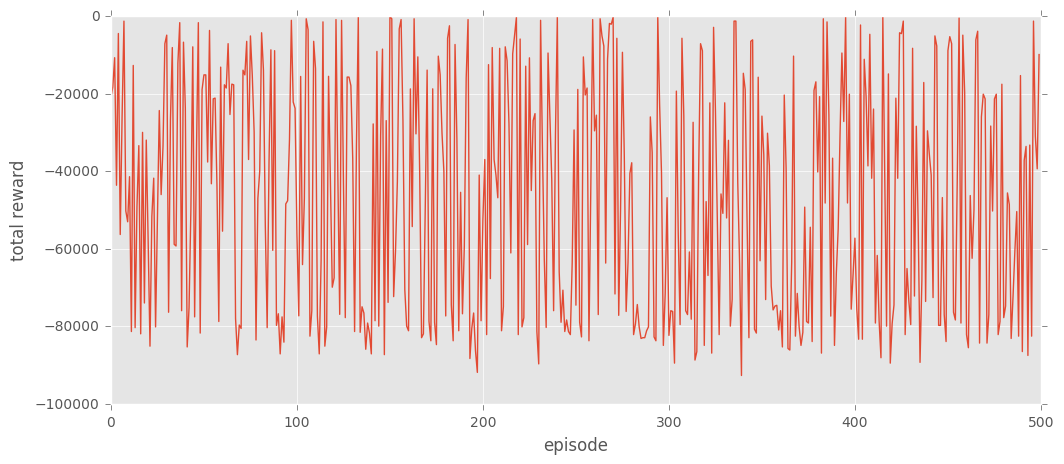

In [2]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# create figure
fig = plt.figure(figsize = (12,5))
ax = fig.add_subplot(1,1,1)

# plot total reward history
ax.plot(small_maze_qlearner.training_reward)
ax.set_xlabel('episode')
ax.set_ylabel('total reward')
plt.show()

This rapid fluctuation in total reward per episode is what we typically see when using random action selection for training an RL agent. The average reward over time does not improve even though $Q$ is getting better and better as we go along. Adjacently this means that the average amount of computation time stays roughly the same no matter how well we have resolved $Q$.  

While traininng with random action selection does force us to **explore** the input space well during training, we never **exploit** the resolving $Q$ function during training in order to take actions. After a while - at least - it seems clear that we don't need to rely completely on random action-taking. We can use our (partially) resolved $Q$ to take proper actions while training. As $Q$ becomes more and more close to optimal this would clearly lower our training time in later episodes, since we are taking actions informed by the $Q$ function instead of merely random ones.  

But when should we start exploiting our $Q$ function during training? We already have a sense of what happens if we never do this - training will be highly ineffecient. On the other hand, if we start exploiting too soon and too much we might not explore enough of the state space to create a robust learner as our learning of $Q$ would be heavily biased in favor of early successful episodes.

In practice there are various ways of applying this **exploration-exploitation trade-off** for choosing actions during training. Most of these use a simple stochastic switch: at each step of an episode of simulation choose the next action randomly with a certain probability $p$, or via the optimal policy with probability $1-p$. In the most naive approach the probability $p$ is simply fixed beforehand at some value between 0 and 1, and used for all steps/episodes of training. Pseudo-code for this action switch looks as follows.

<hr style="height:1px;border:none;color:#555;background-color:#555;">
<p style="line-height: 1.7;">

<strong>1:</strong>&nbsp;&nbsp; set the exploration-exploitation probability $p\in[0,1]$<br>

<strong>2:</strong>&nbsp;&nbsp;&nbsp;choose a random number $r$ uniformly from the unit interval $[0,1]$<br>

<strong>3:</strong>&nbsp;&nbsp;&nbsp;<code>if</code> $r<p$<br>

<strong>4:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;select a valid action $a_k$ at random<br>

<strong>5:</strong>&nbsp;&nbsp;&nbsp;<code>else</code><br>

<strong>6:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;select the valid action $a_k$ via optimal policy, i.e., $a_k$ that maximizes $Q\left(s_{k},\,a_{k}\right)$<br>

<strong>7:</strong>&nbsp;&nbsp;&nbsp;<code>end if</code><br>

<hr style="height:1px;border:none;color:#555;background-color:#555;">
</p>

More thoughtful implementations push $p$ towards zero as training proceeds, since our approximation of $Q$ gets better as training proceeds.

### Example. Exploration-exploitation on Gridworld

To see how much exploitation of $Q$ helps make training more effecient, we perform a number of experiments which compare it to strictly random action-taking.

The Gridworld Q-Learning library has both methods built in, and we can change between the two using the <code>action_method</code> argument, set to <code>random</code> or <code>exploit</code> for the random or exploration-exploitation action methods.  

In the next Python cell we run both Q-Learning action methods with the same initializations for 500 training episodes. The exploration-exploitation probability is set to 0.5 for all runs. 

In [3]:
### compare random versus exploit-based training 

# create a q-learner that will use random actions
random_qlearner = gridworld_qlearn.learner(gridworld = small_maze)

# create a q-learner that will use exploration-exploitation
exploit_qlearner = gridworld_qlearn.learner(gridworld = small_maze)

# train each: random and exploit-based learners
random_qlearner.train(verbose = False, action_method = 'random')
exploit_qlearner.train(verbose = False, action_method = 'exploit')

q-learning algorithm complete
q-learning algorithm complete


Having run both algorithms we can compare them on any of the 500 episodes by using the Gridworld animator. In the next Python cell we animate the first 100 steps of the very first episode of each method and show the result side-by-side.  You can scroll through both simultaneously by pressing the play button.  


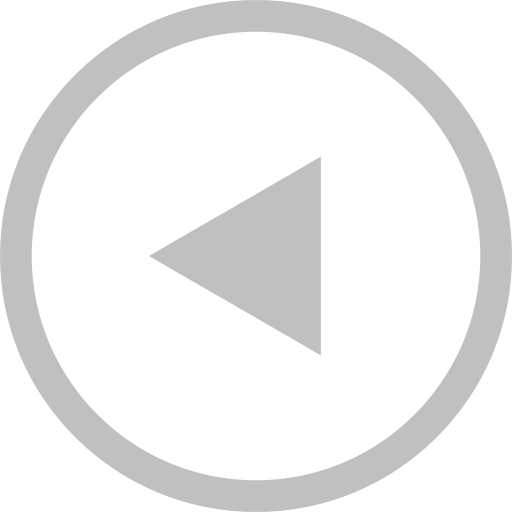
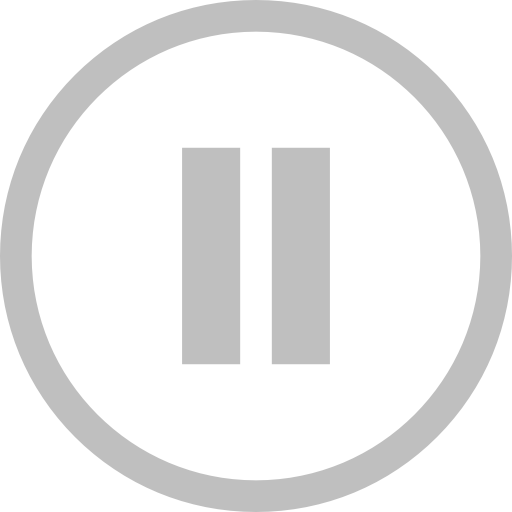
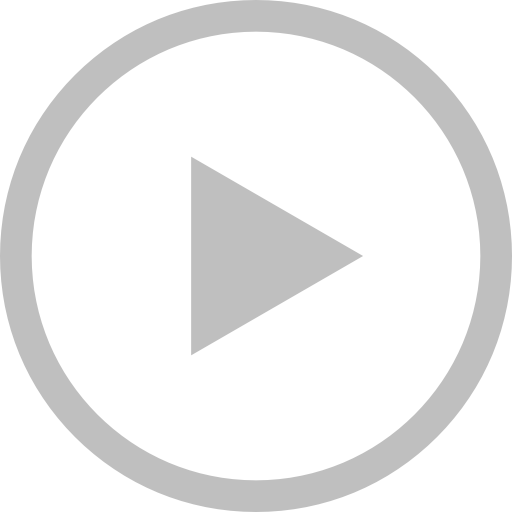
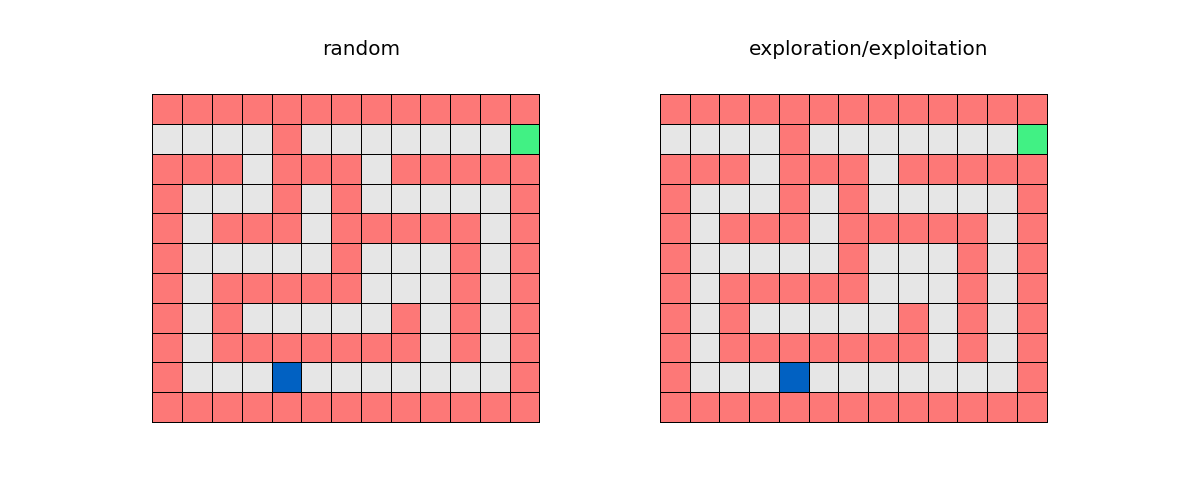
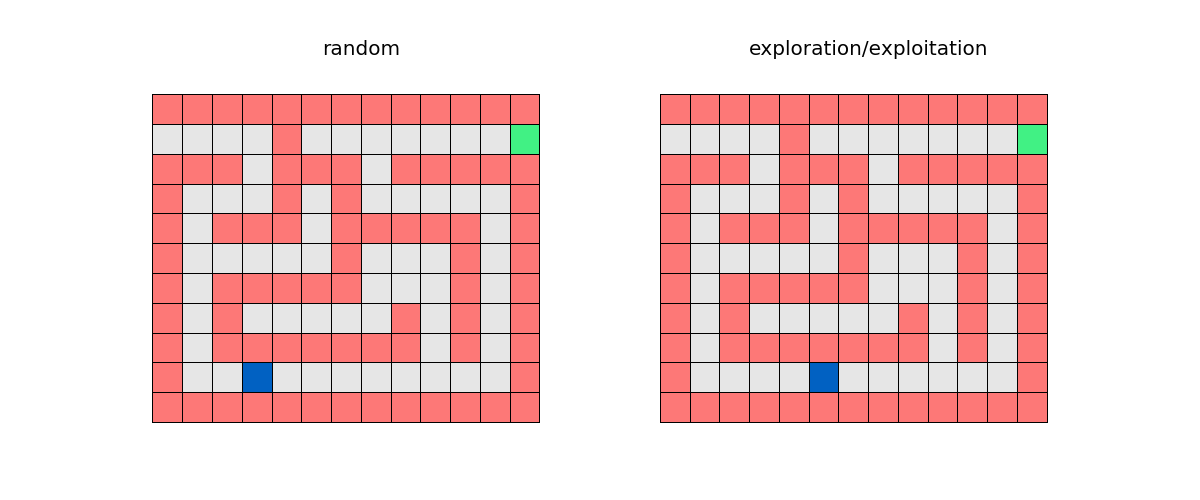
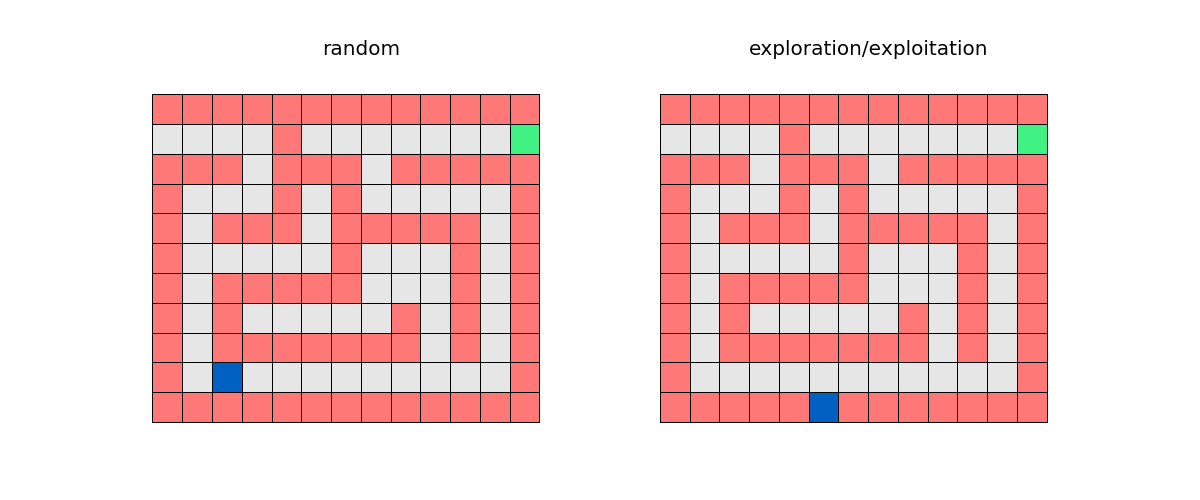
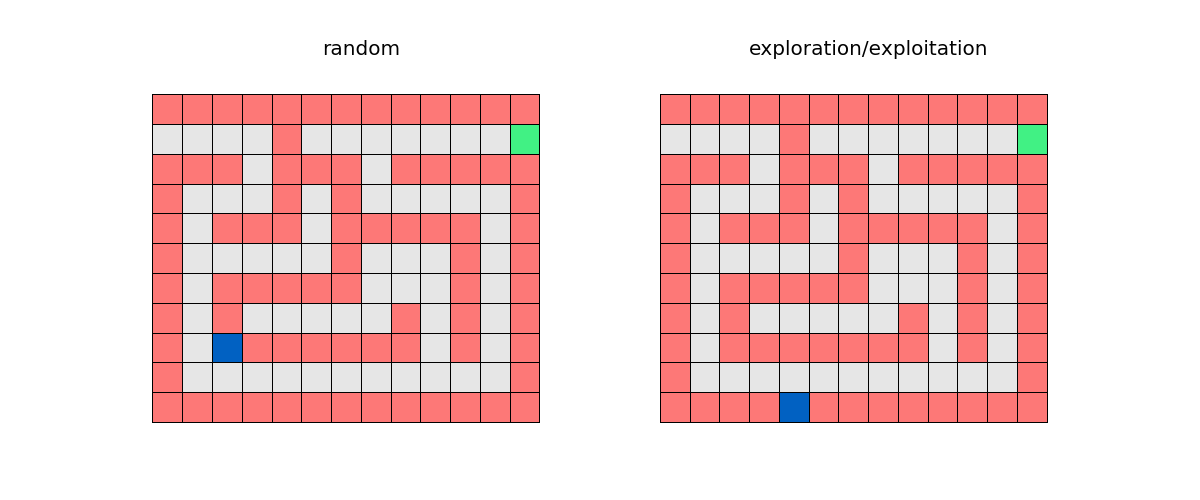
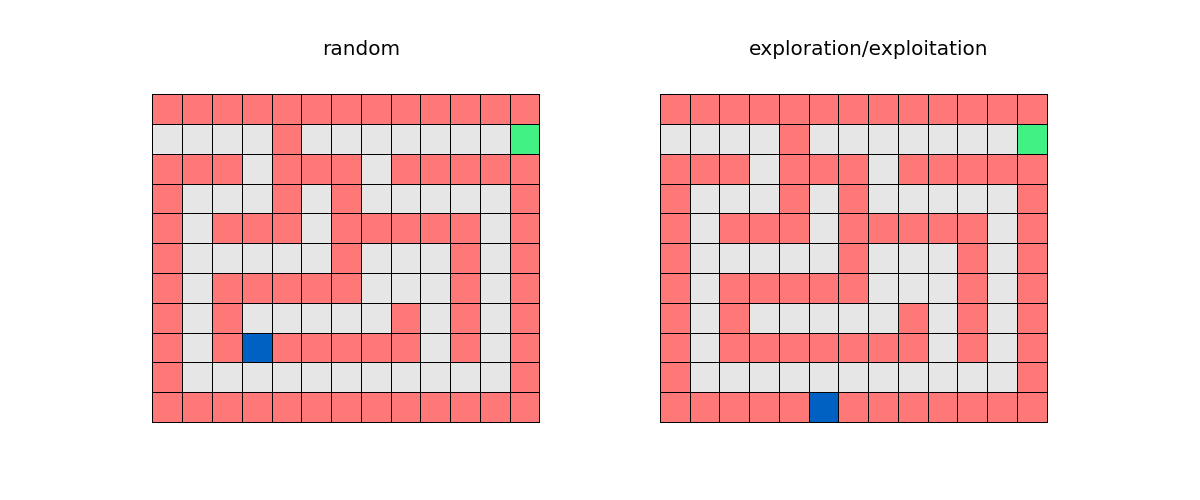
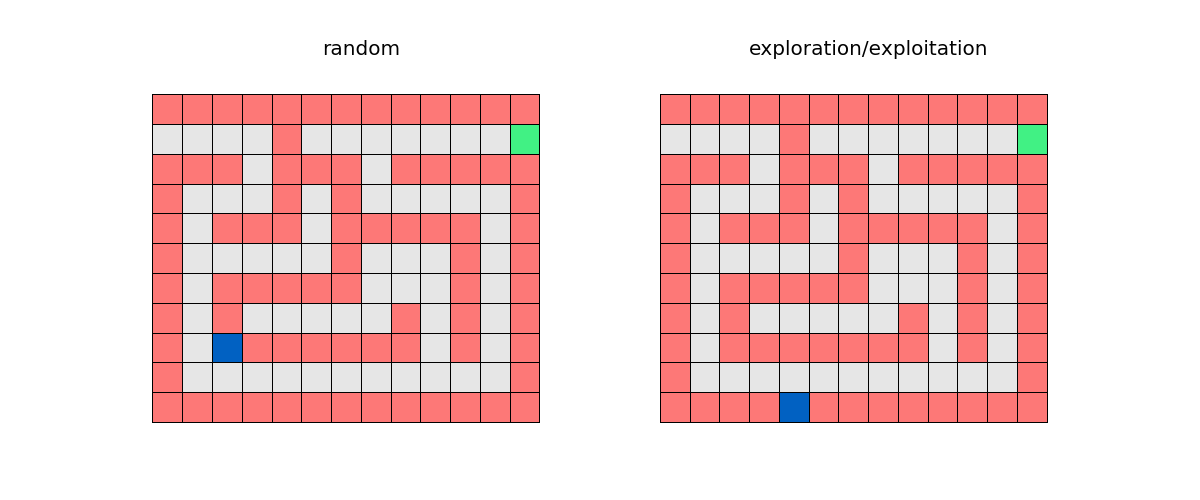
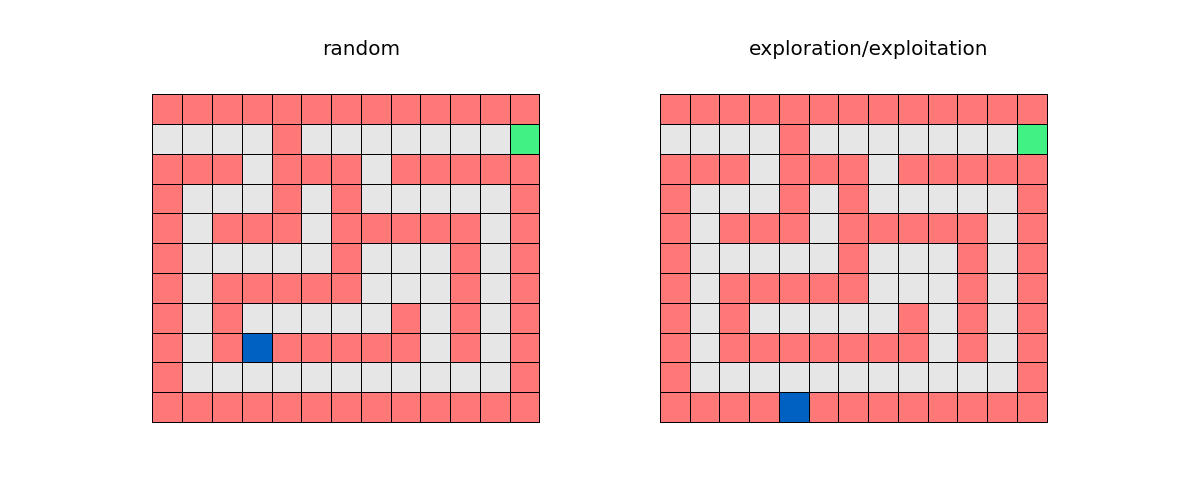
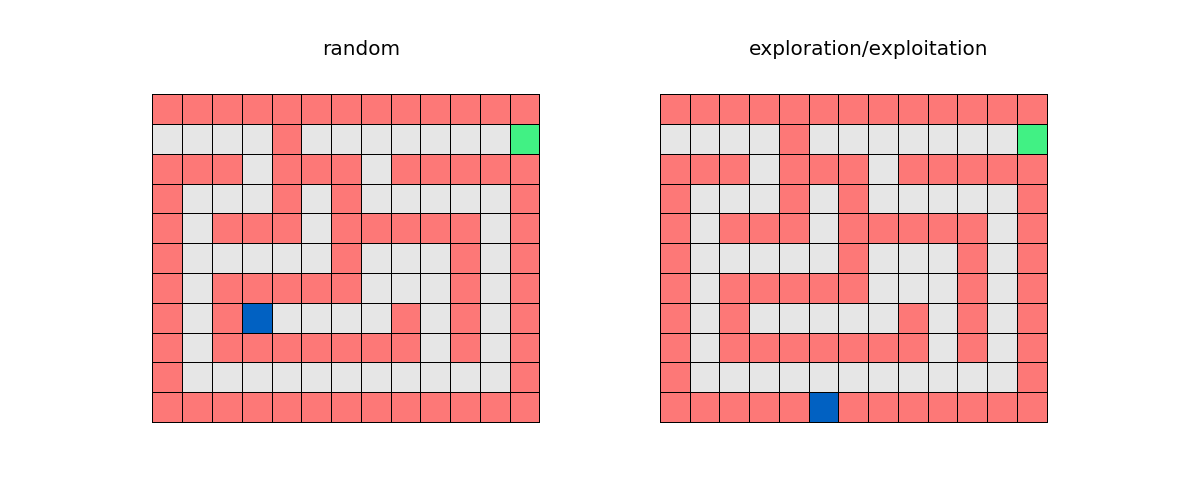
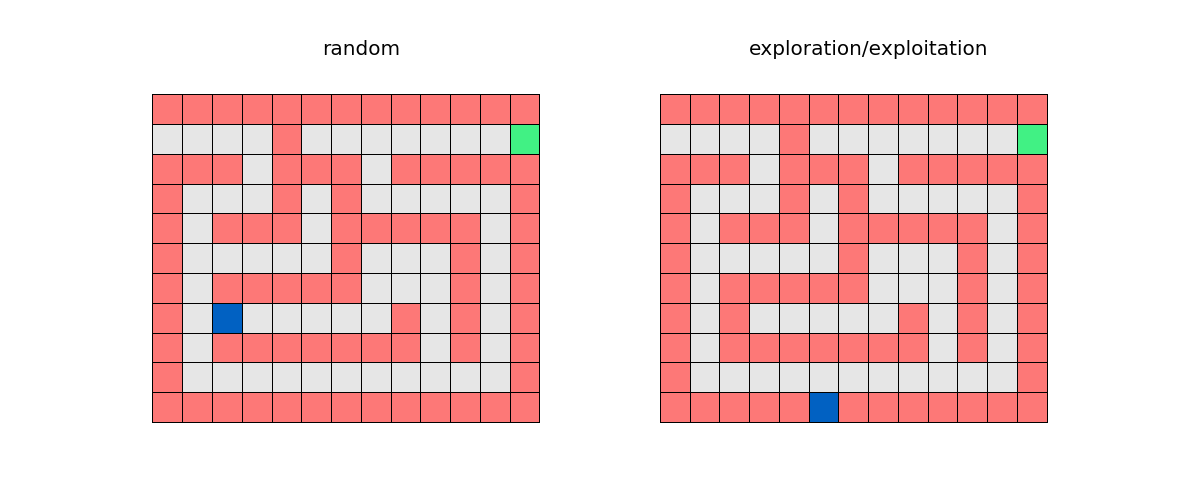
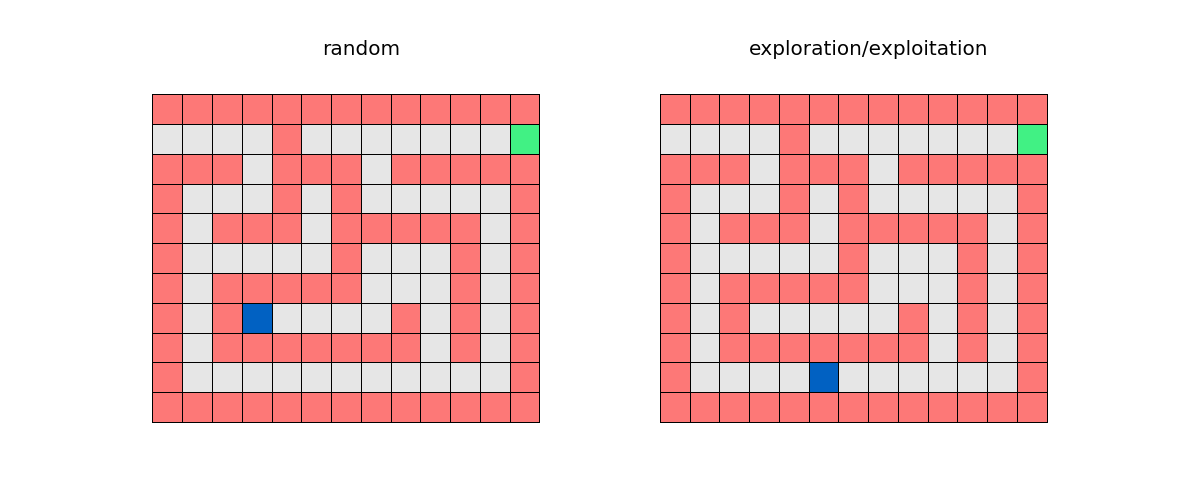
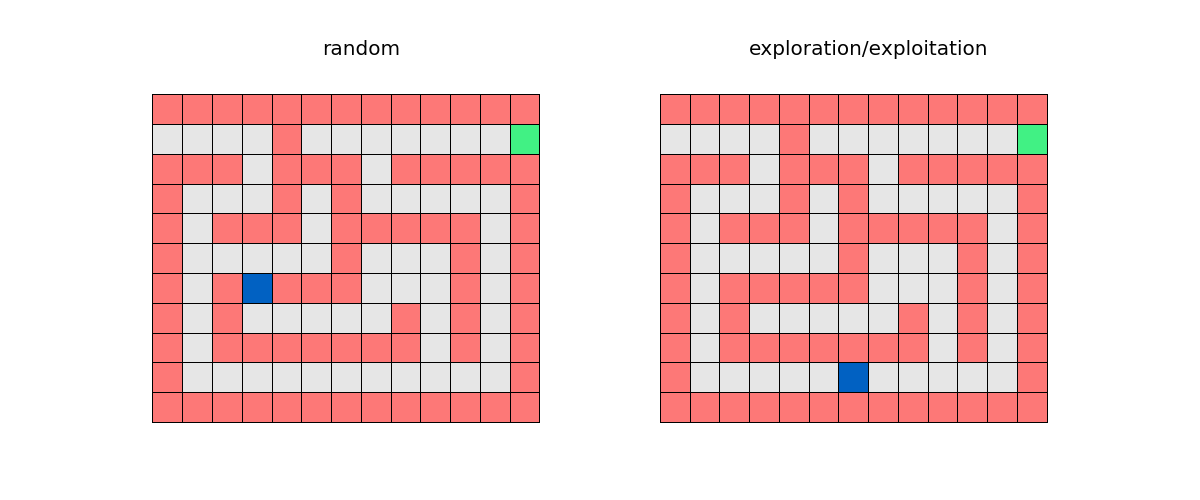
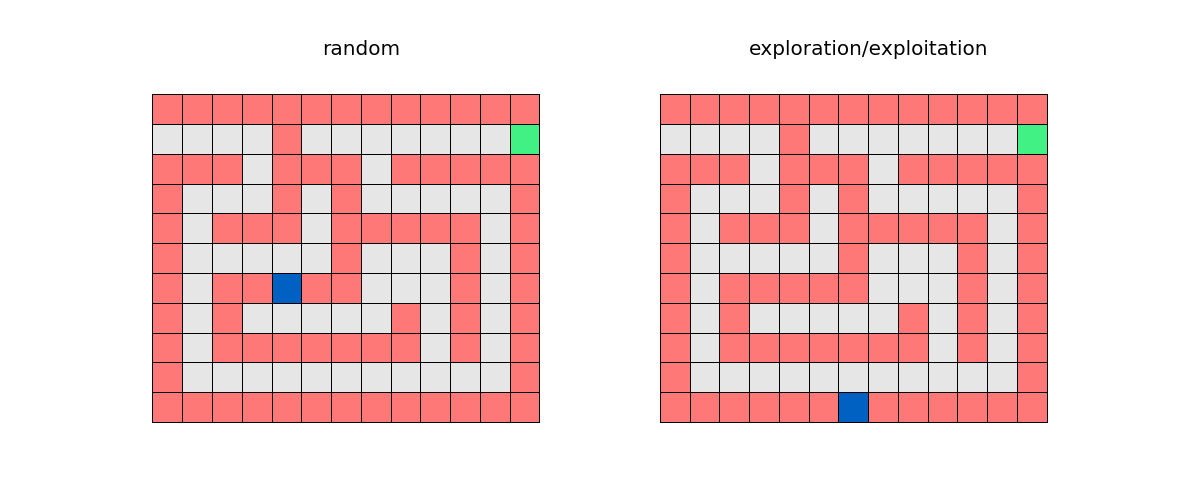
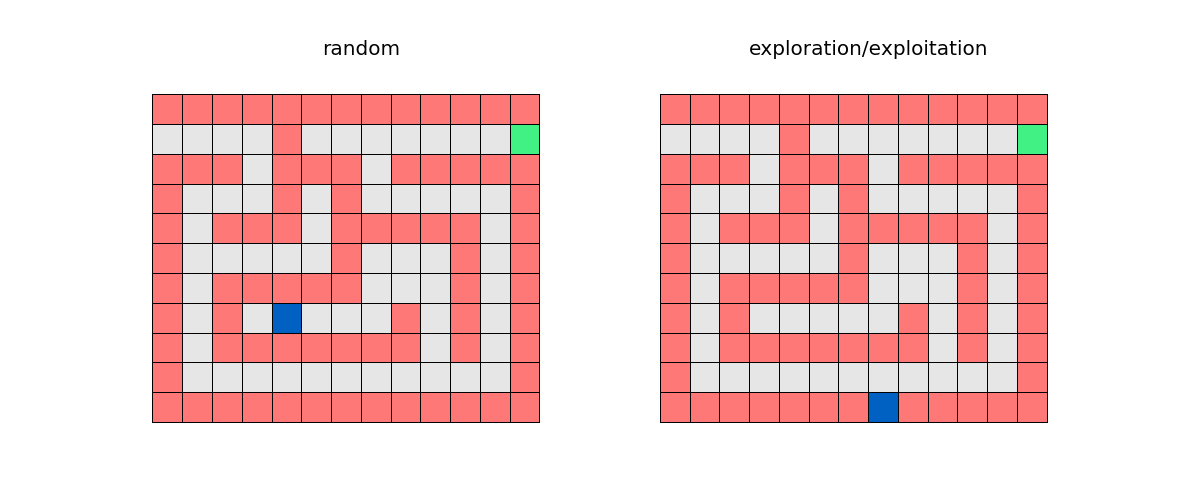
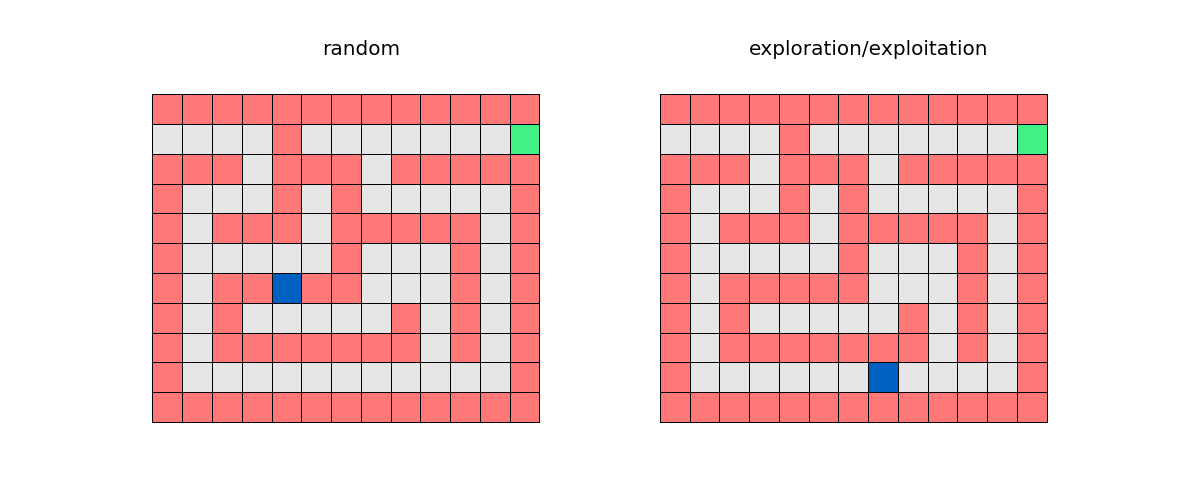
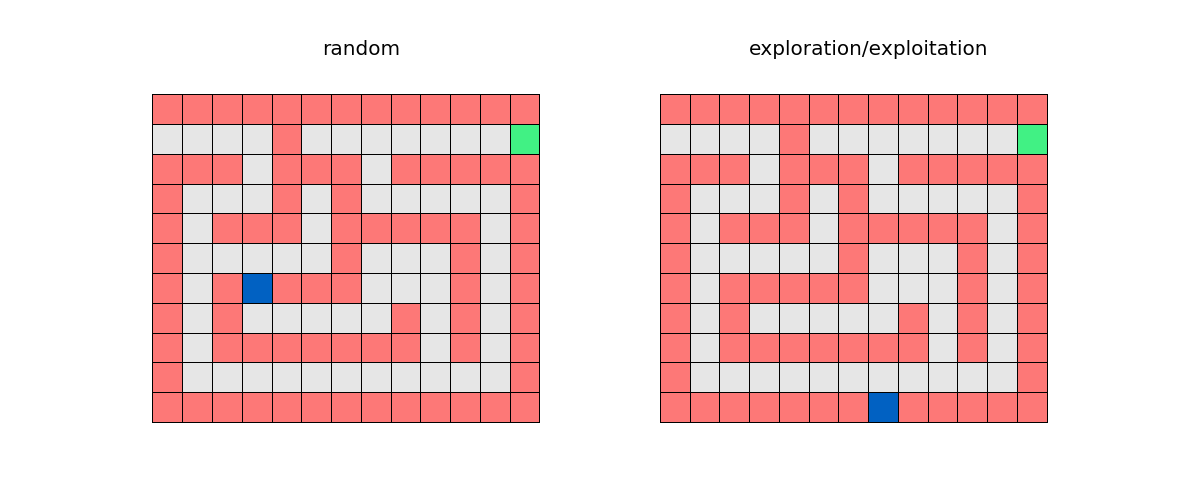
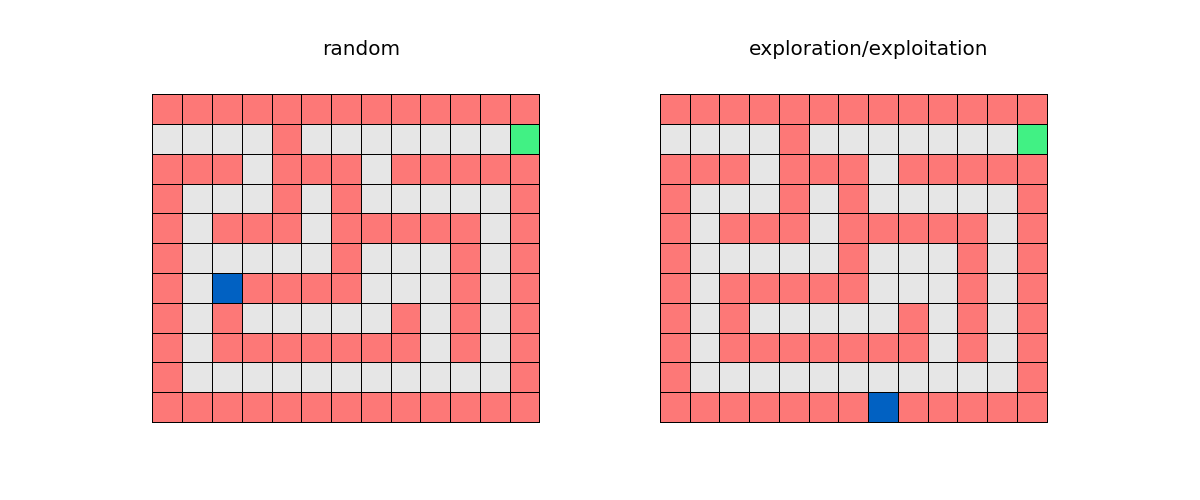
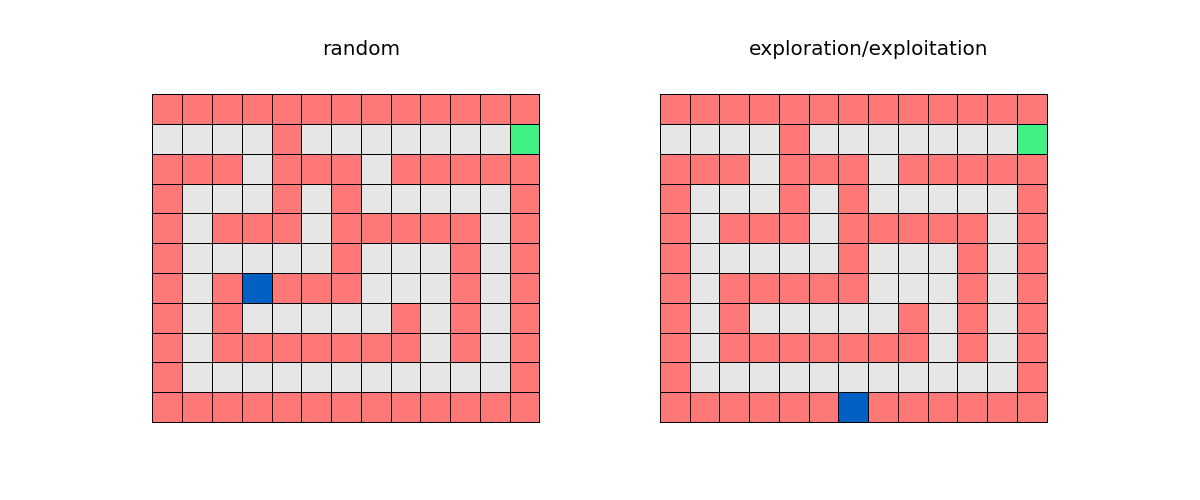
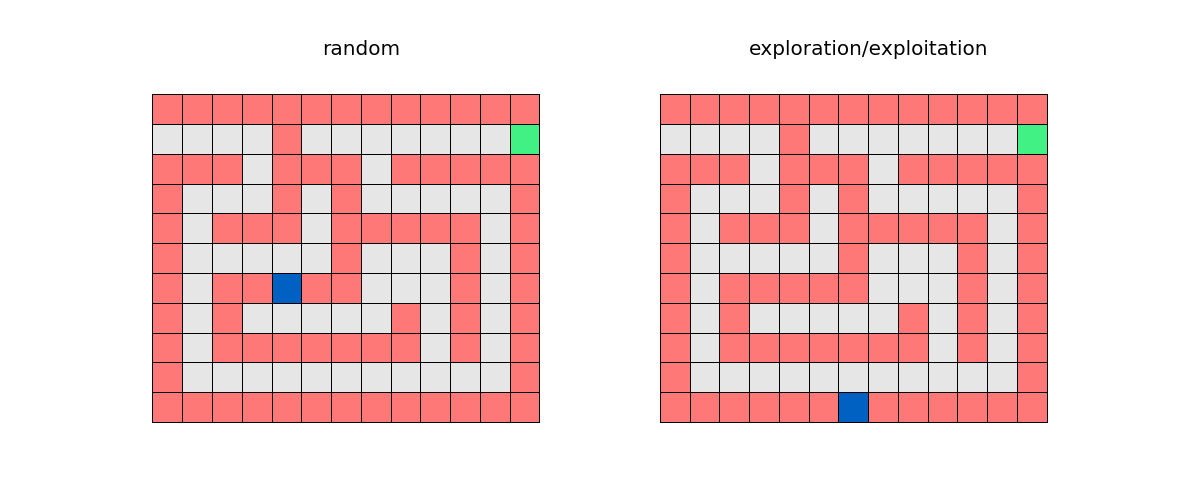
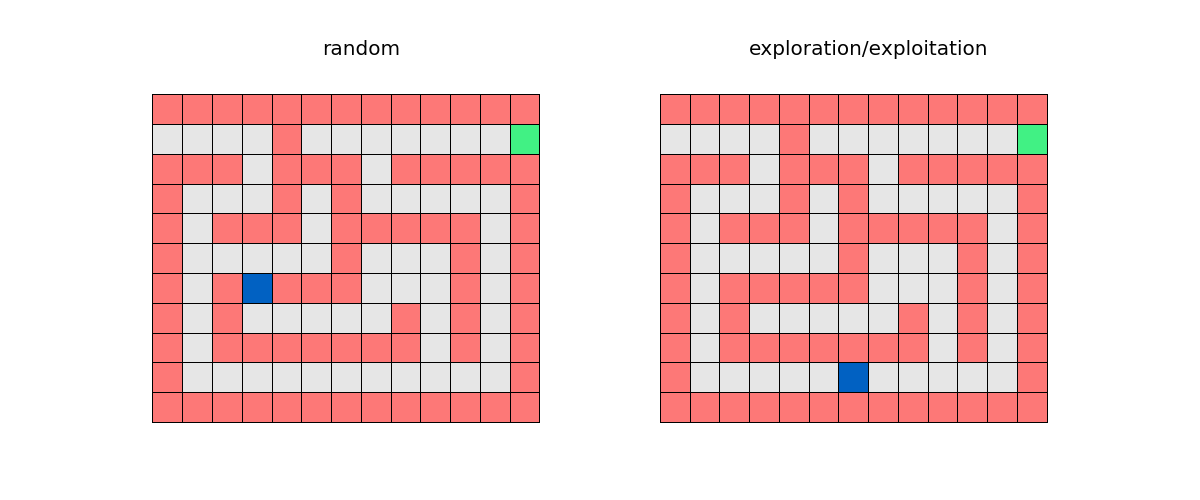
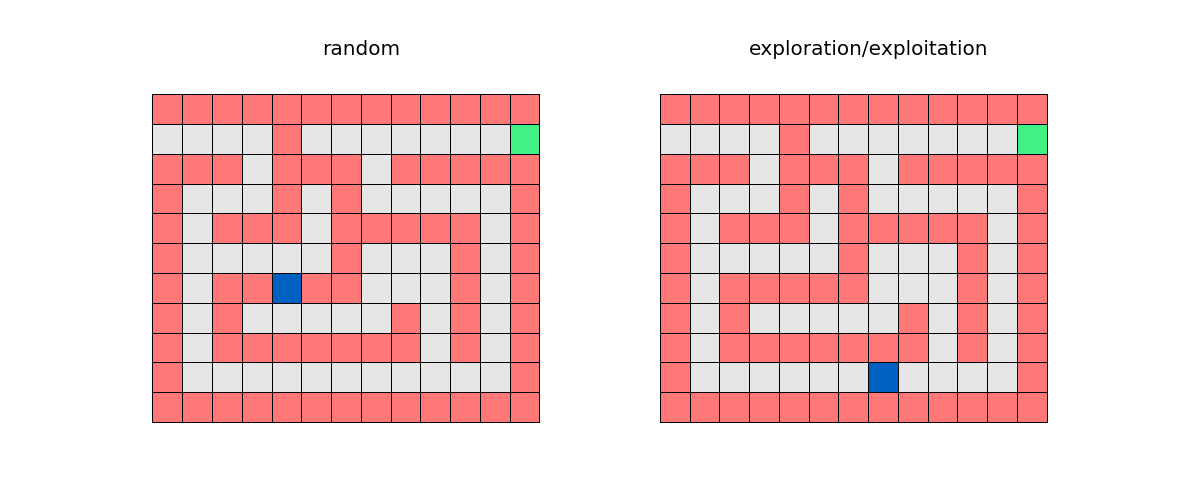
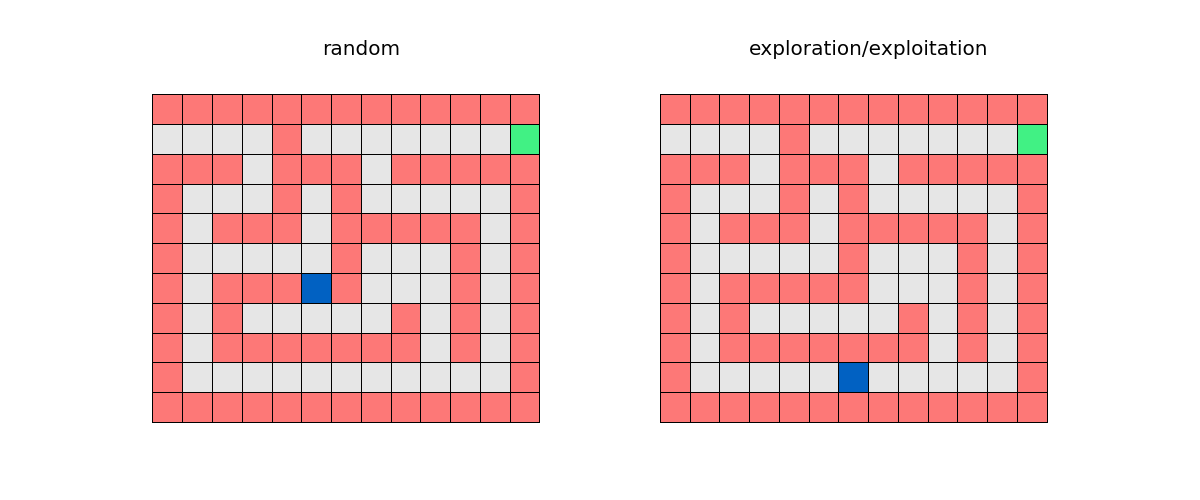
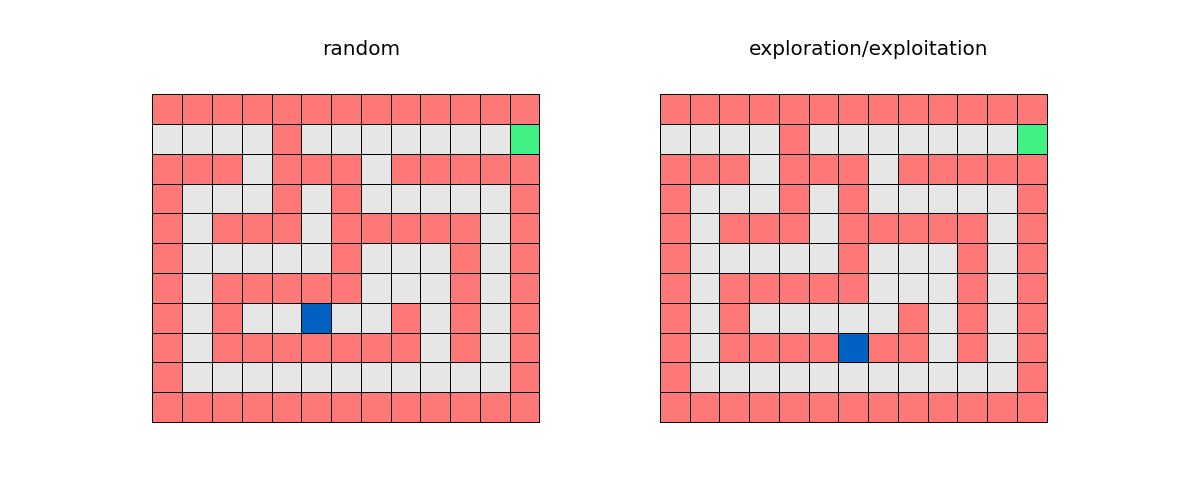
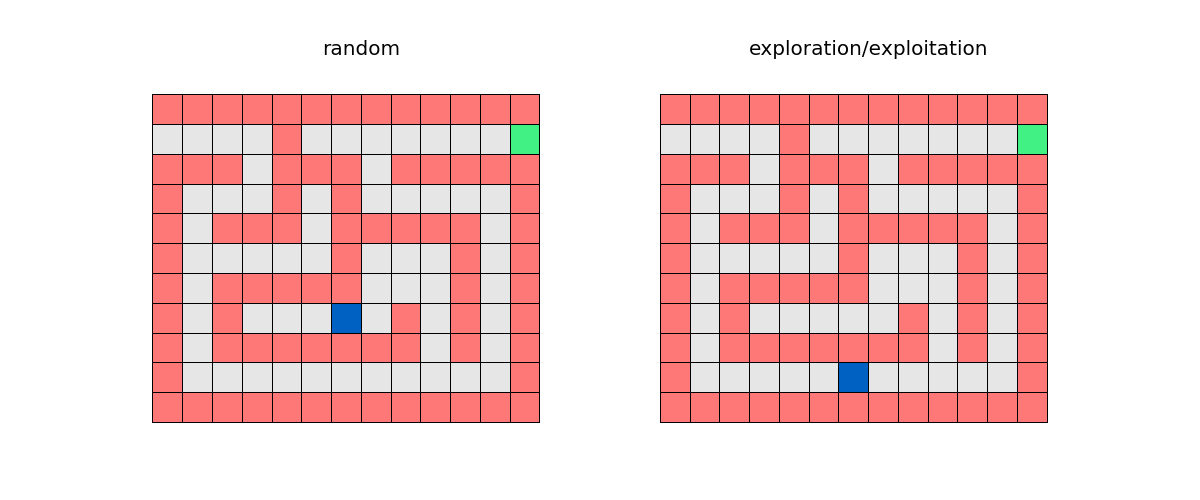
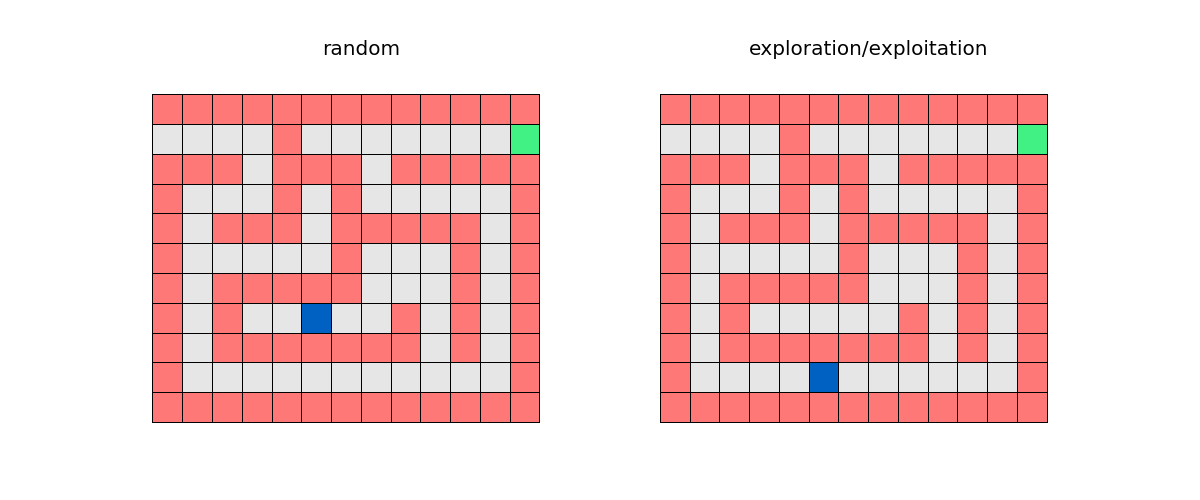
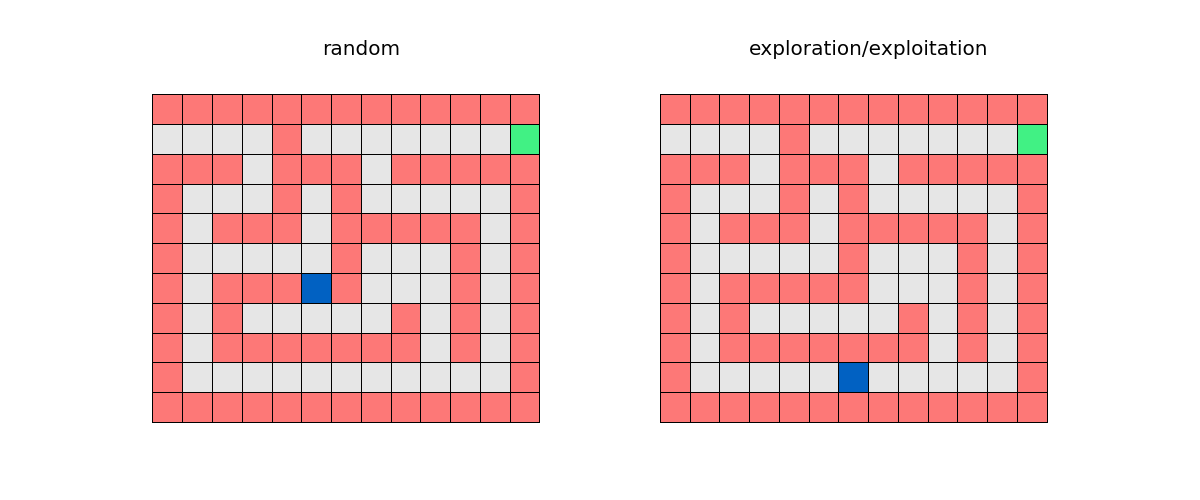
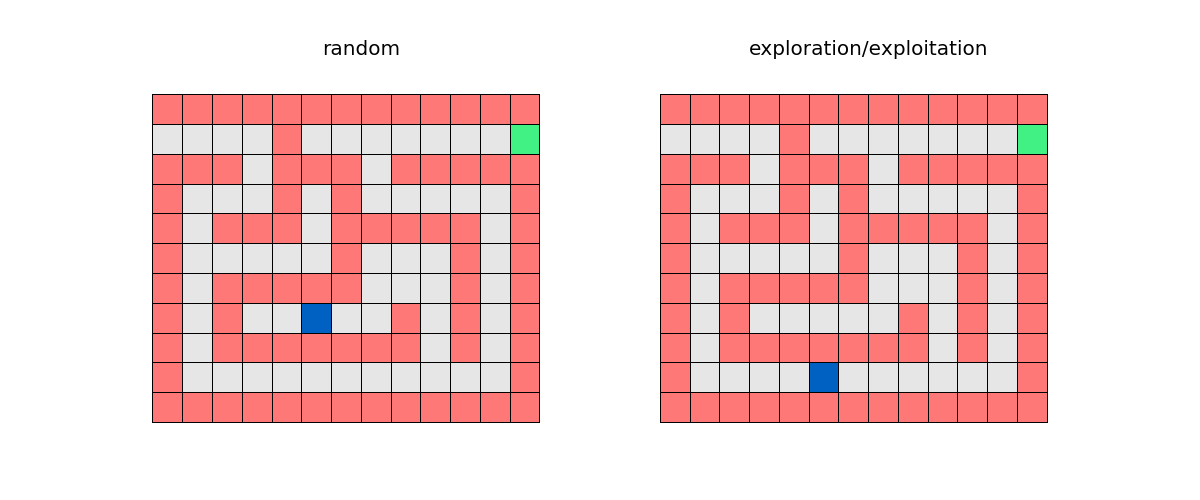
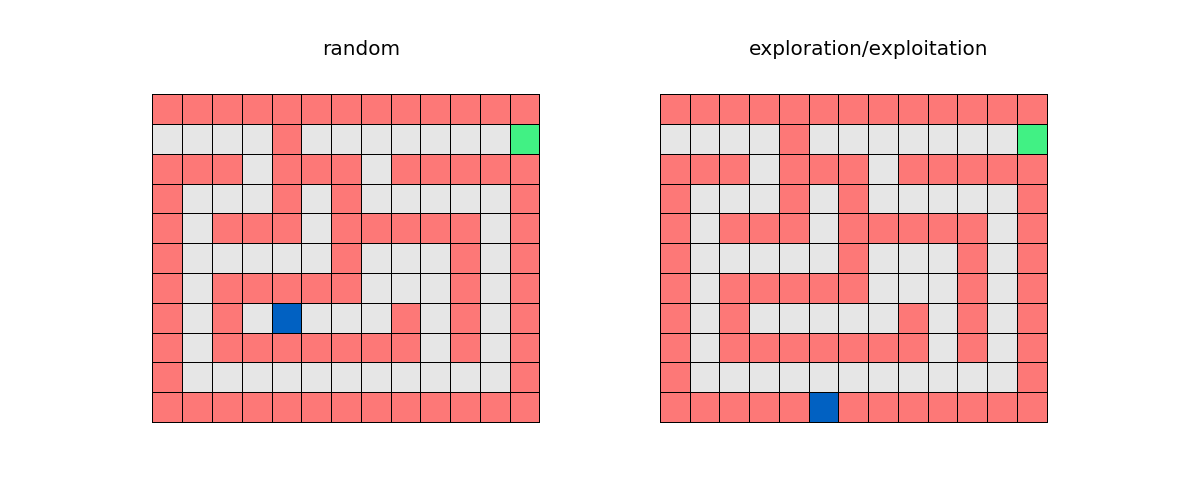
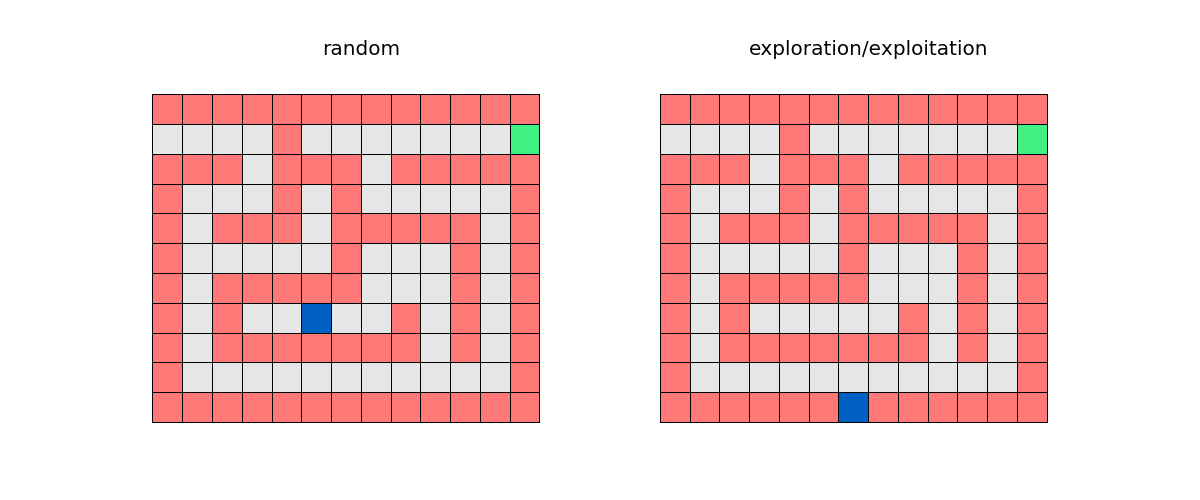
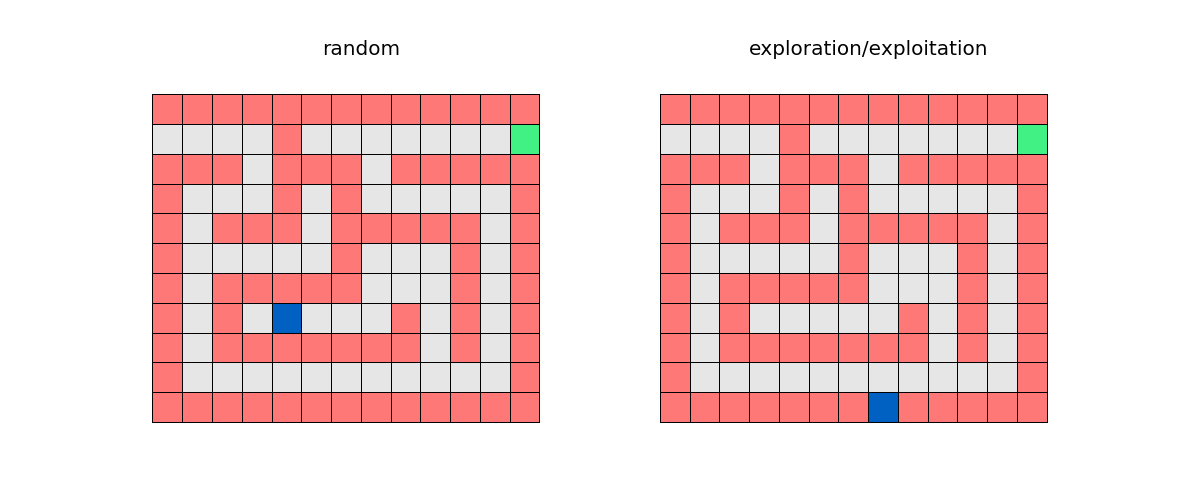
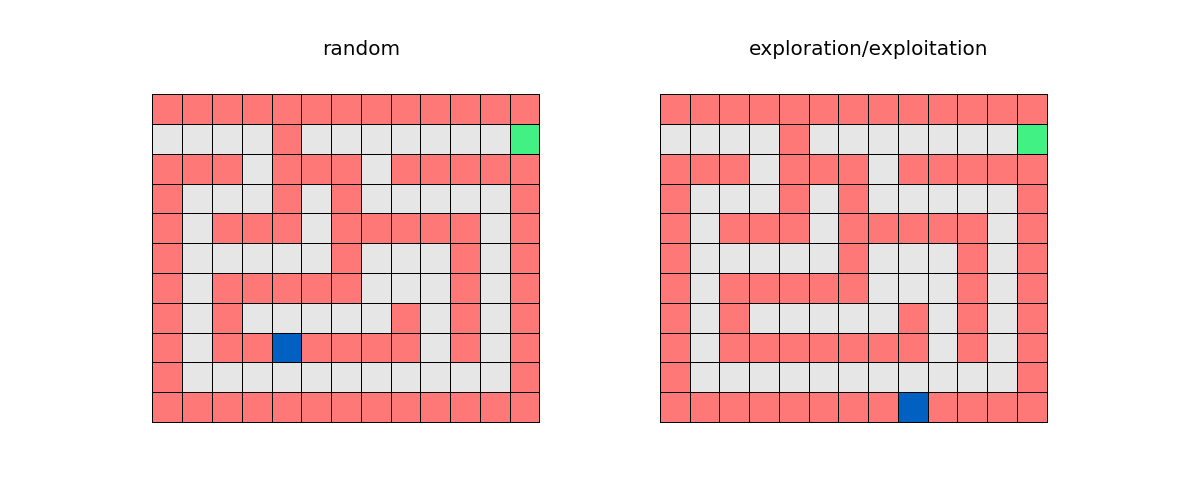
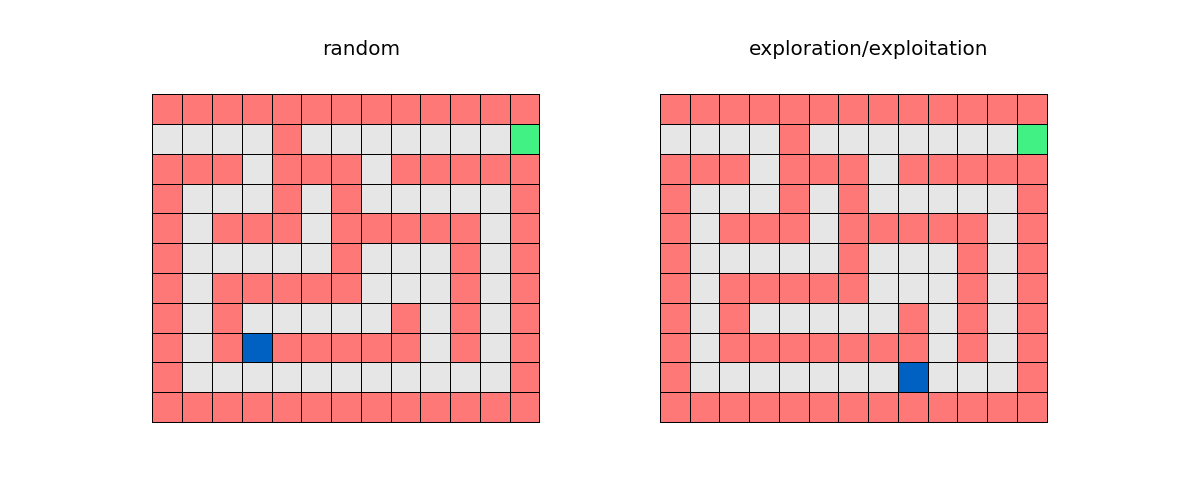
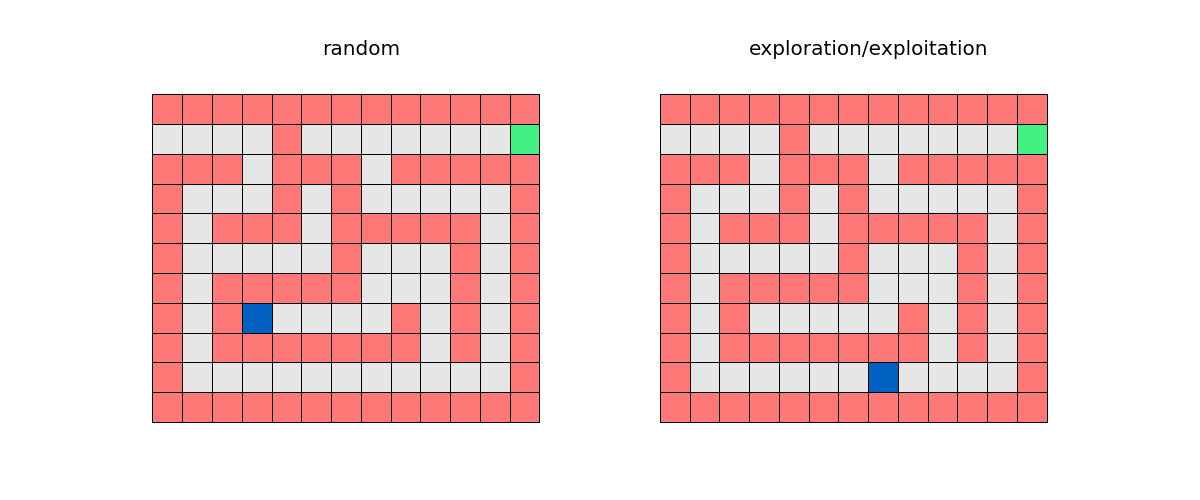
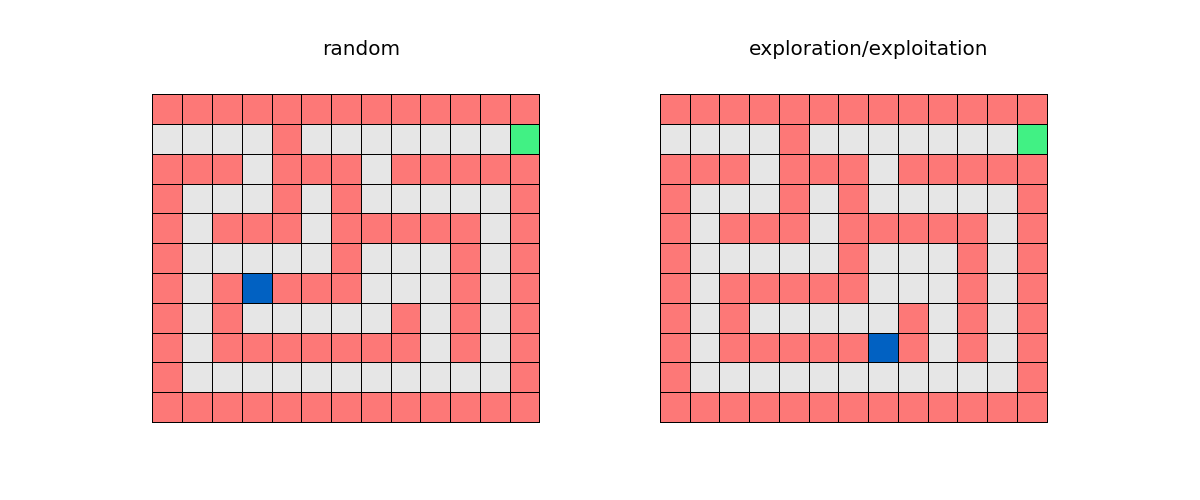
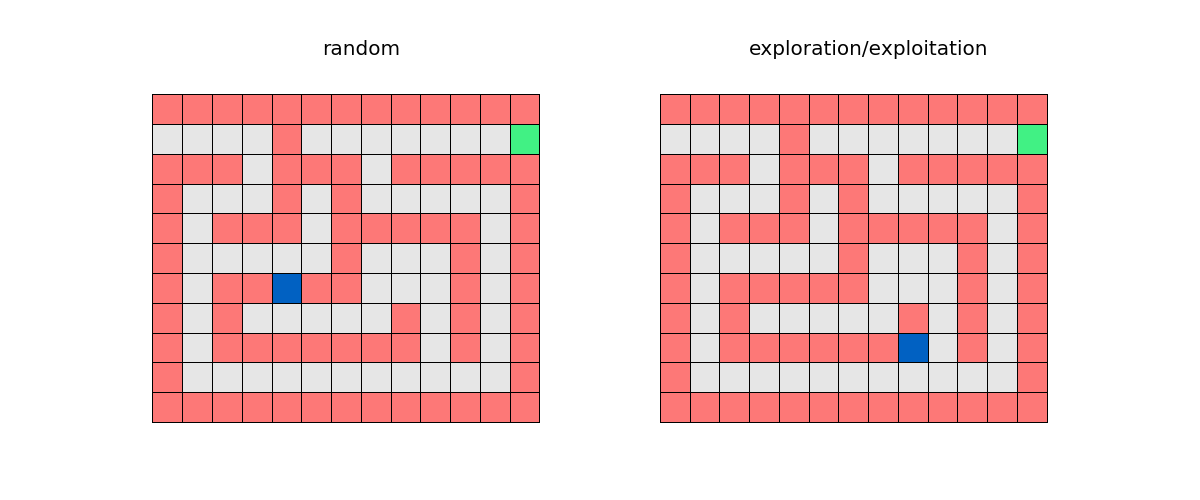
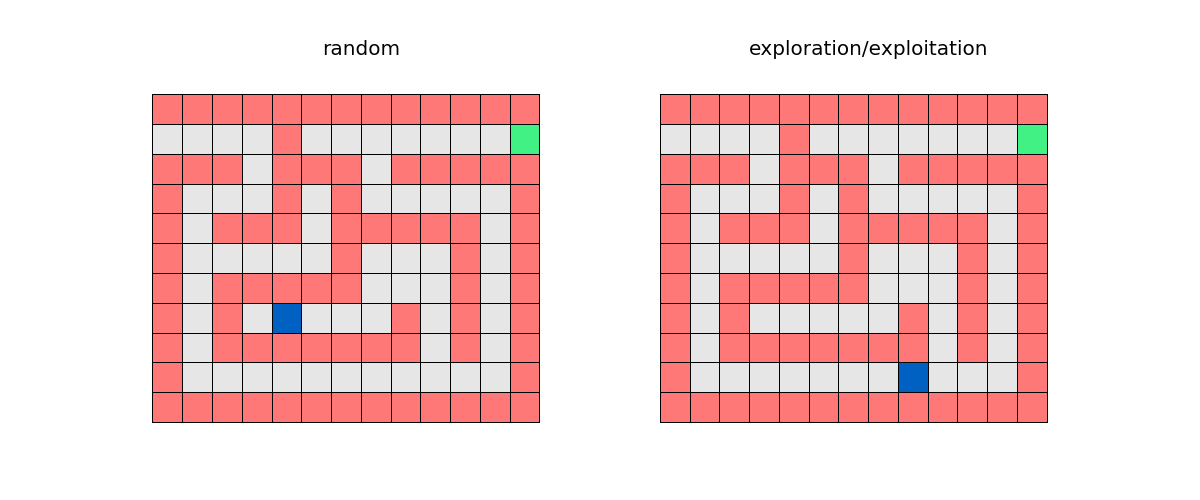
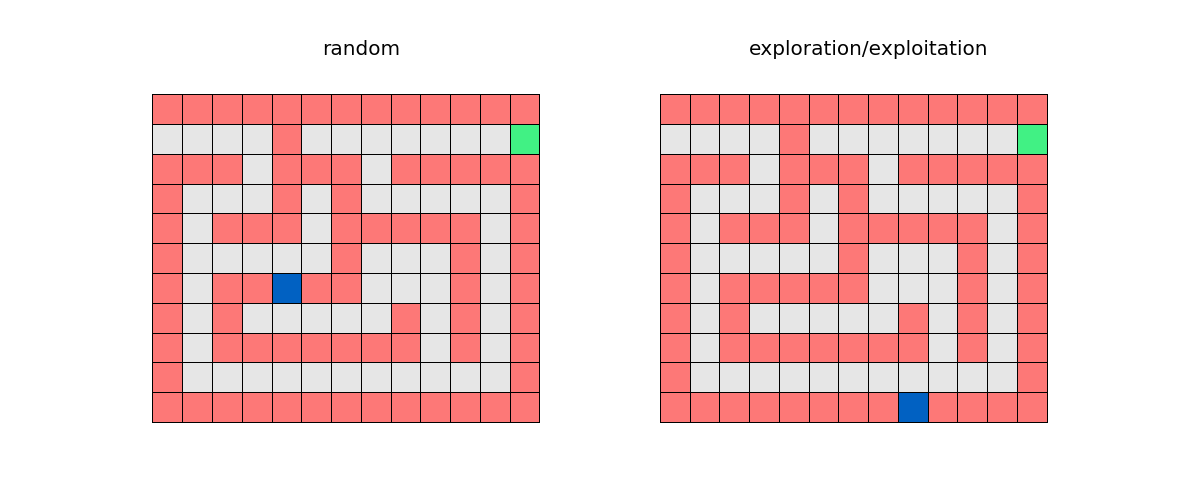
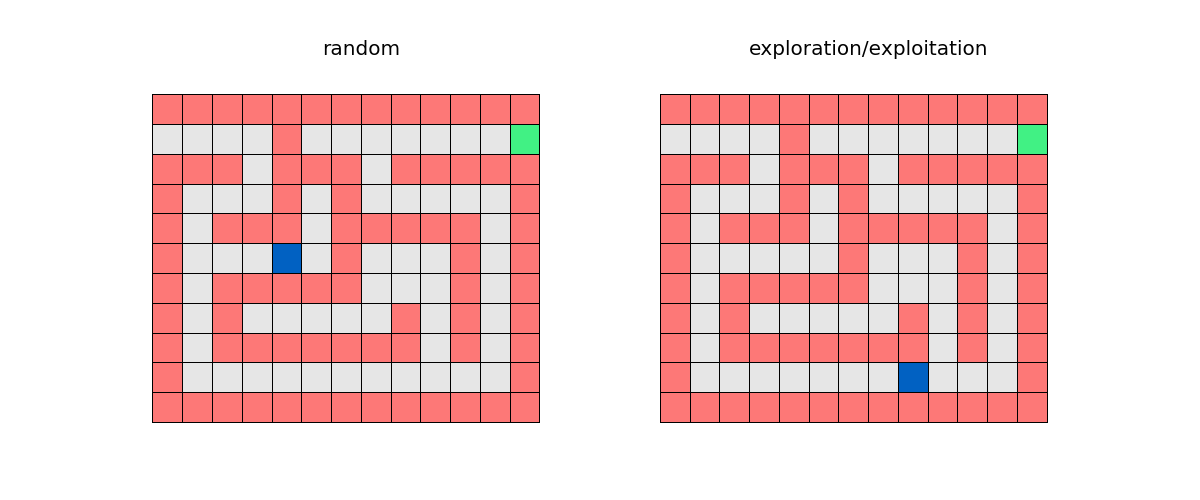
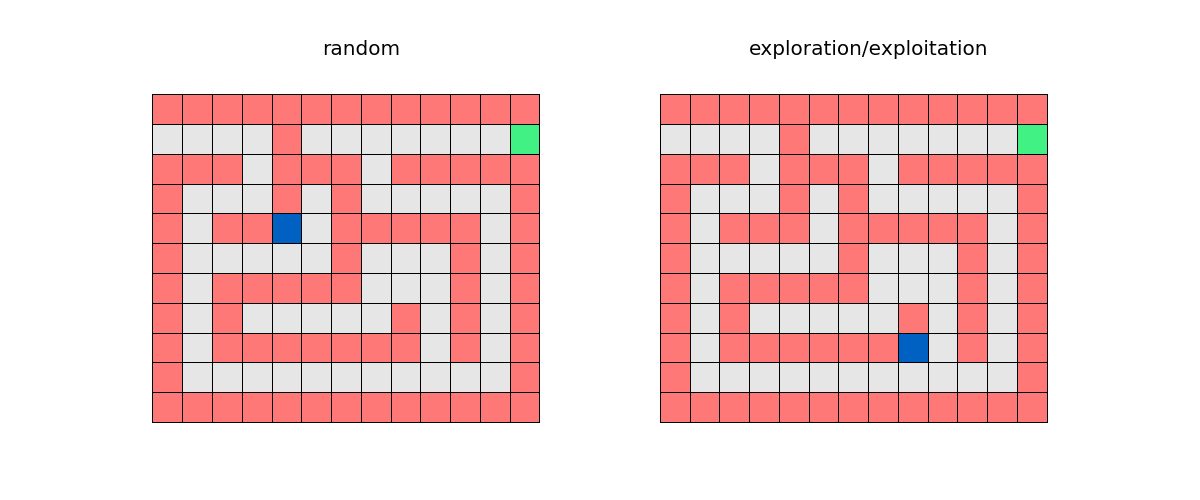
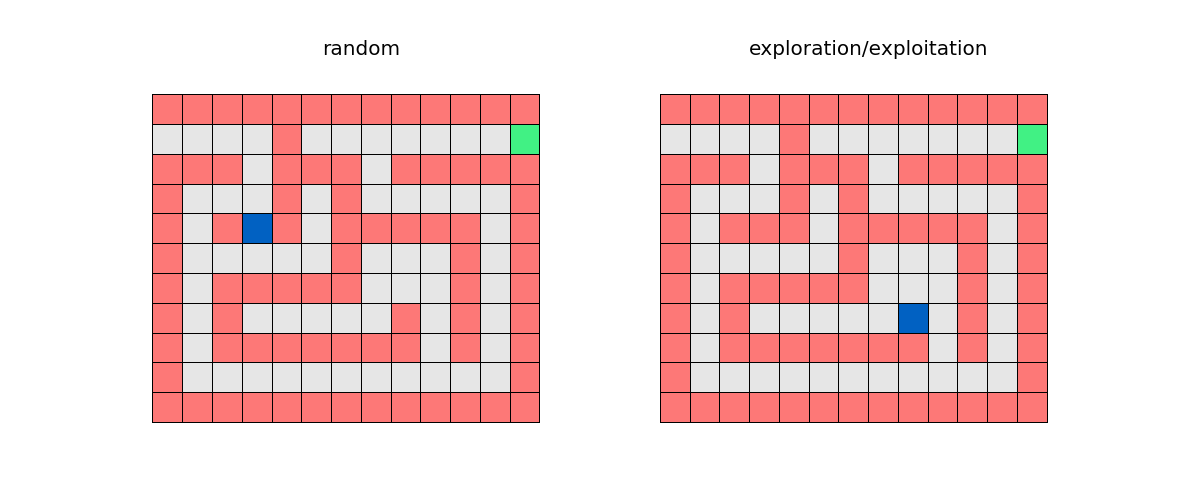
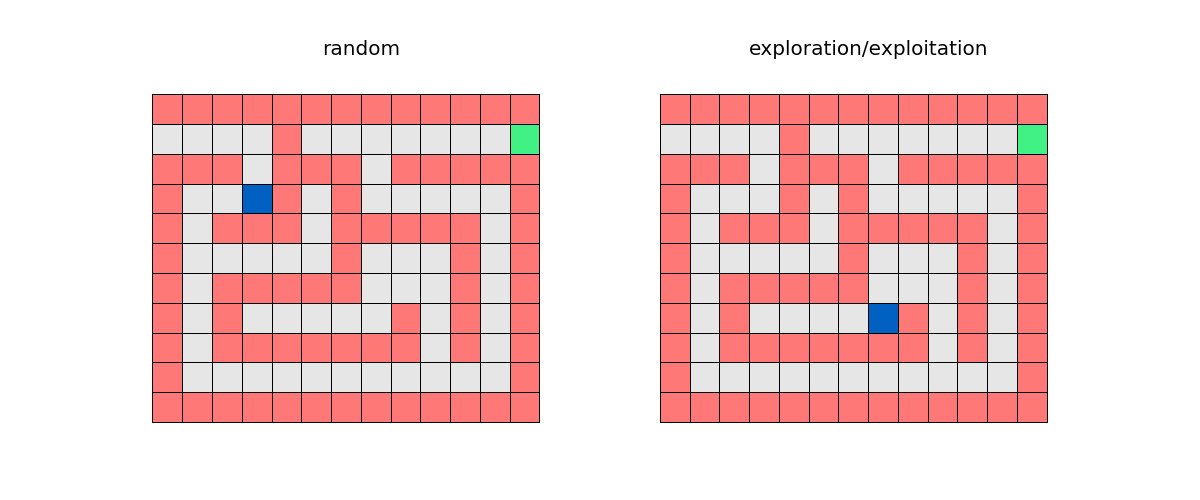
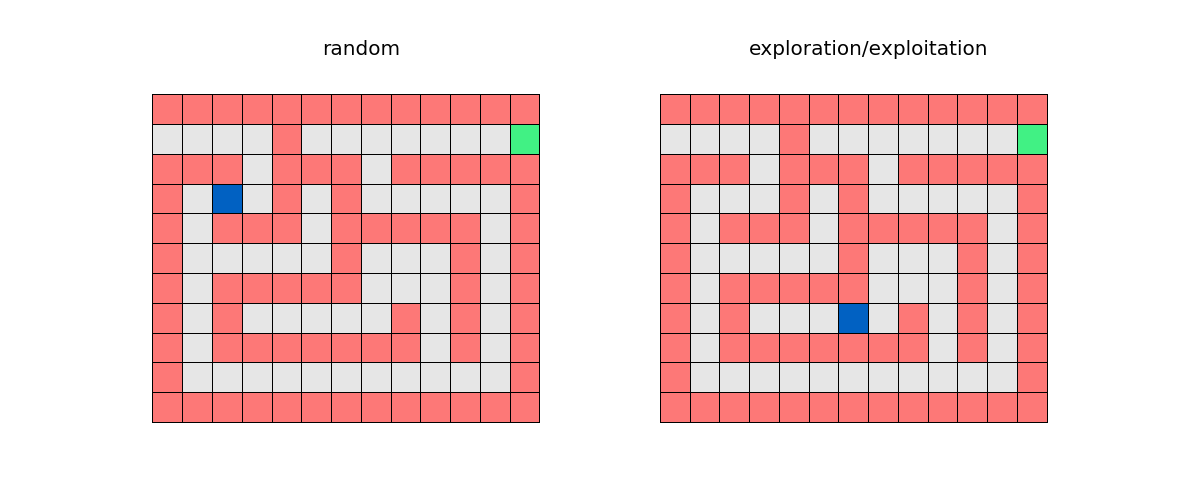
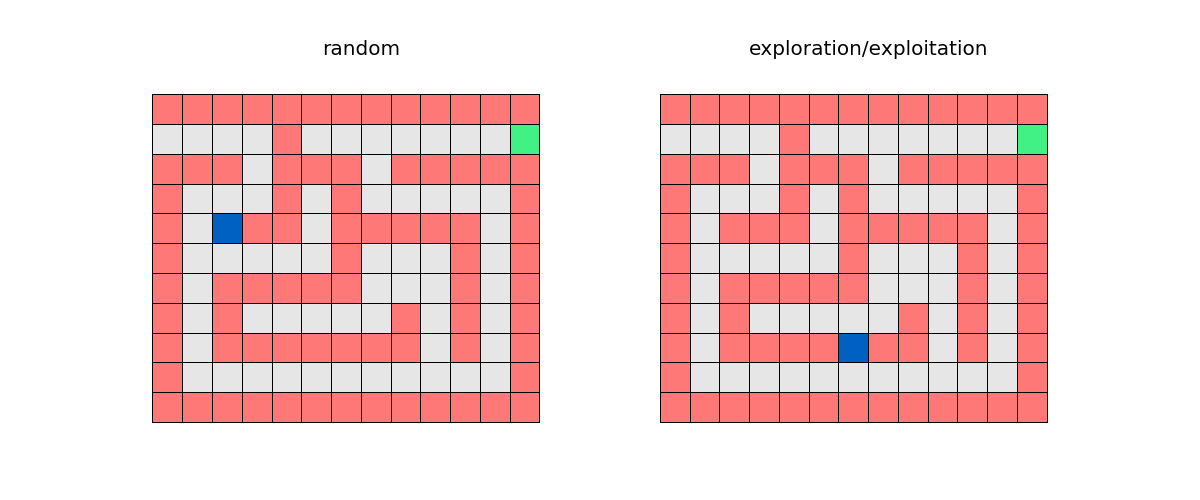
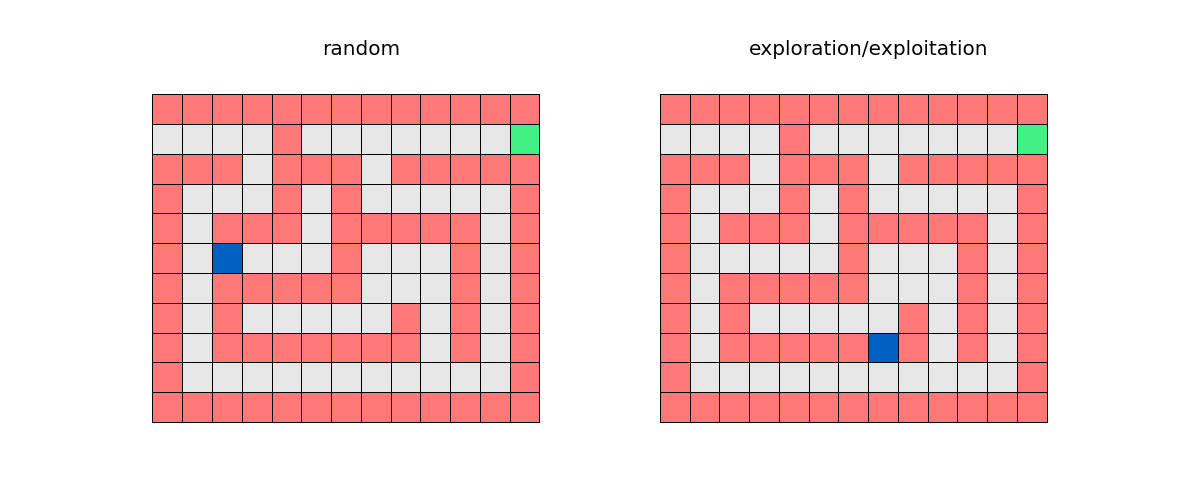
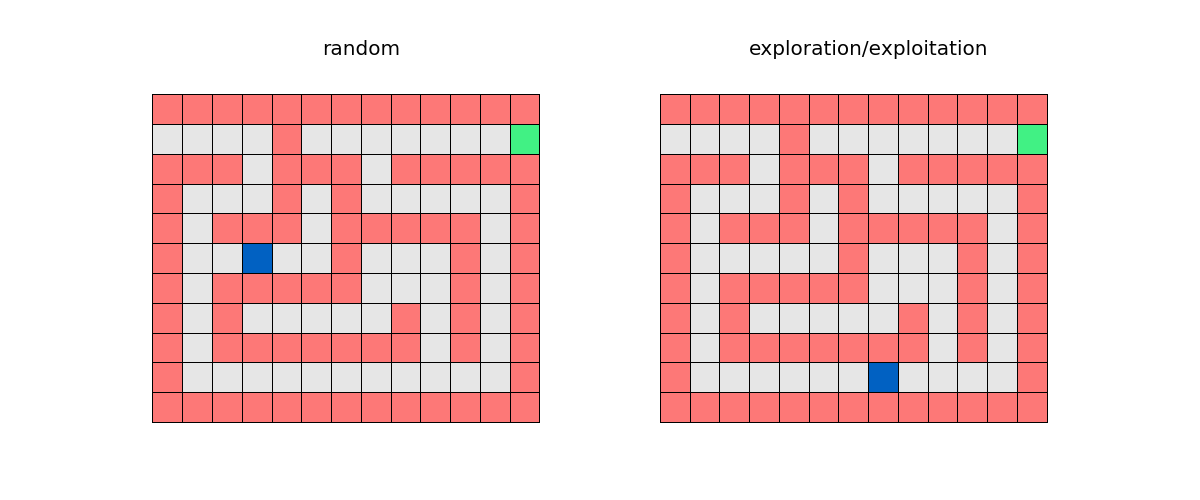
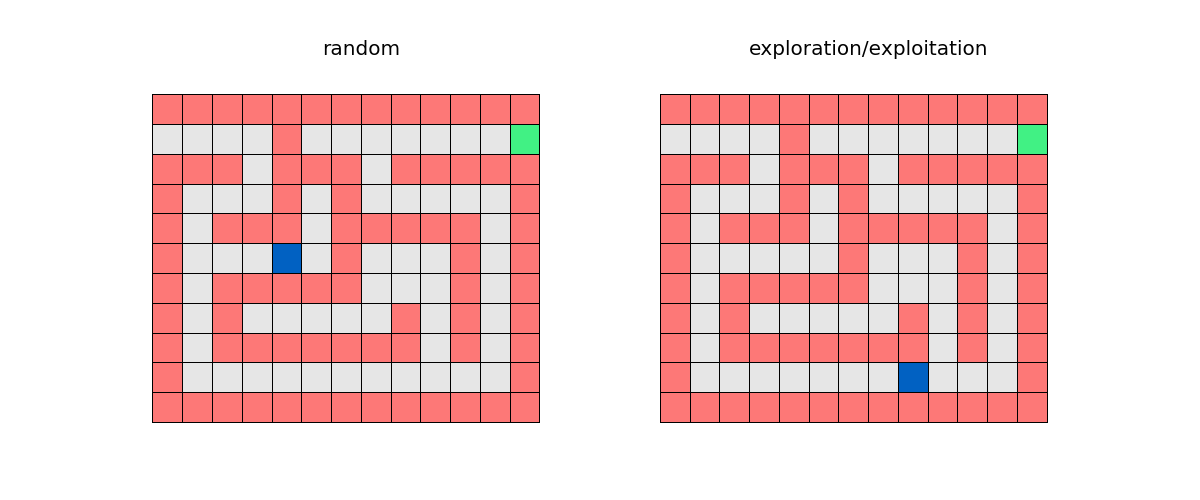
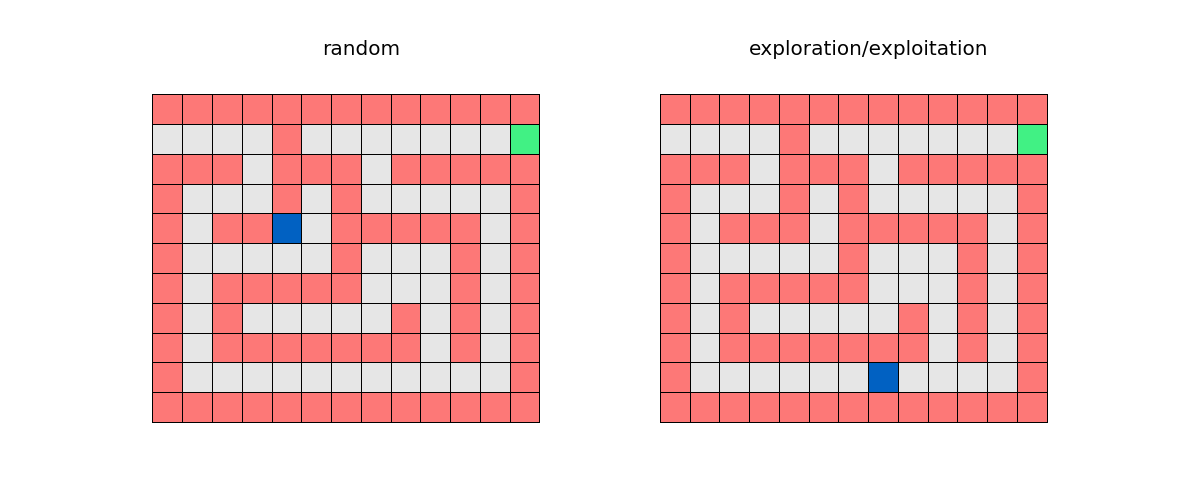
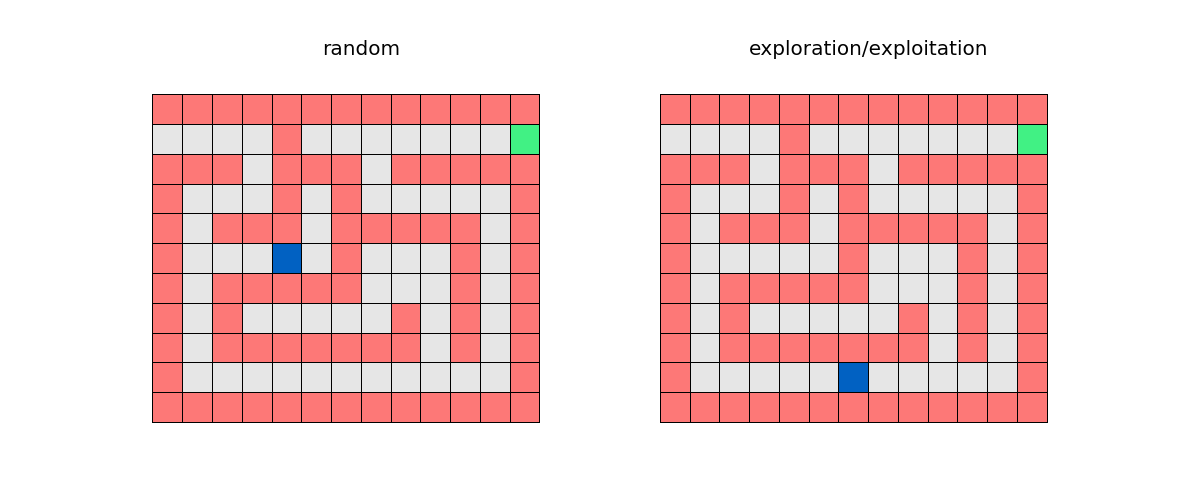
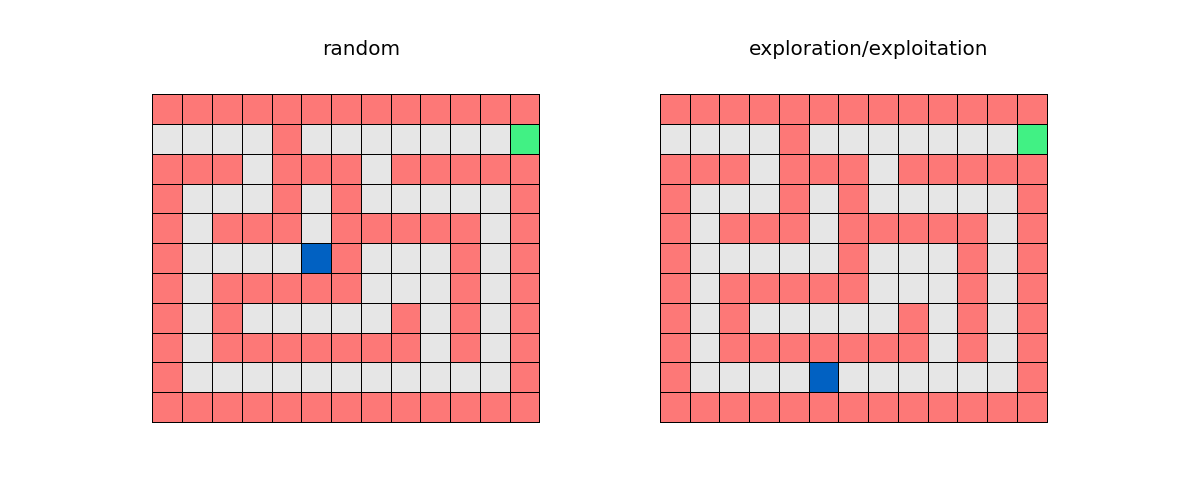
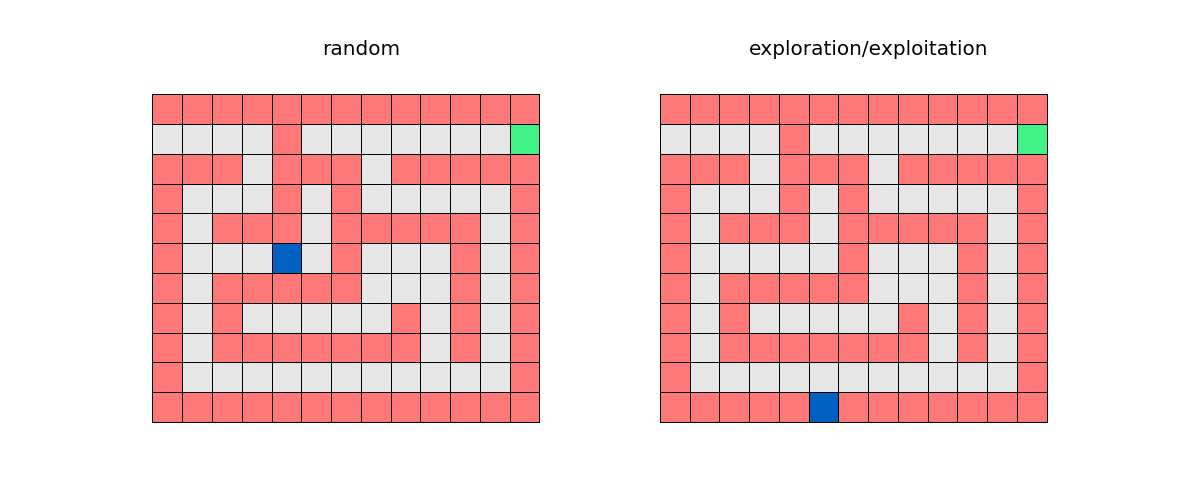
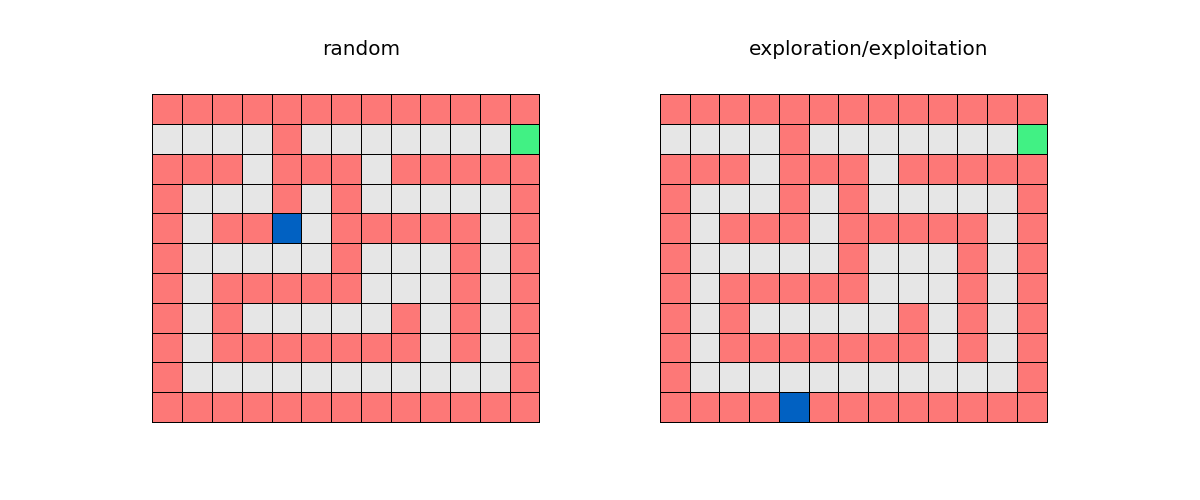
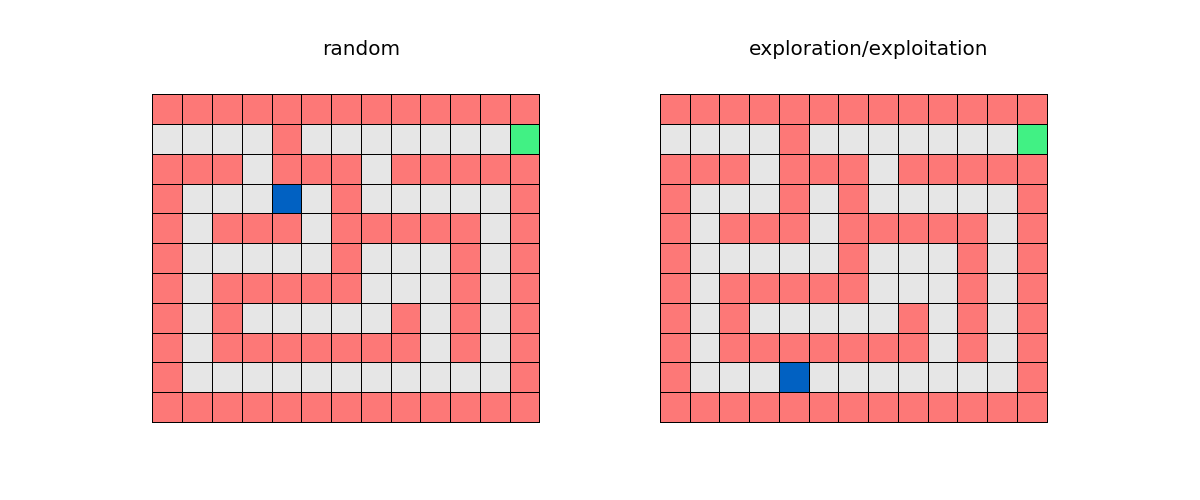
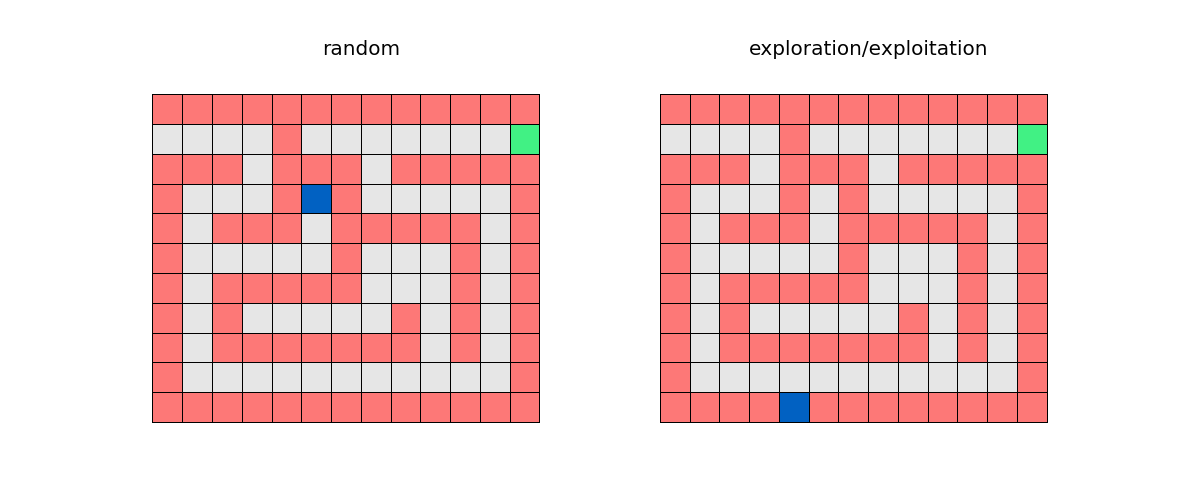
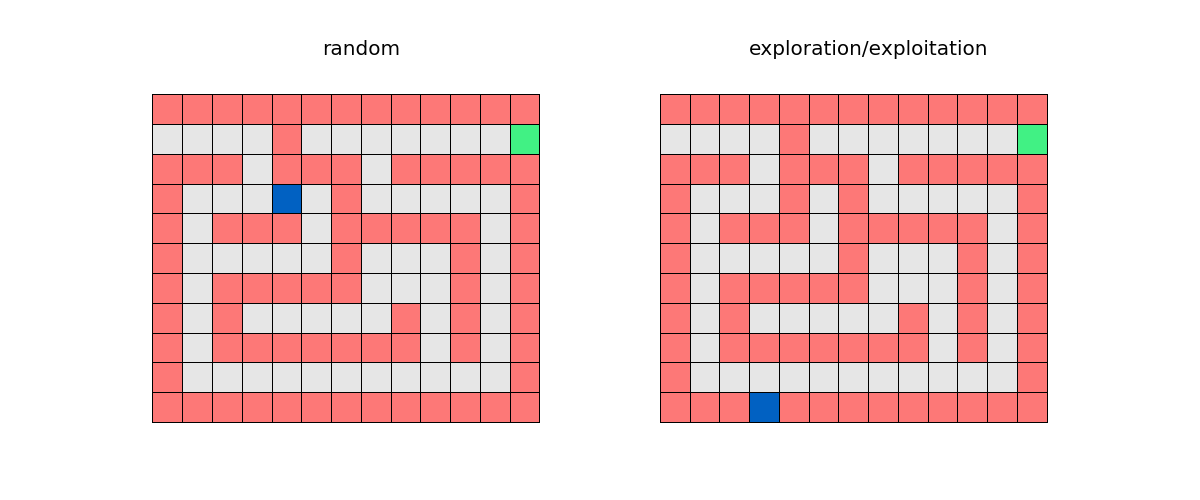
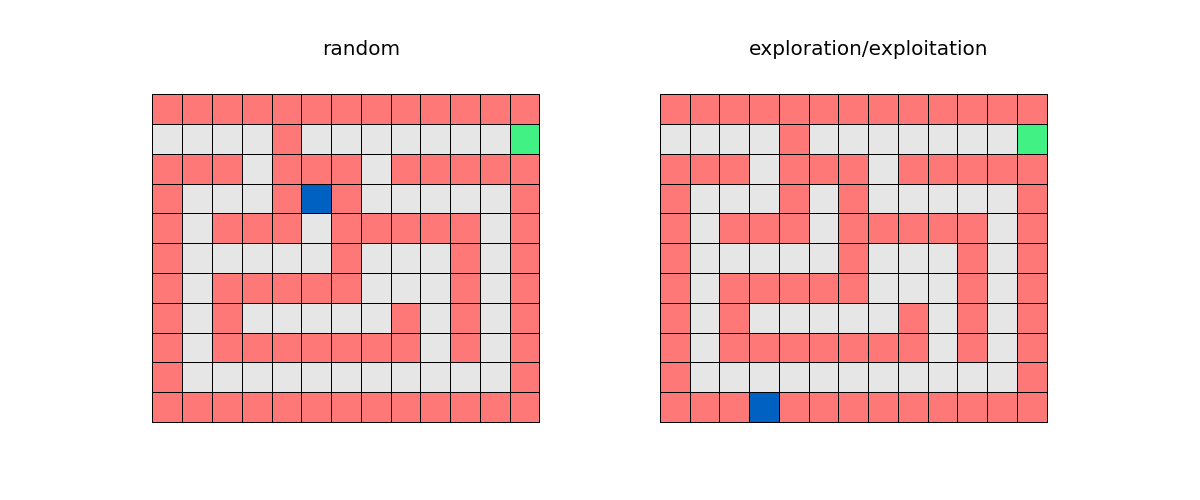
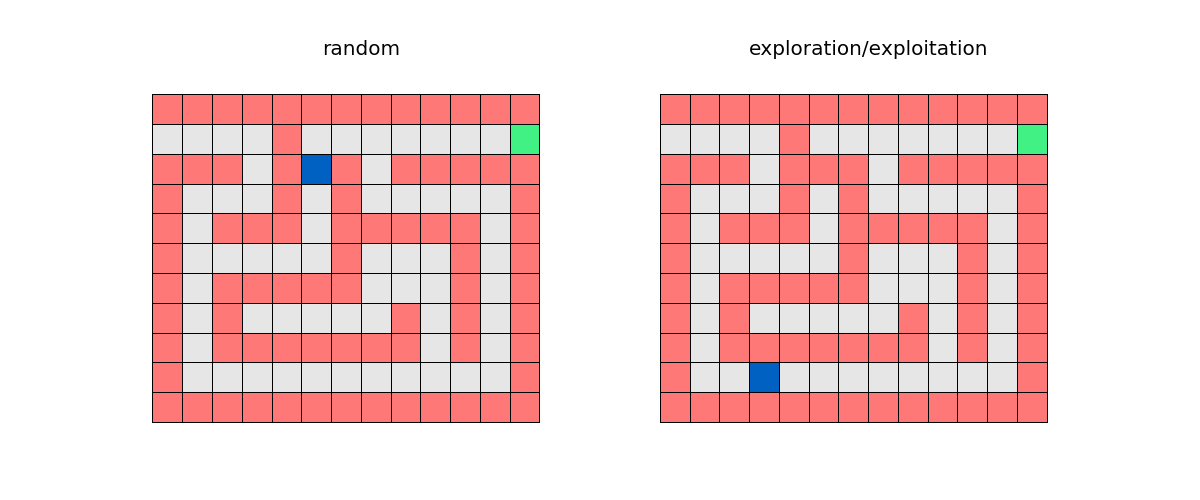
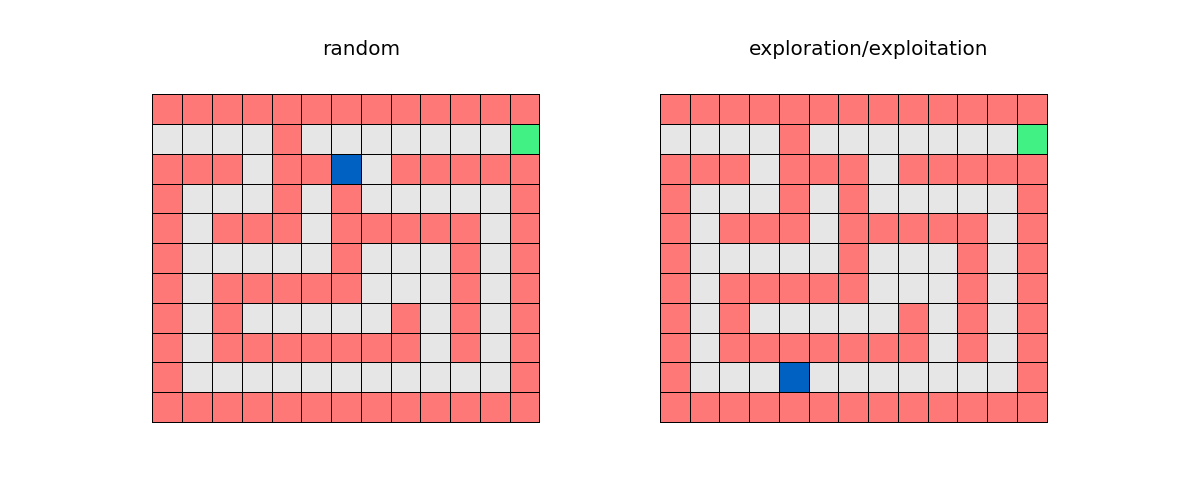
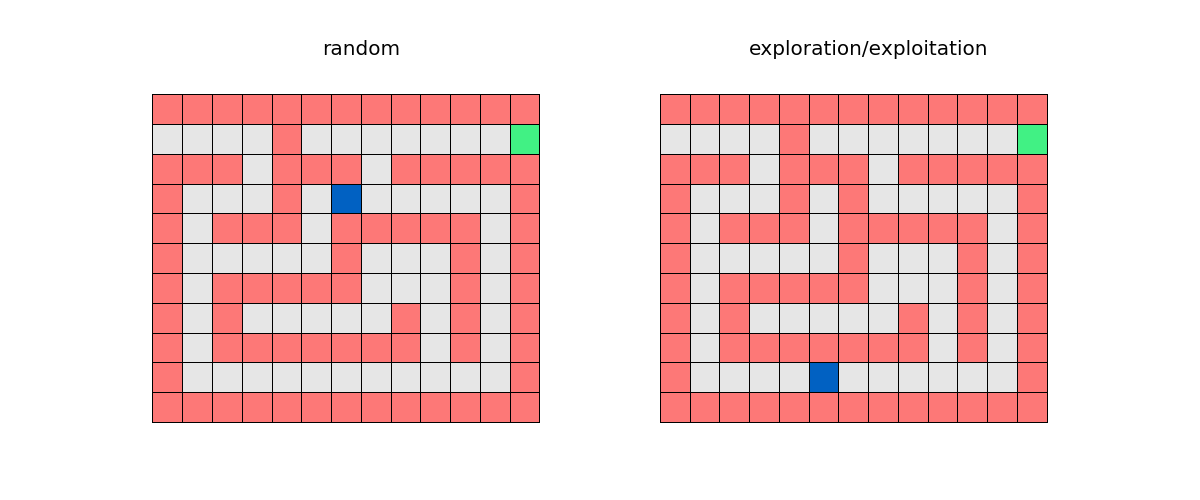
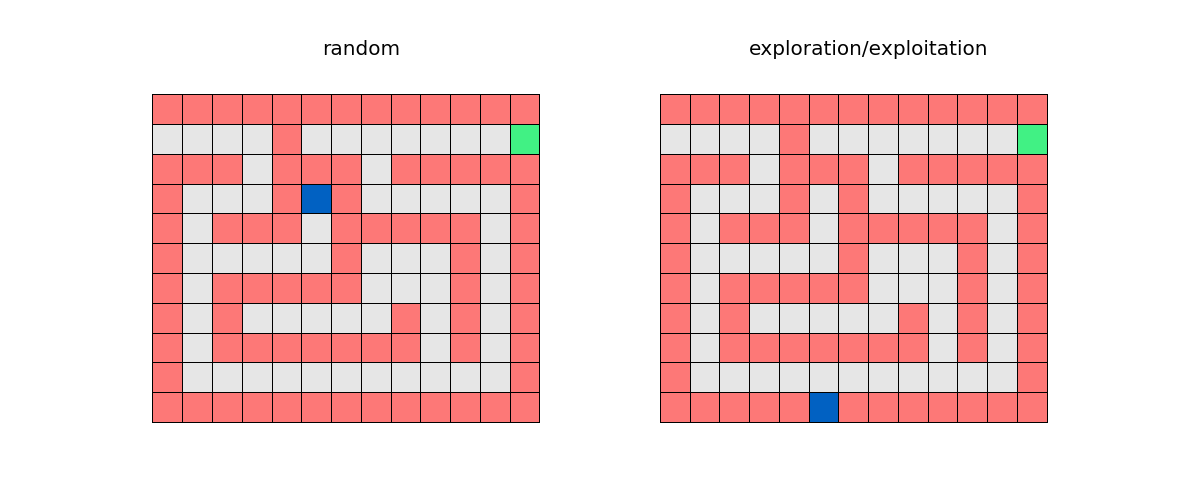
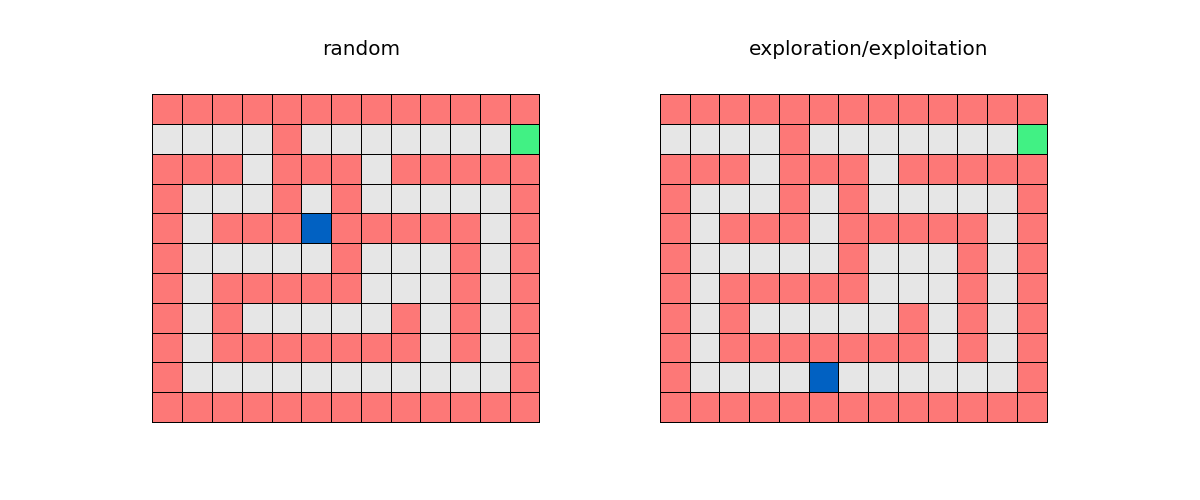
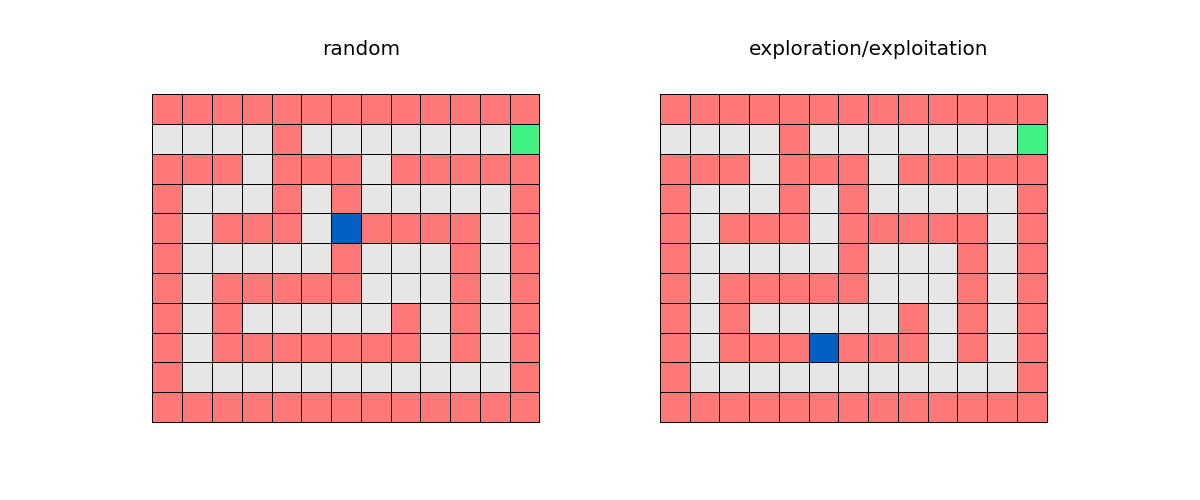
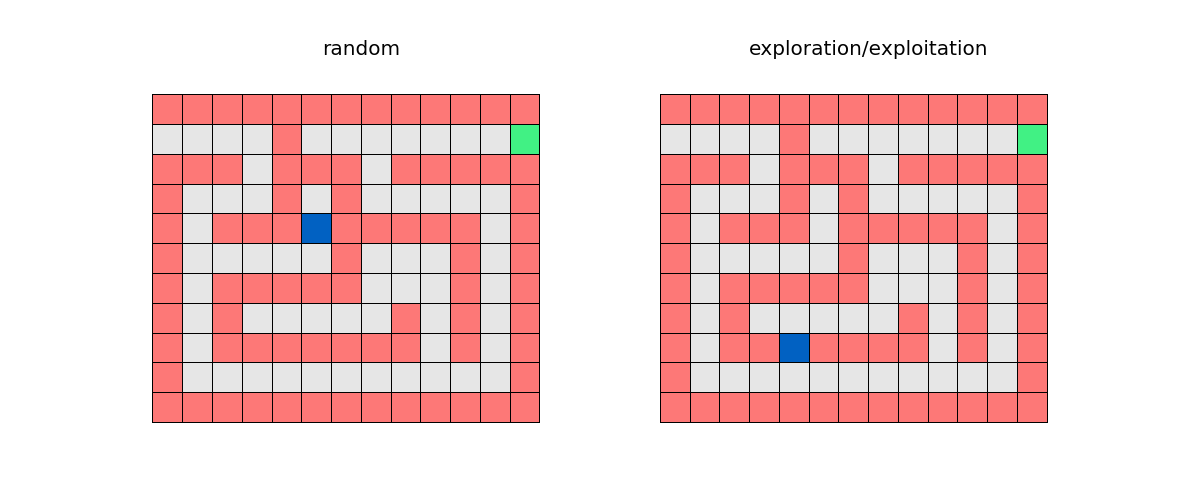
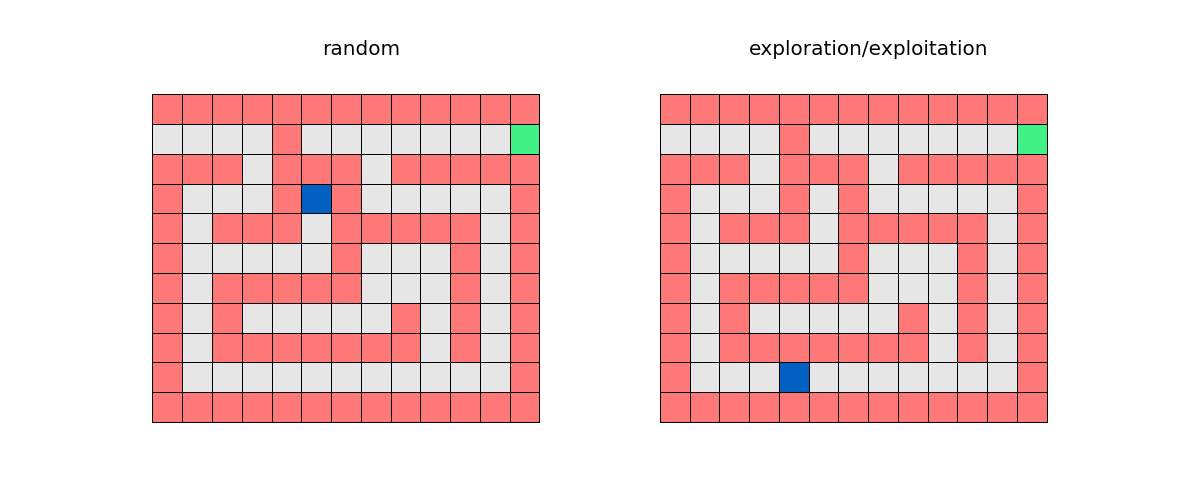
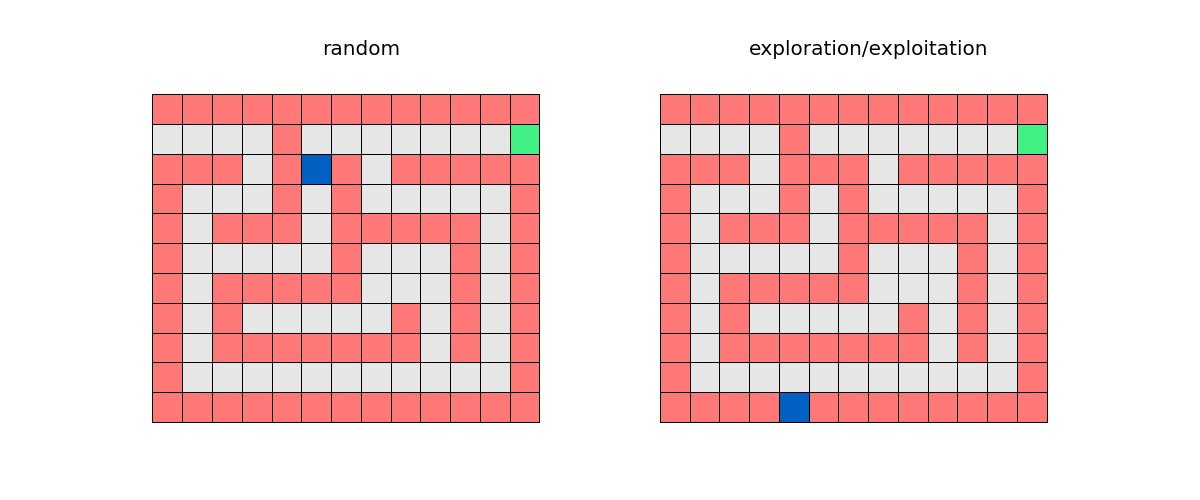
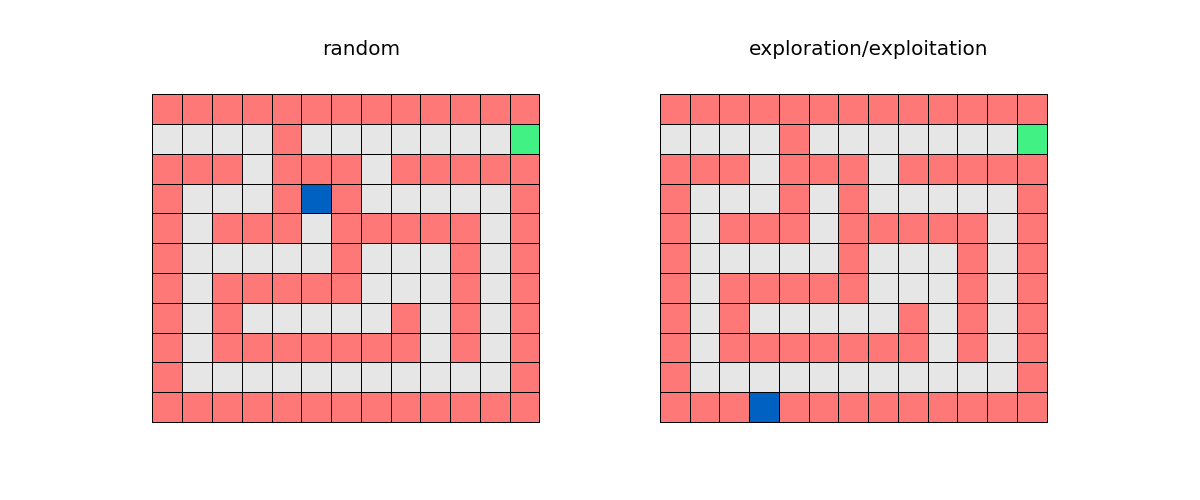
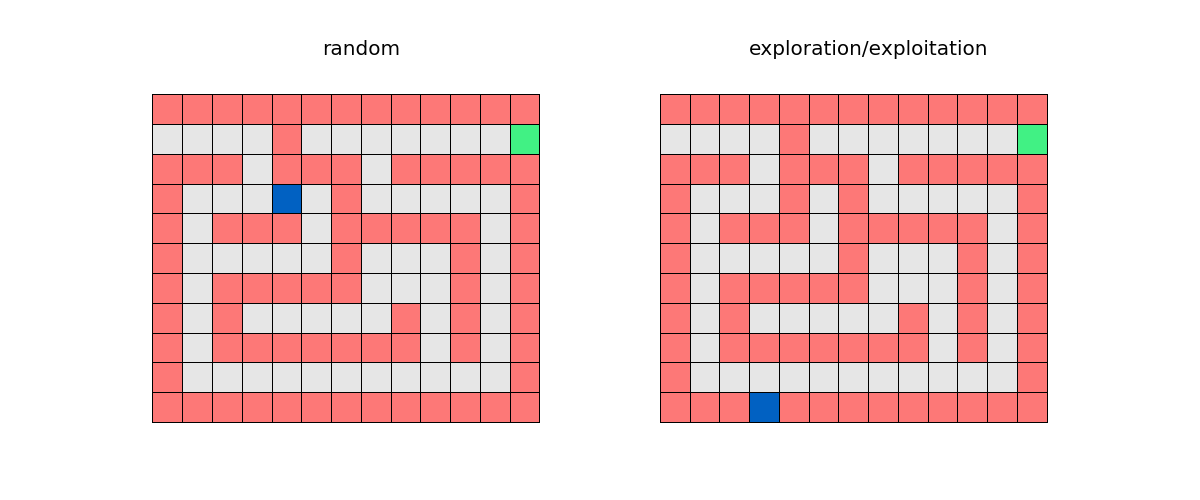
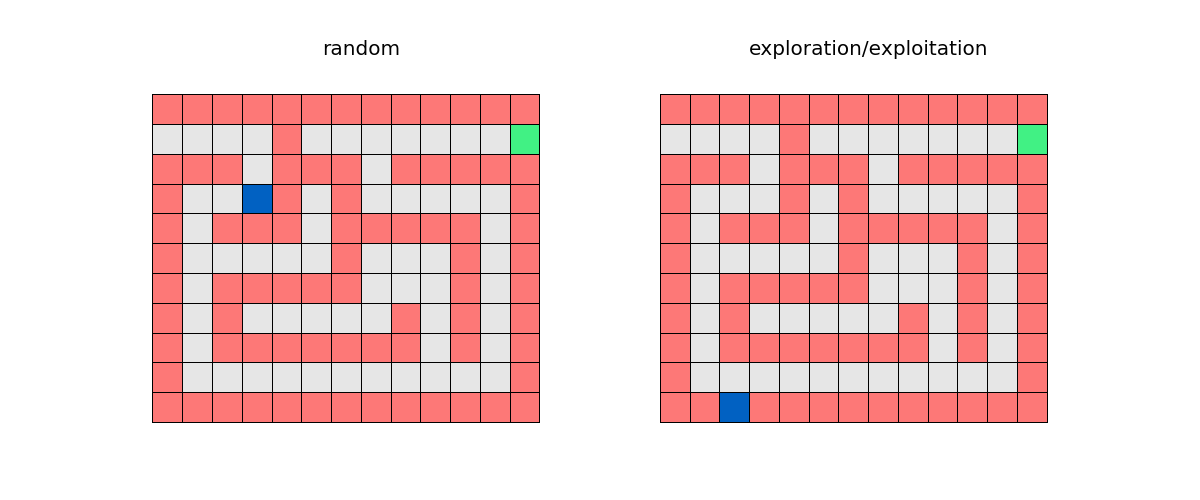
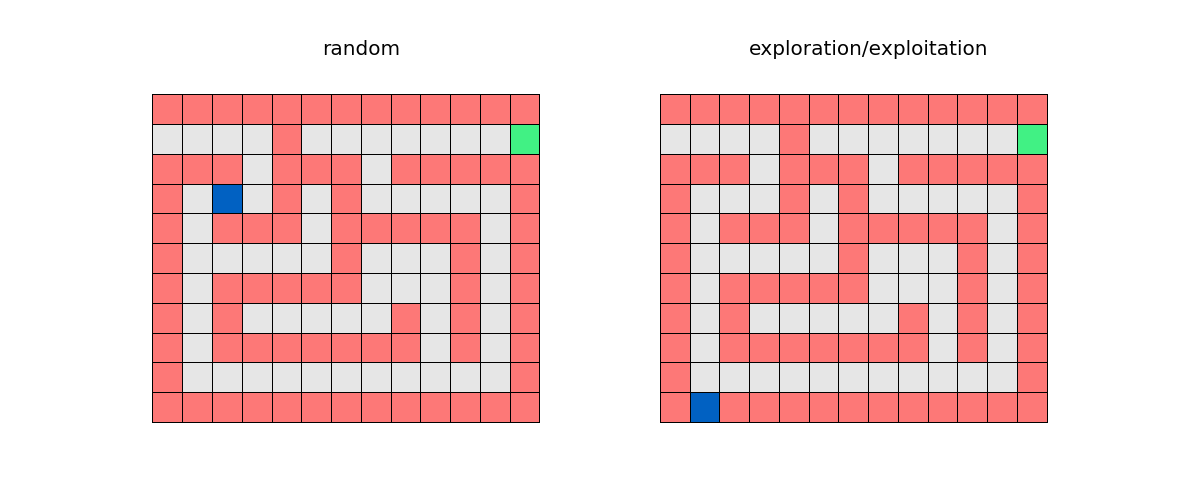
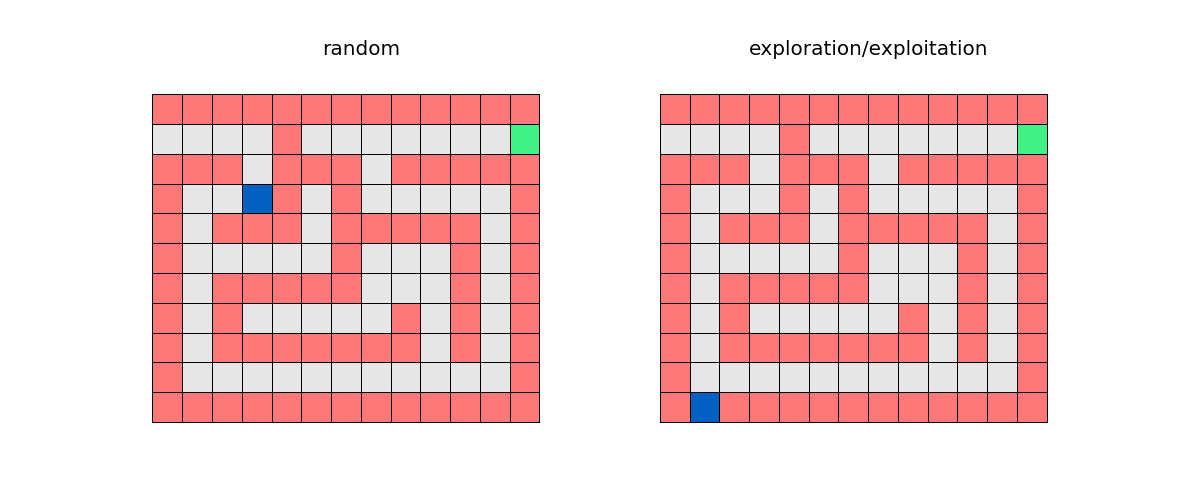
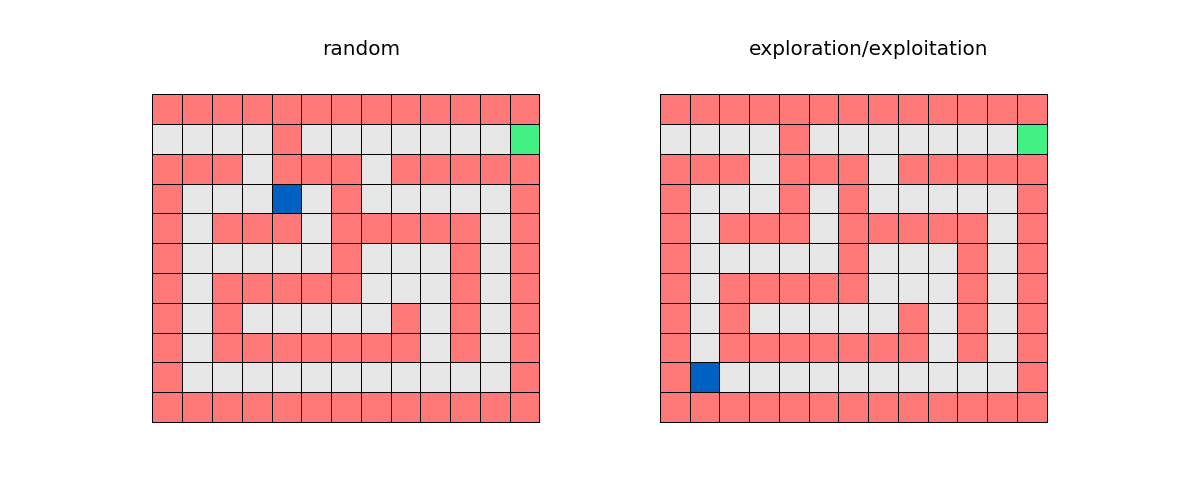
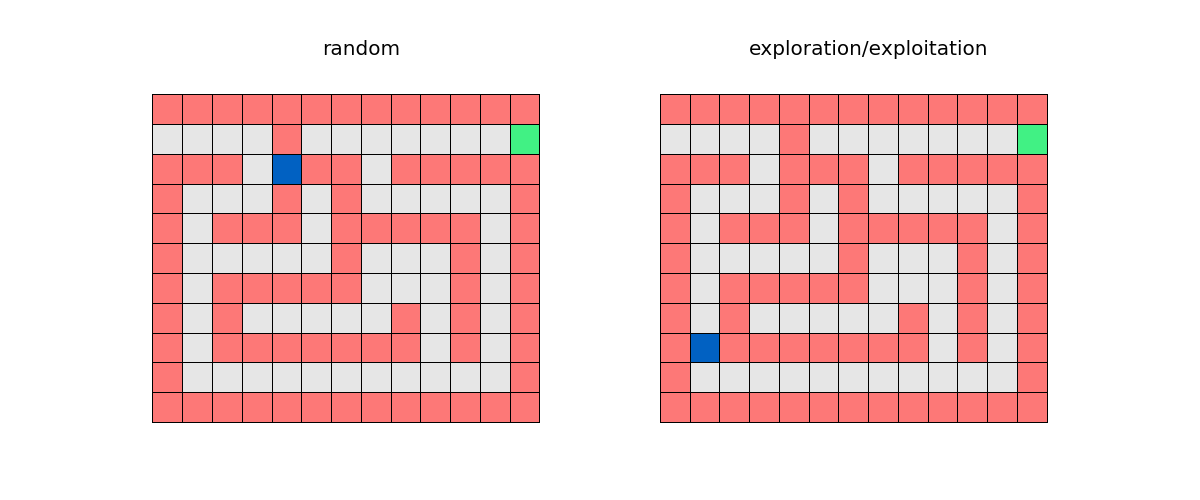
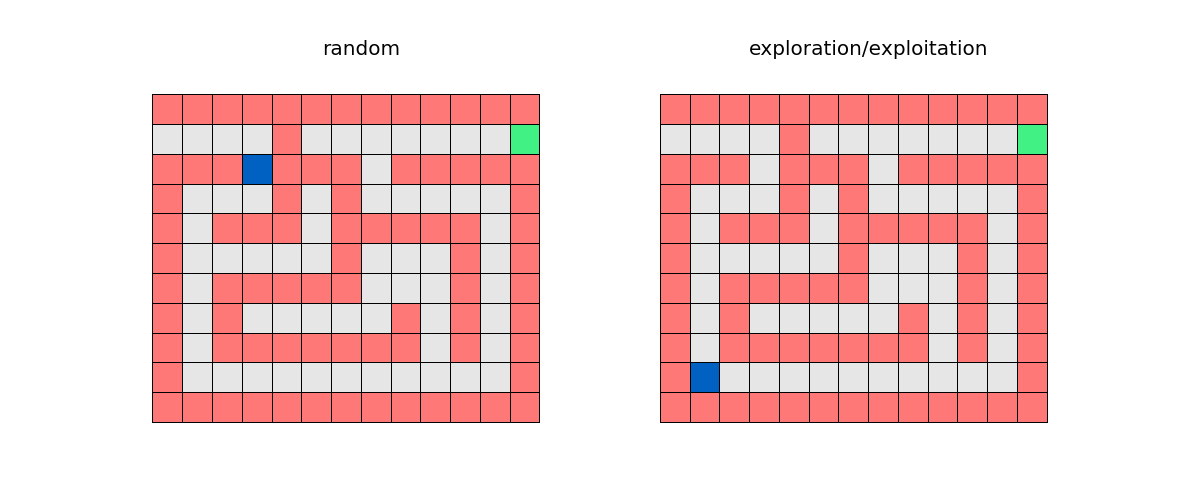
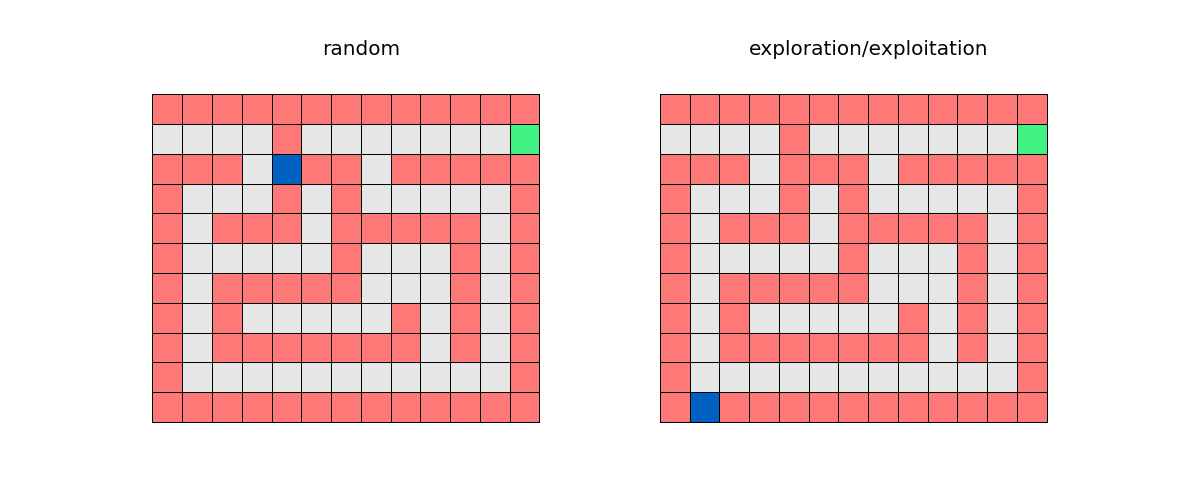
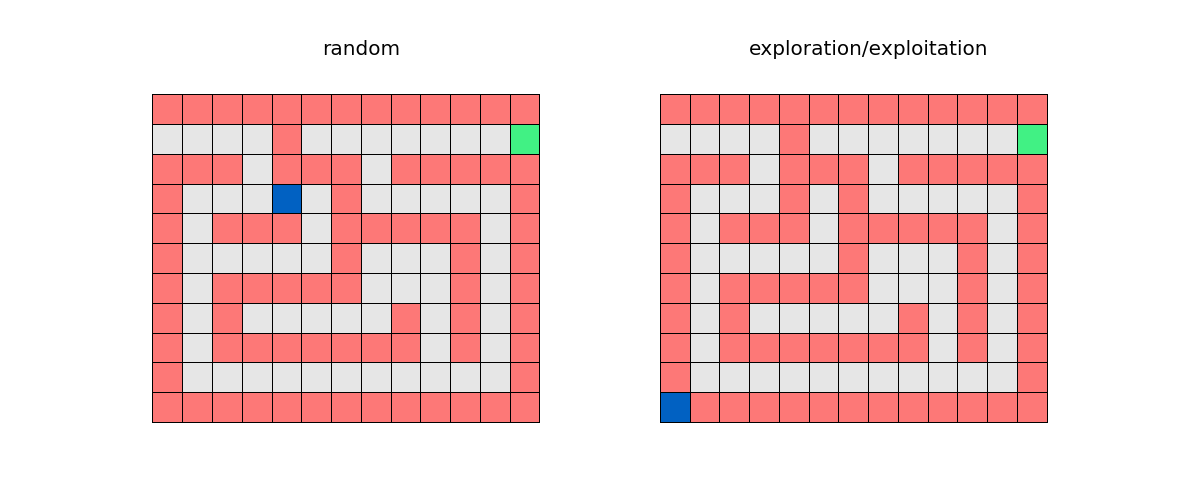
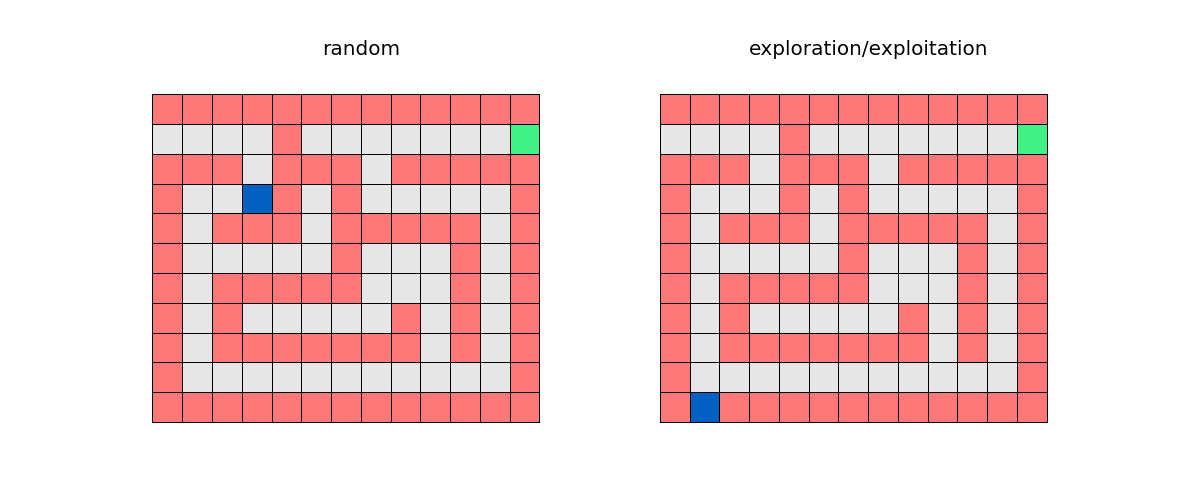
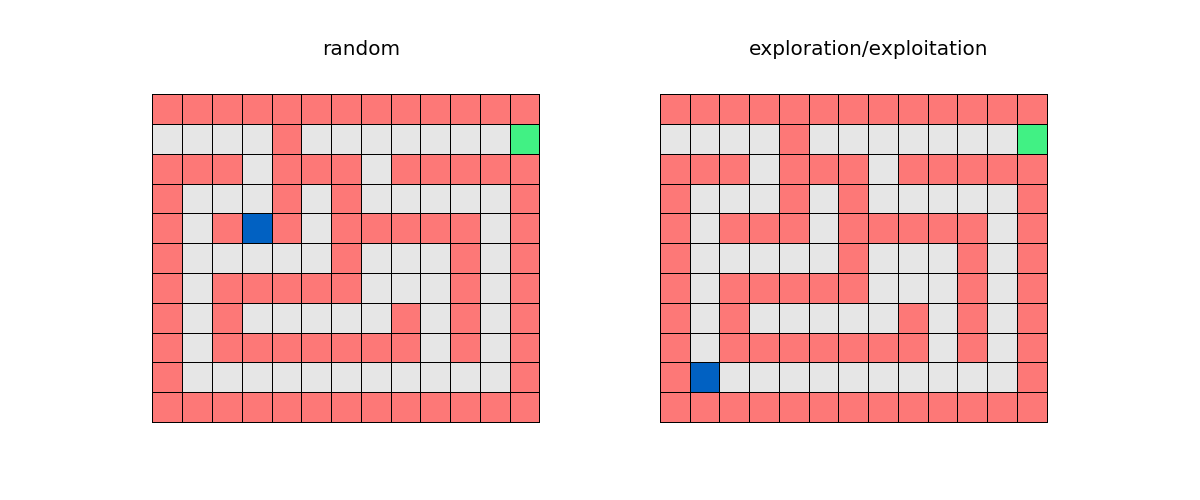
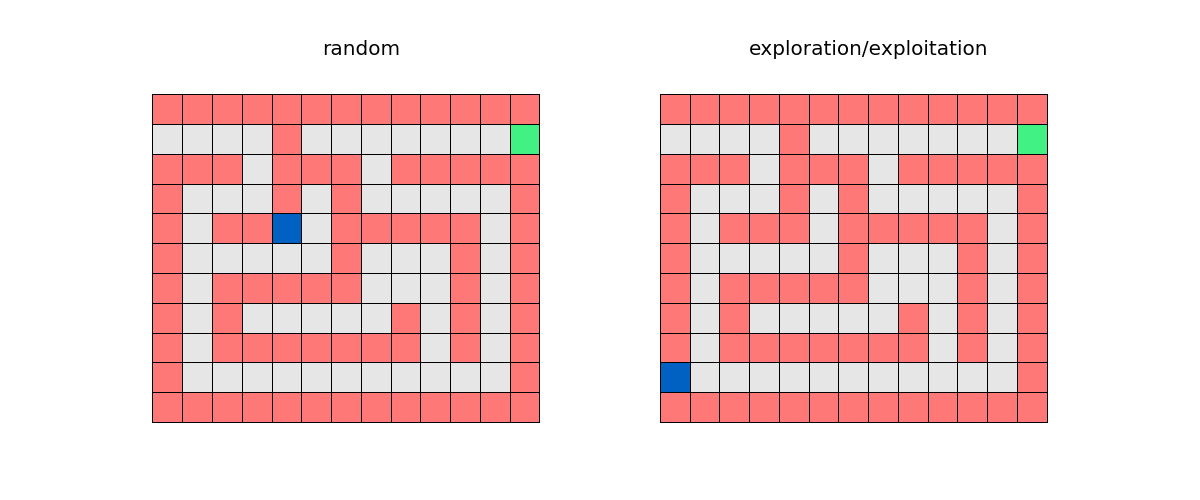
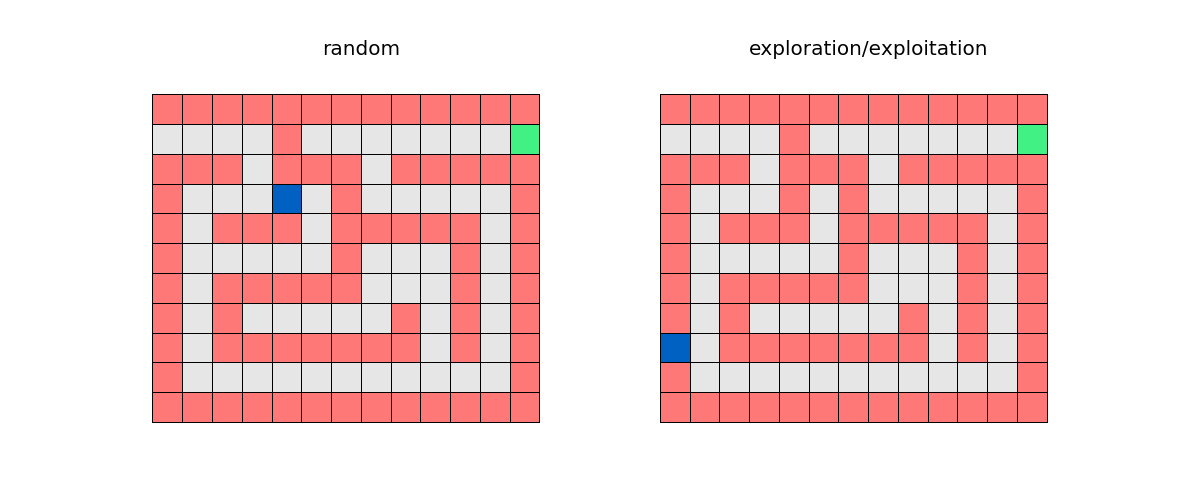
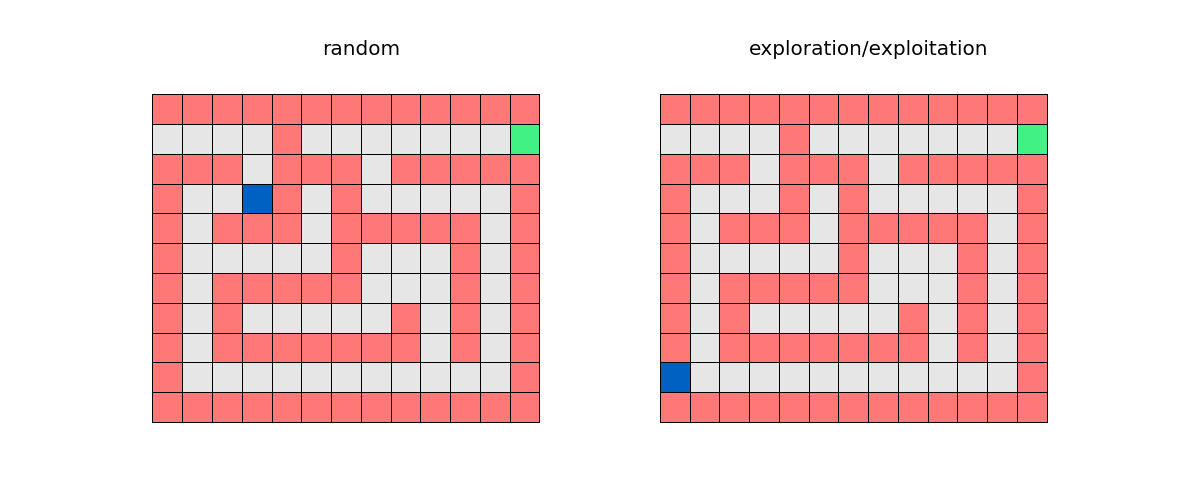
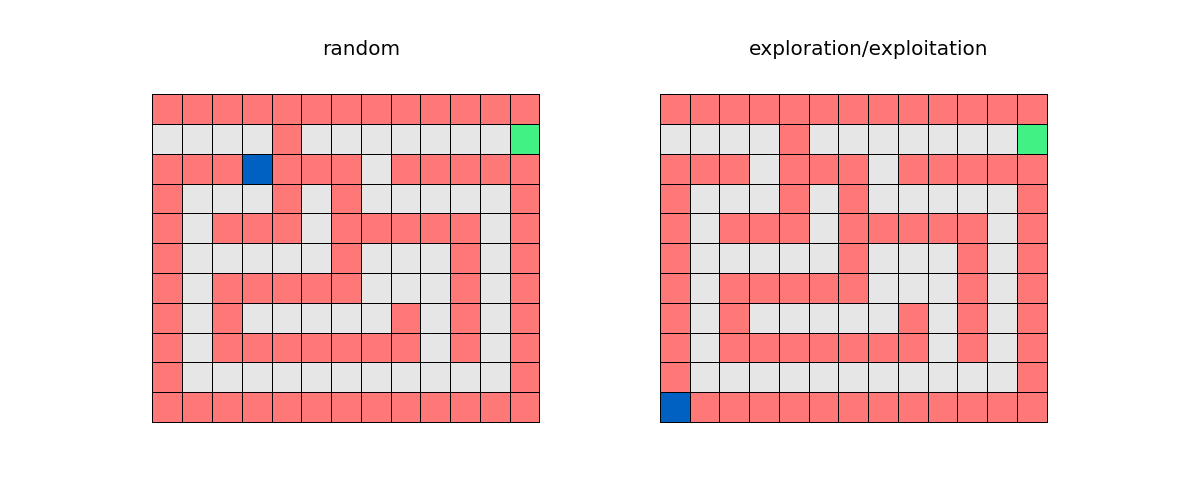
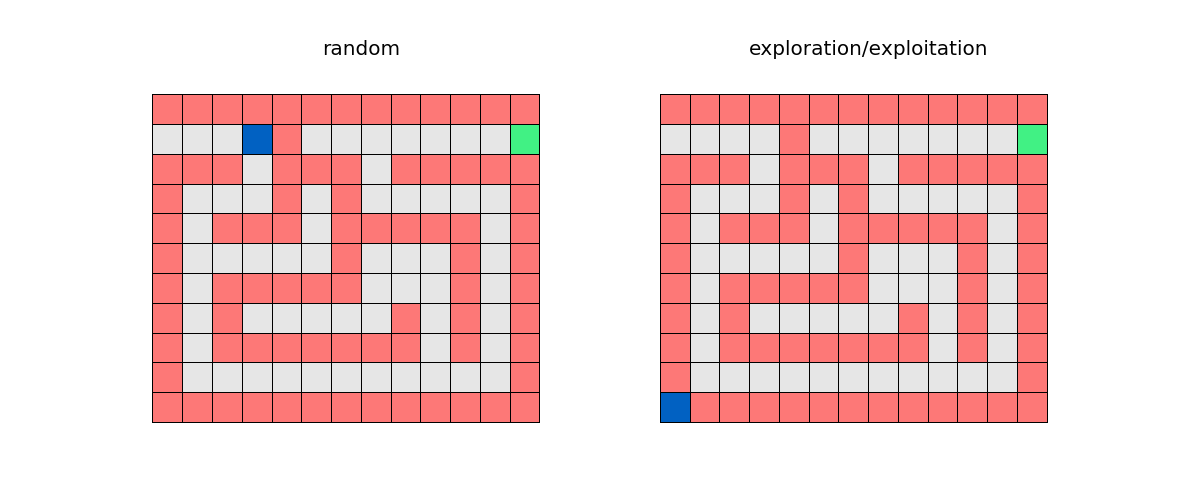
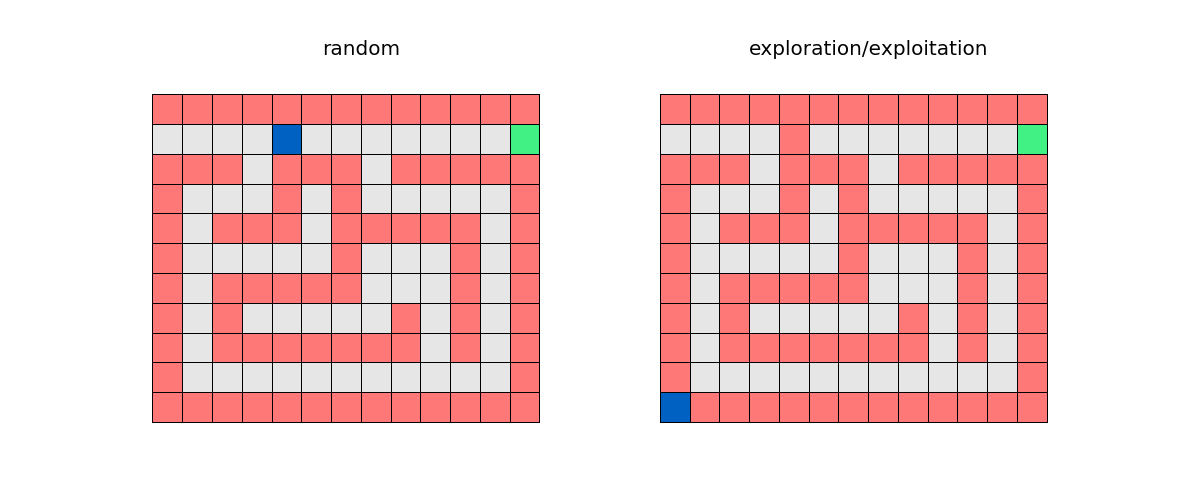
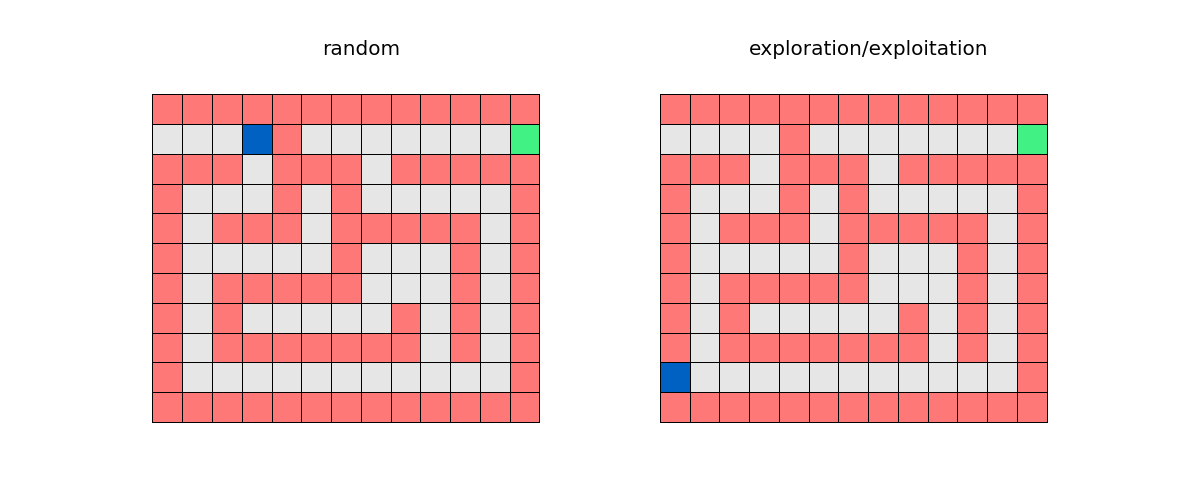
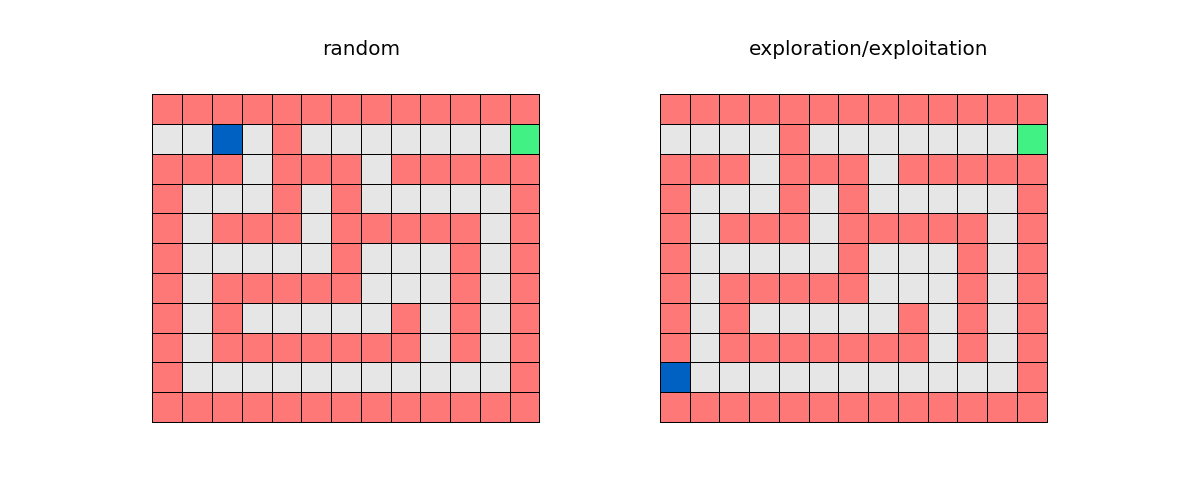
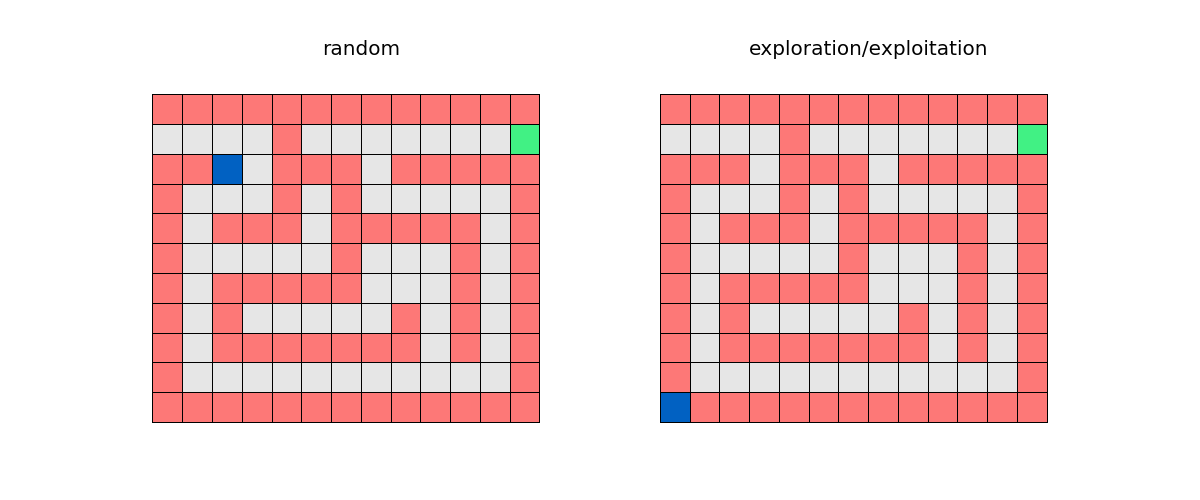
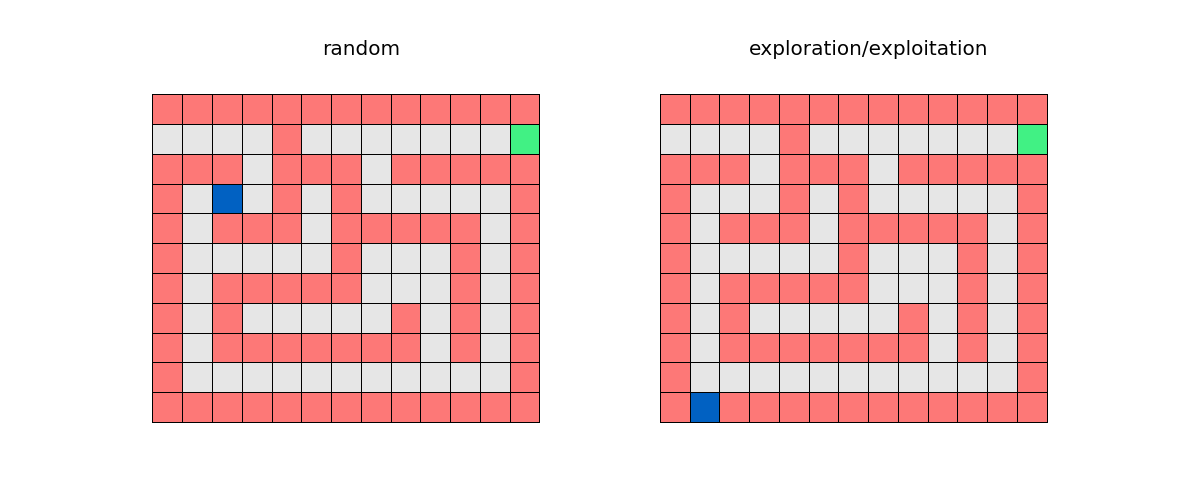
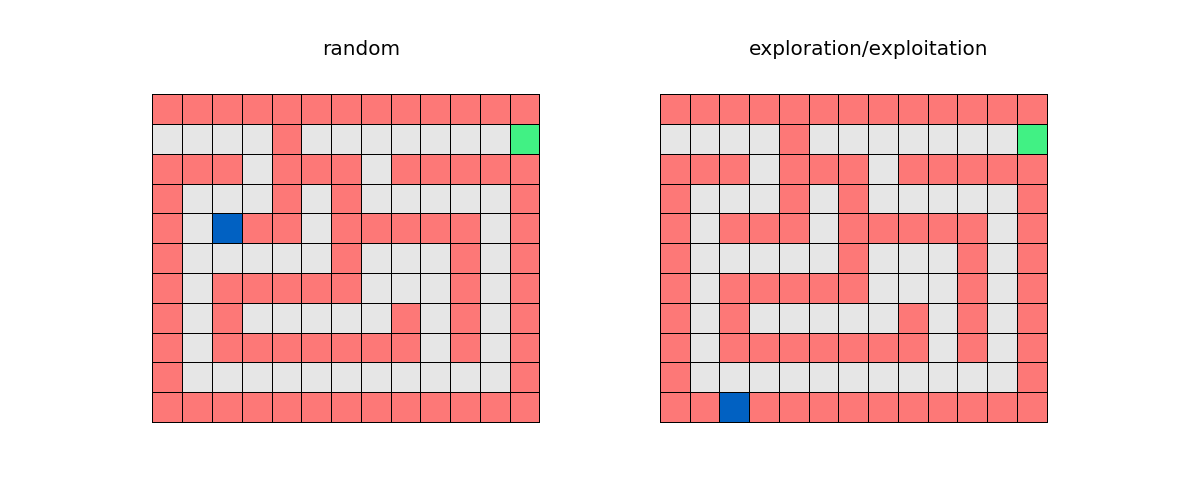
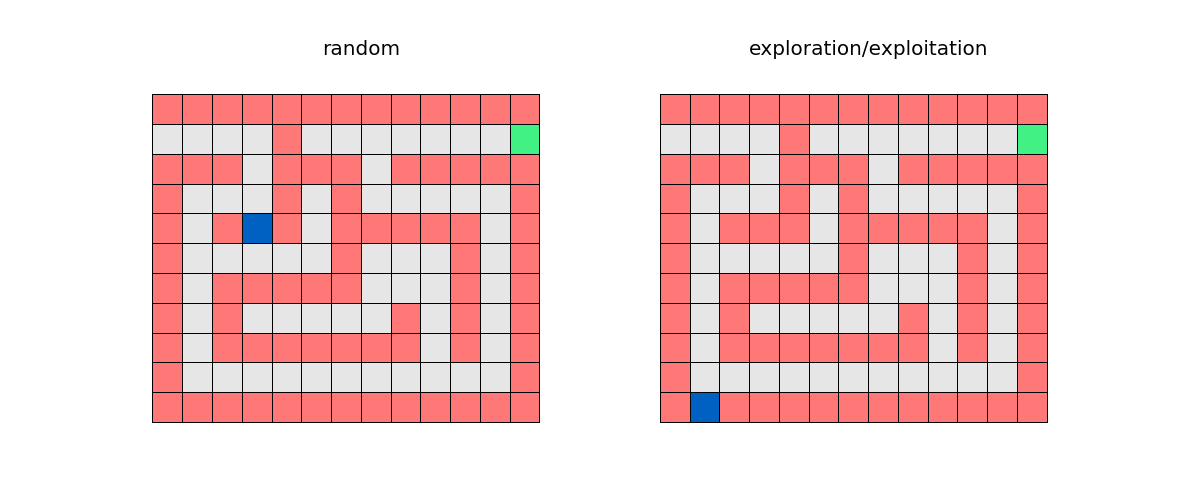
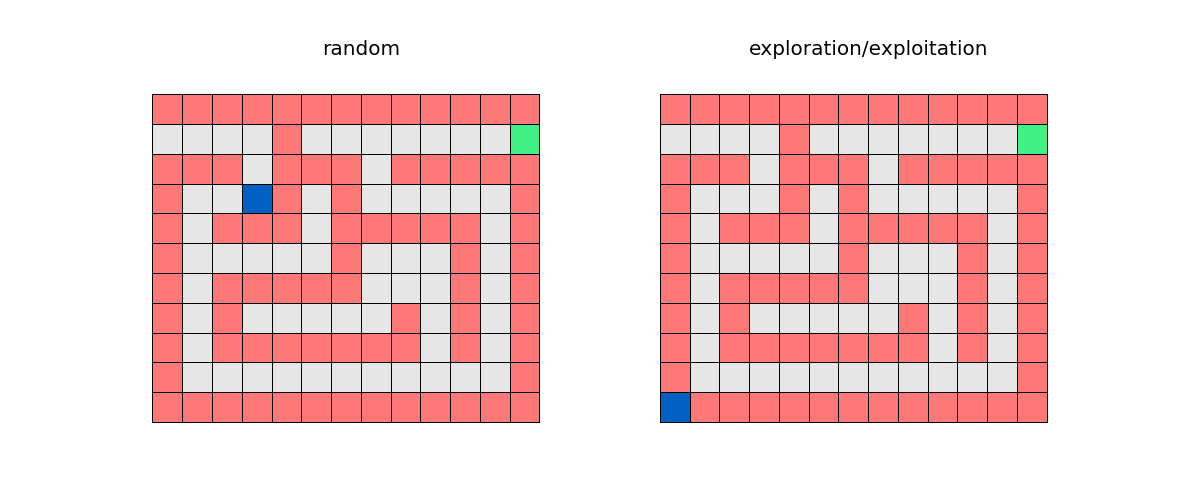
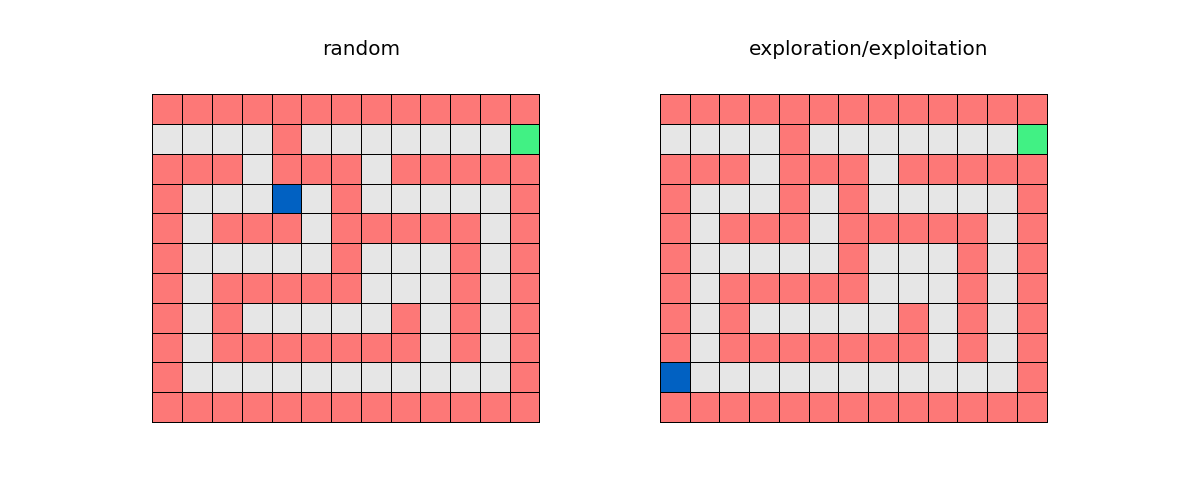
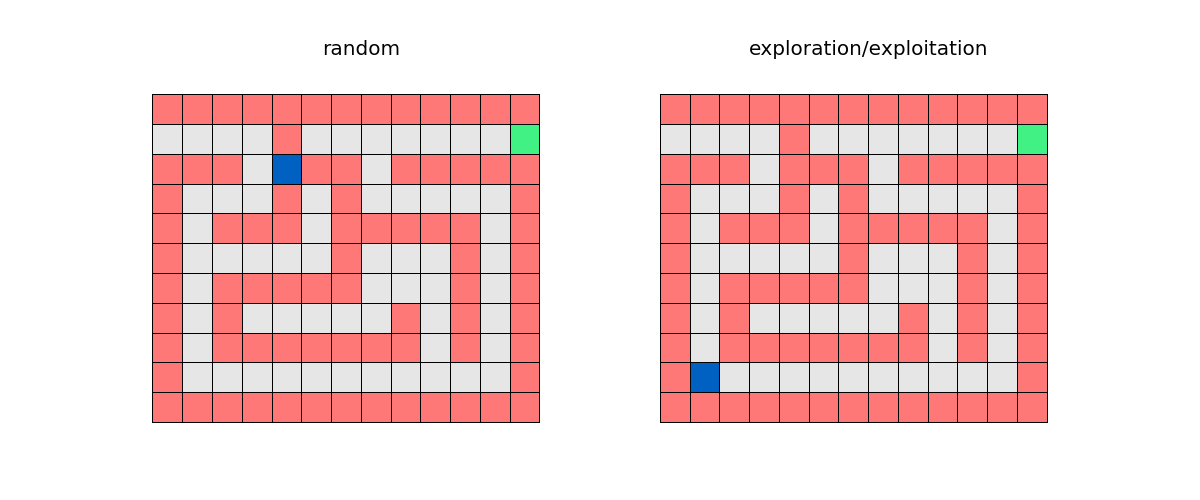
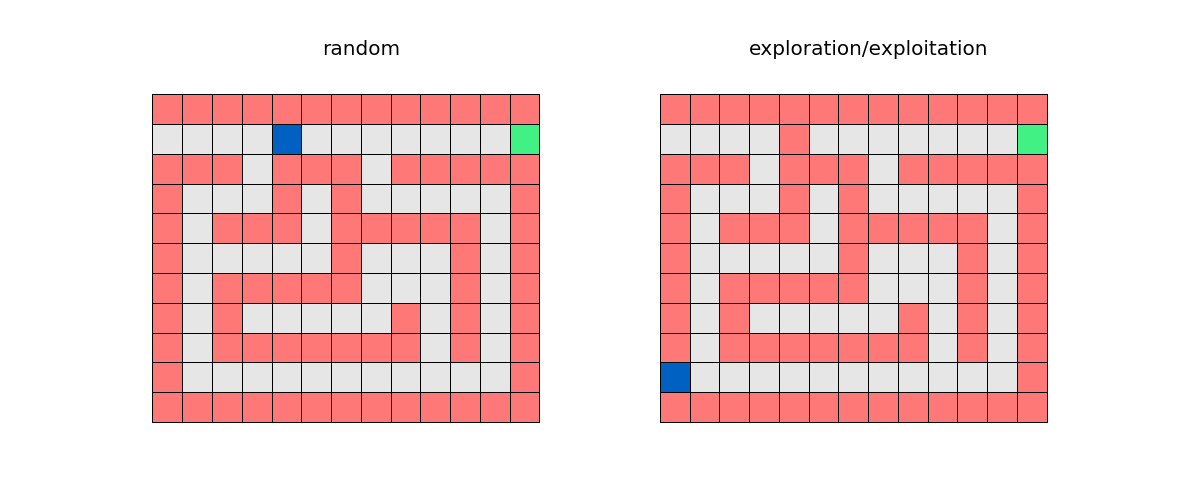
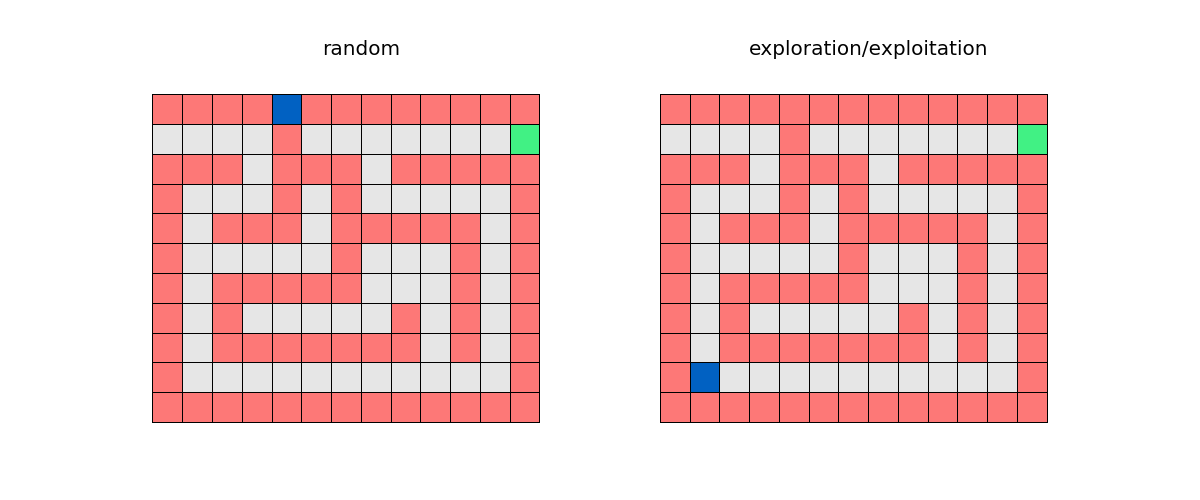
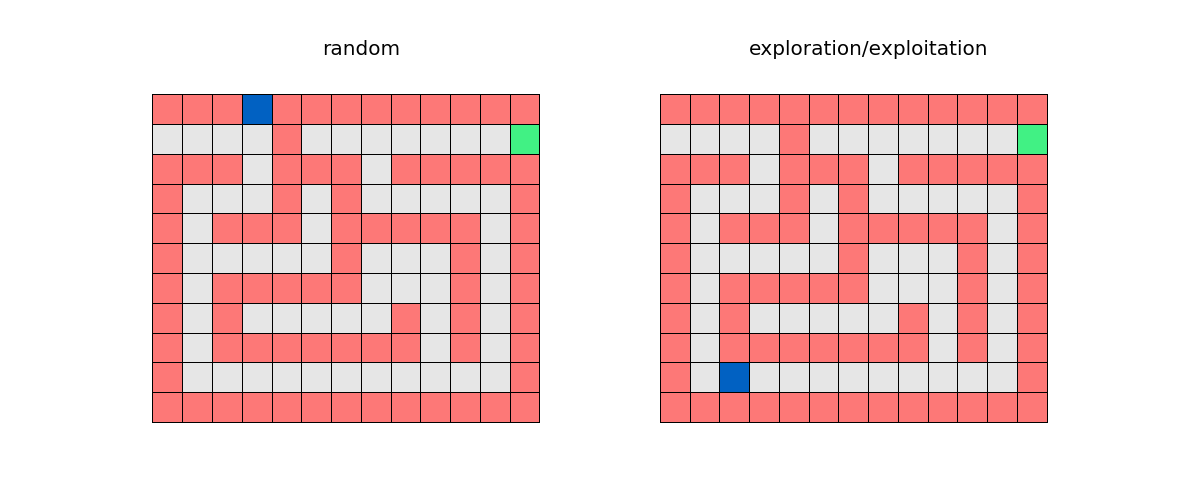
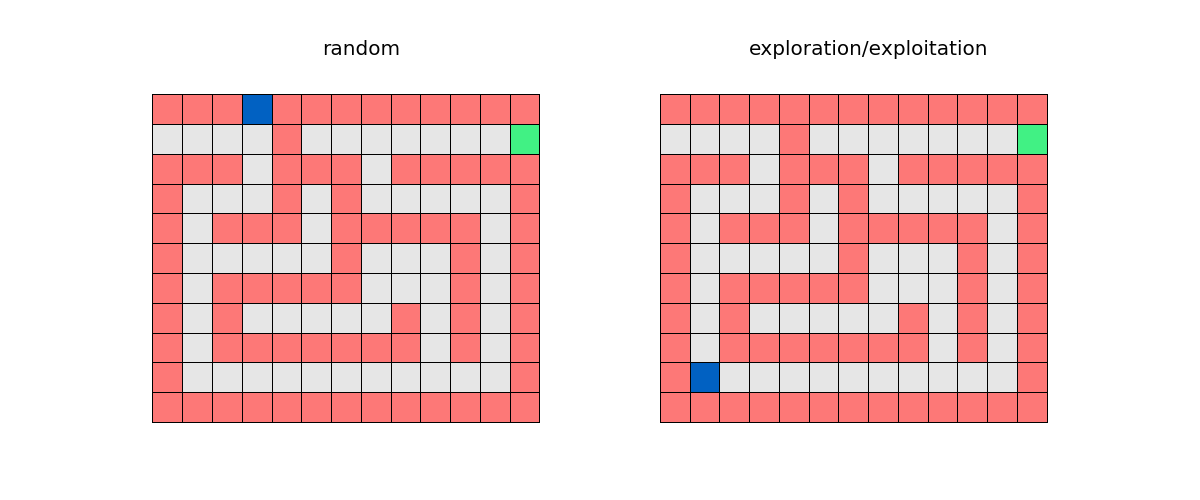
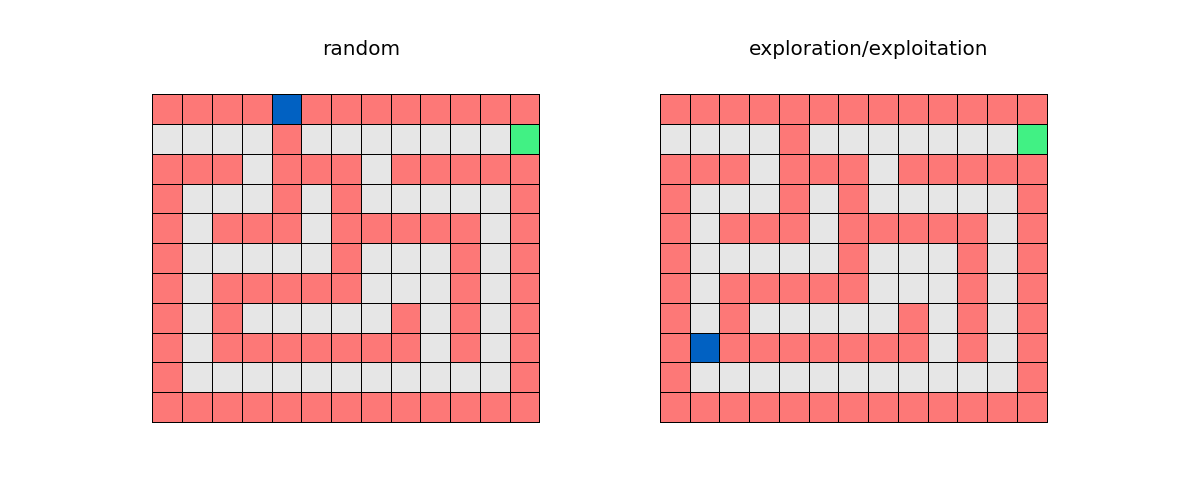
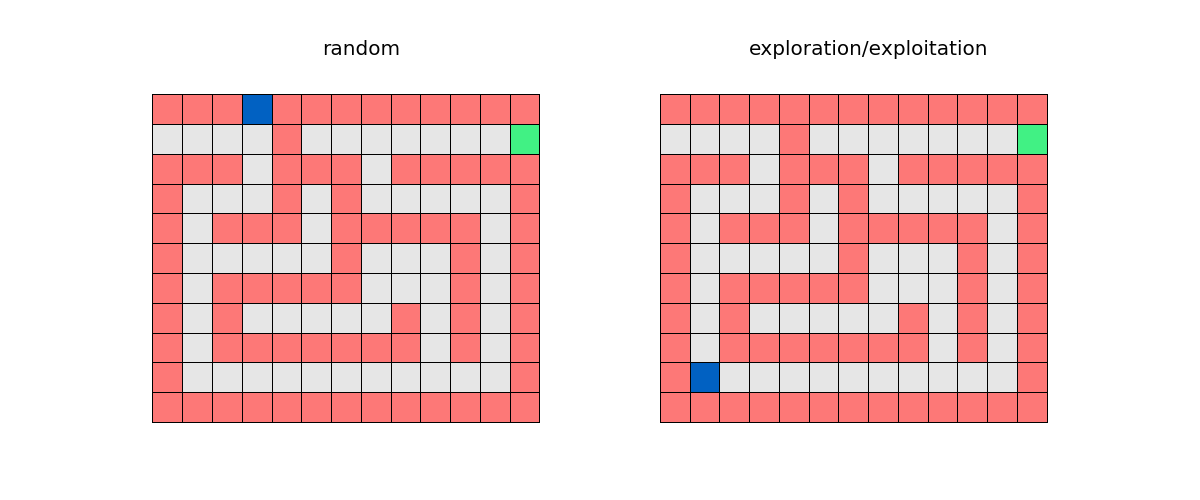
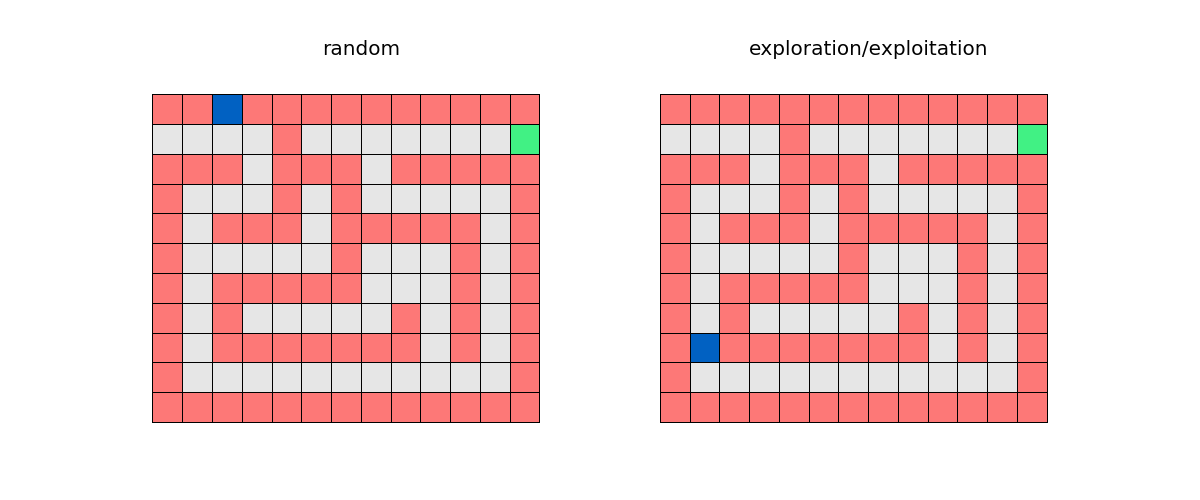
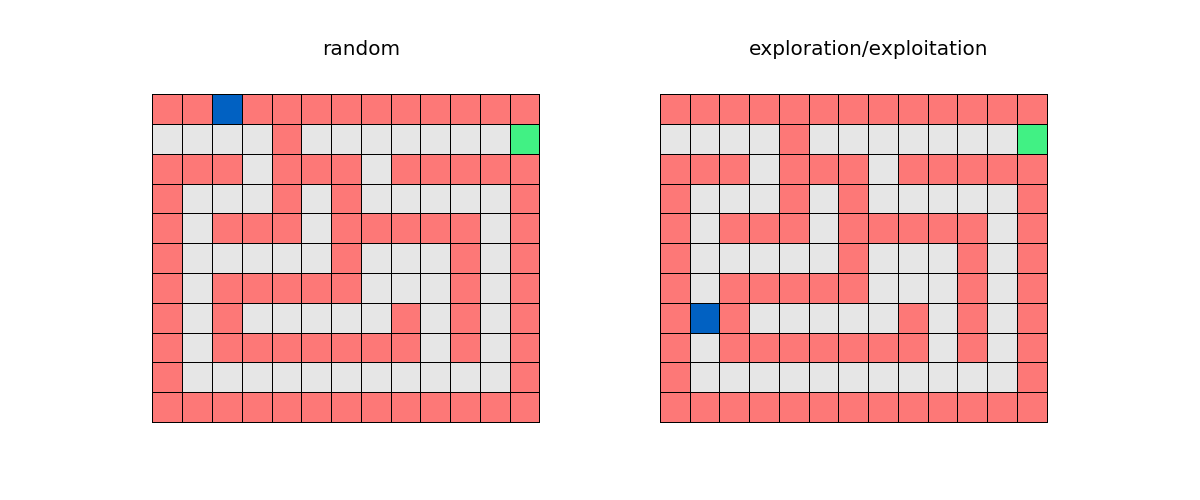
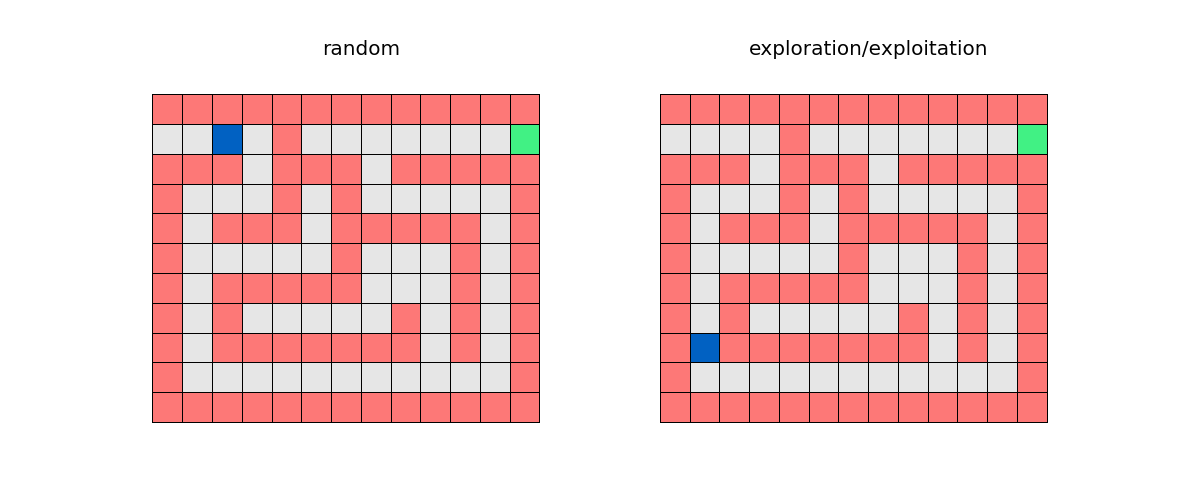
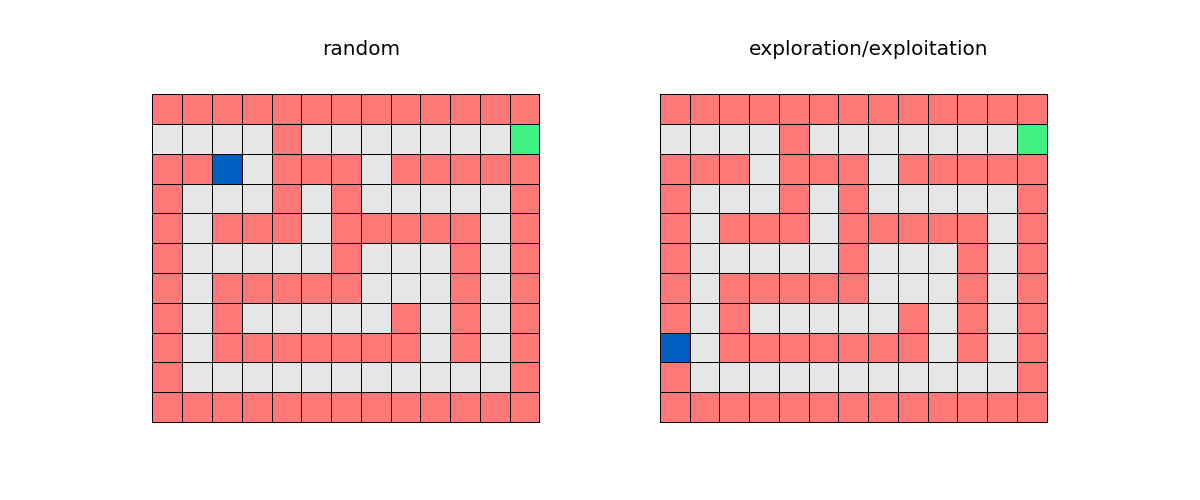

In [4]:
# load in Gridworld animation module
from gridworld_lib import gridworld_animators

# create instance of animator
animator = gridworld_animators.animator()

# run animator to compare action methods       
animator.animate_training_comparison(gridworld = small_maze,learner_1 = random_qlearner,learner_2 = exploit_qlearner, episode = 0)


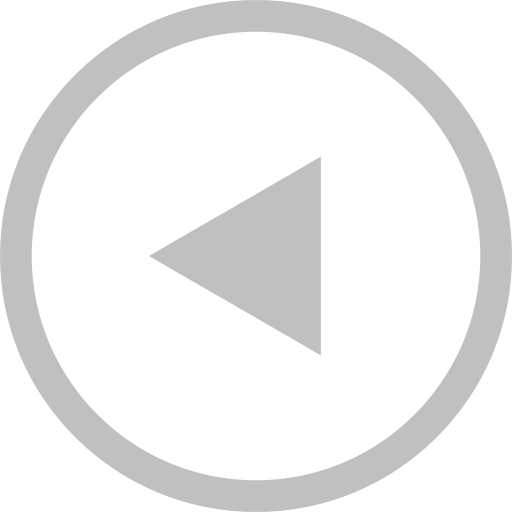
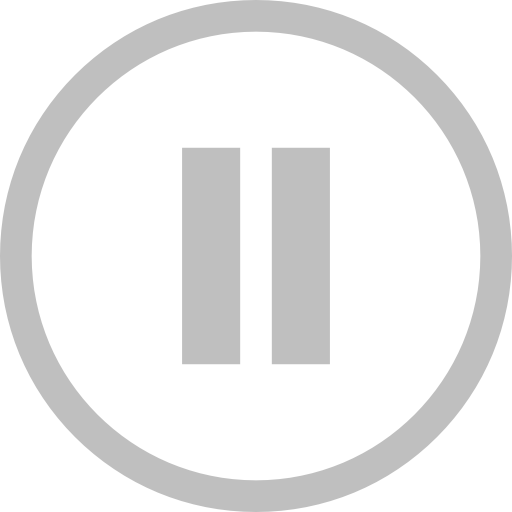
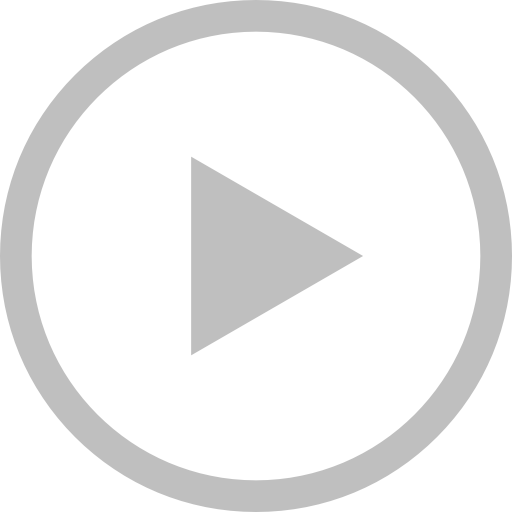
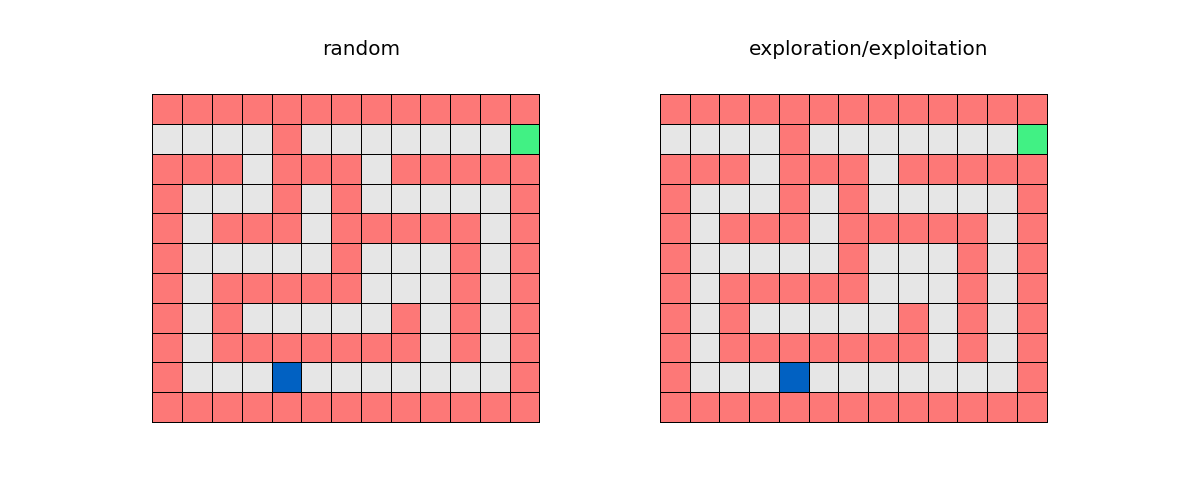
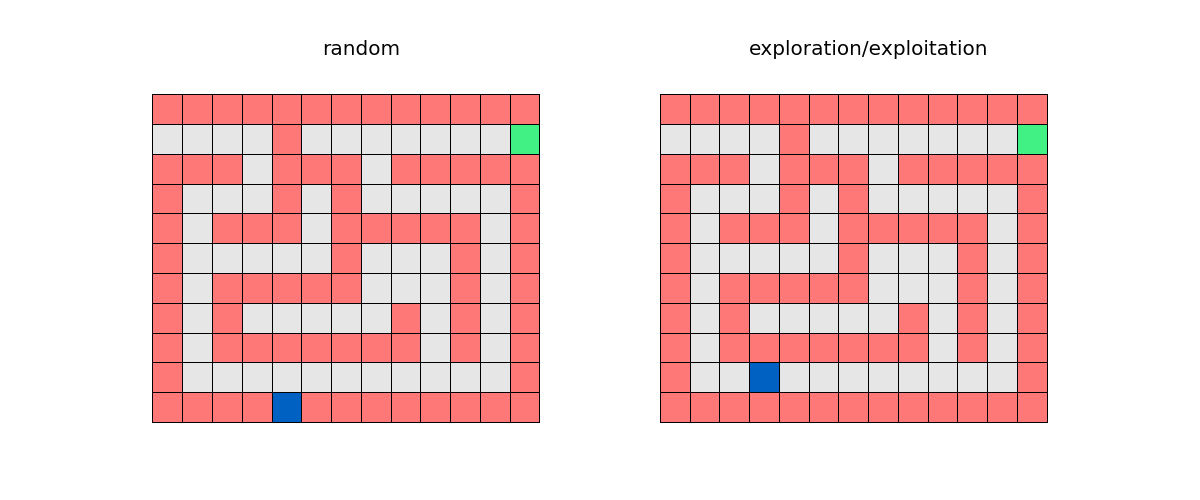
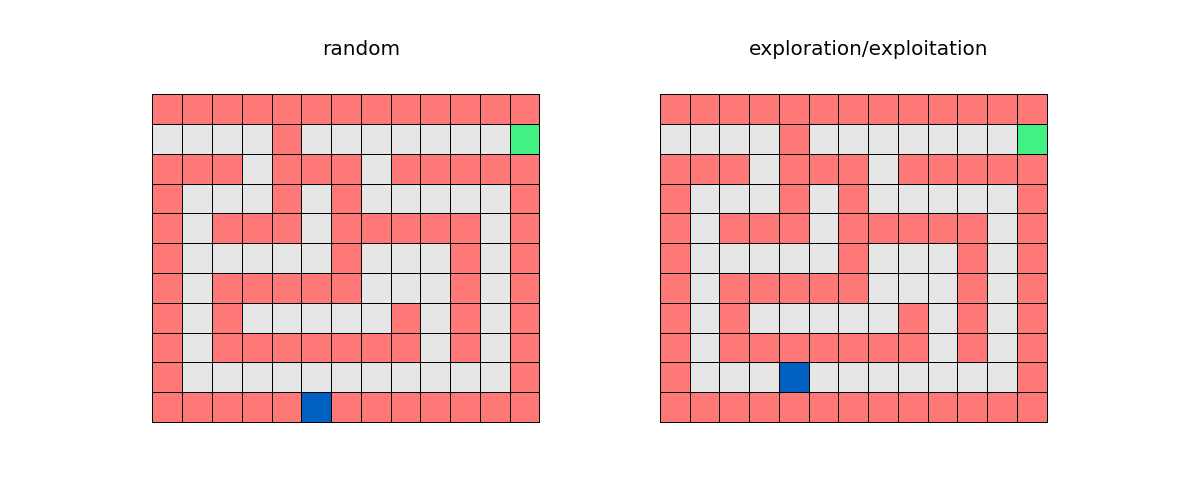
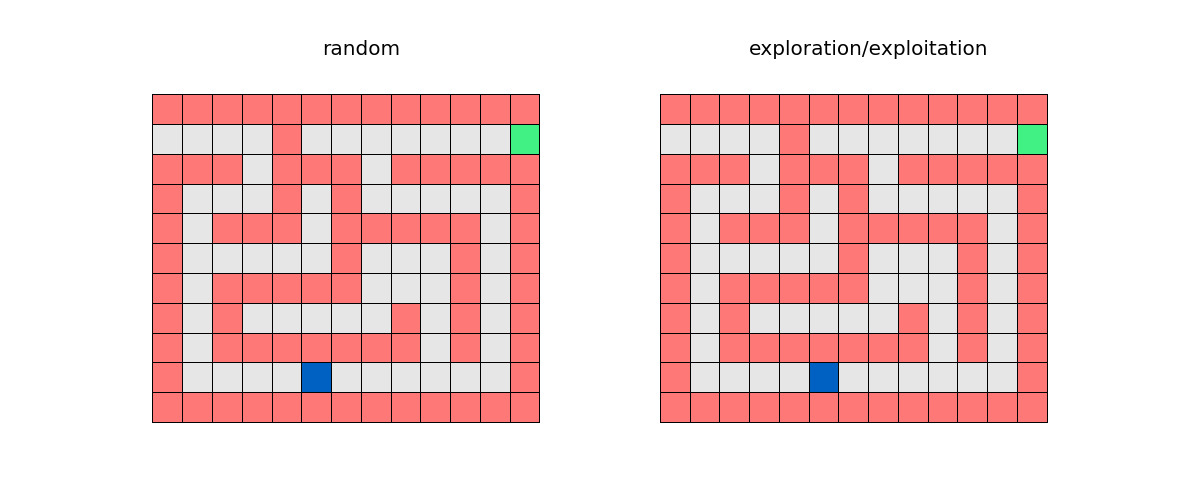
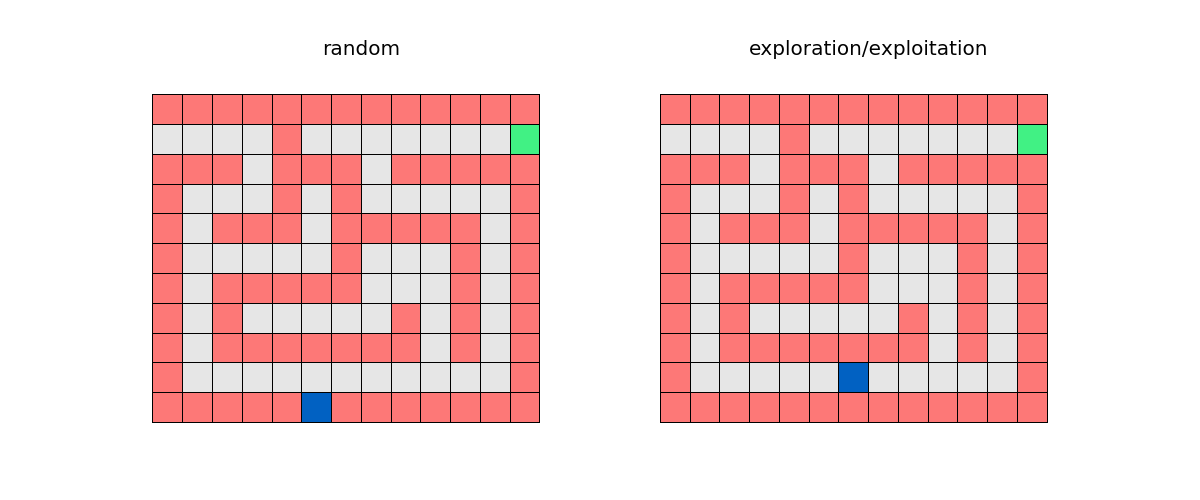
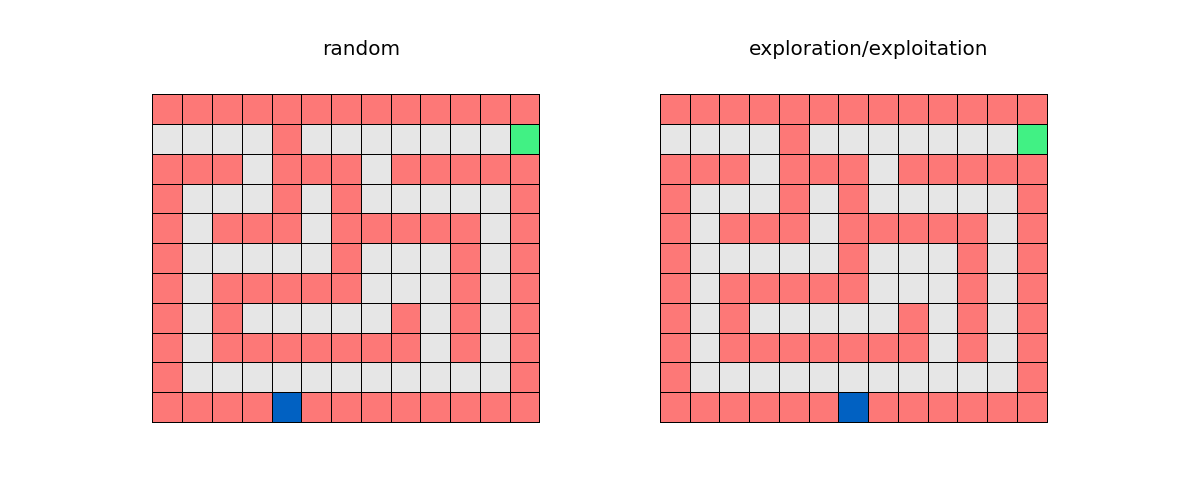
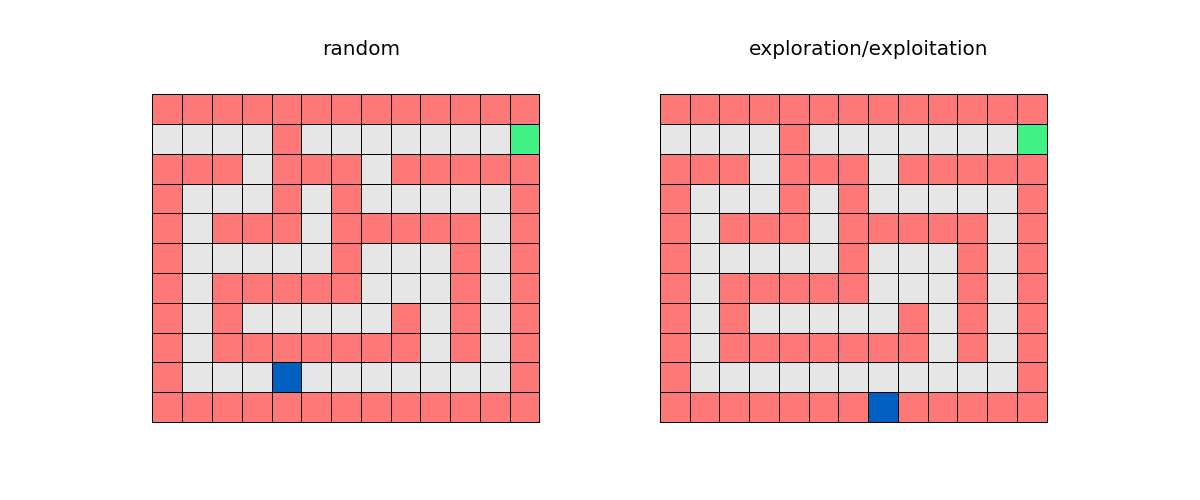
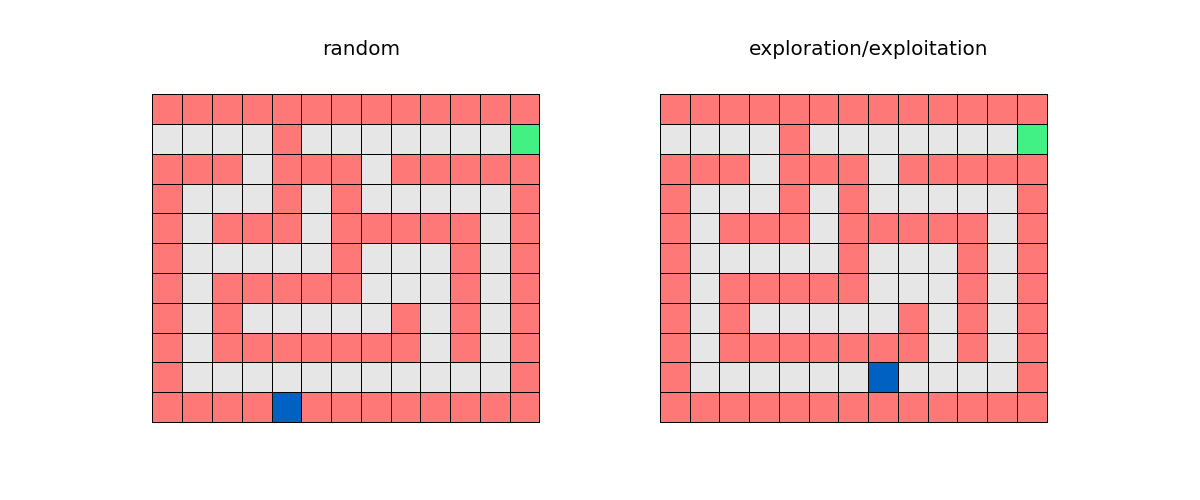
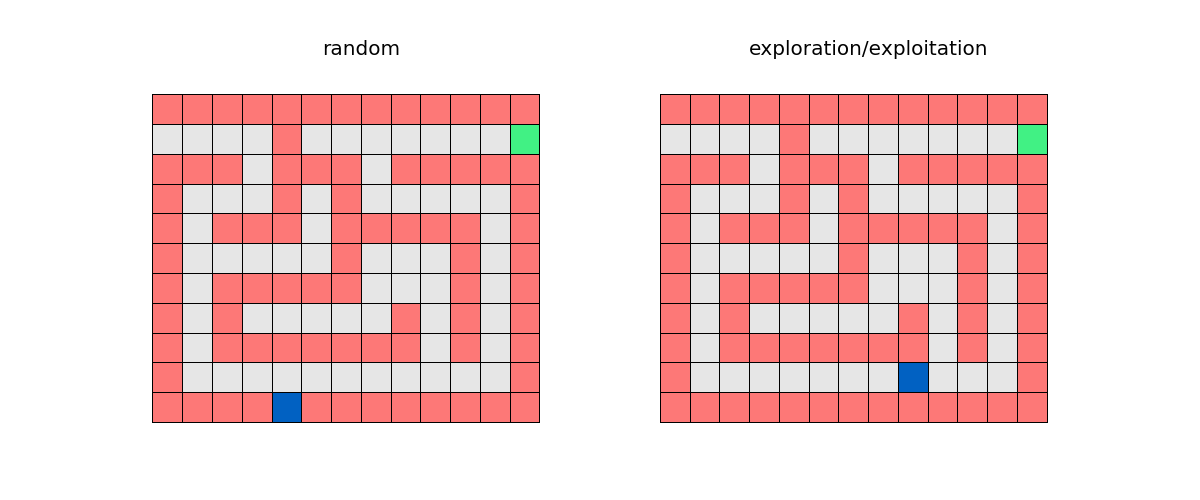
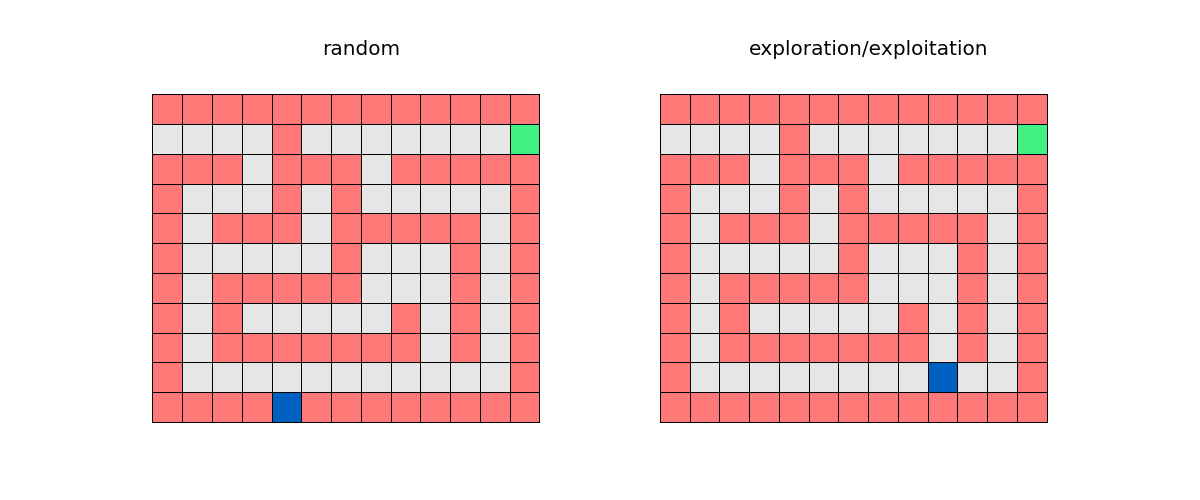
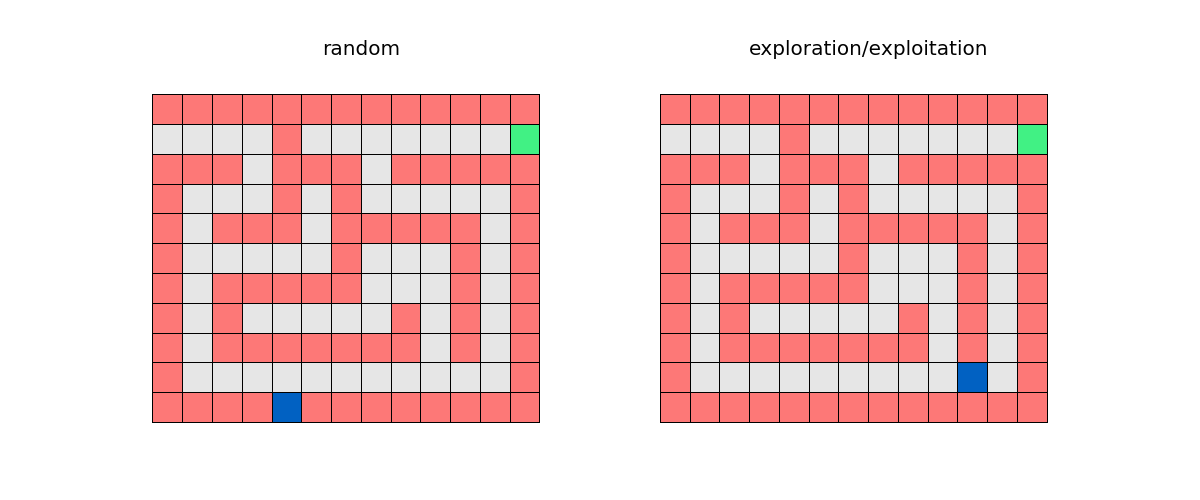
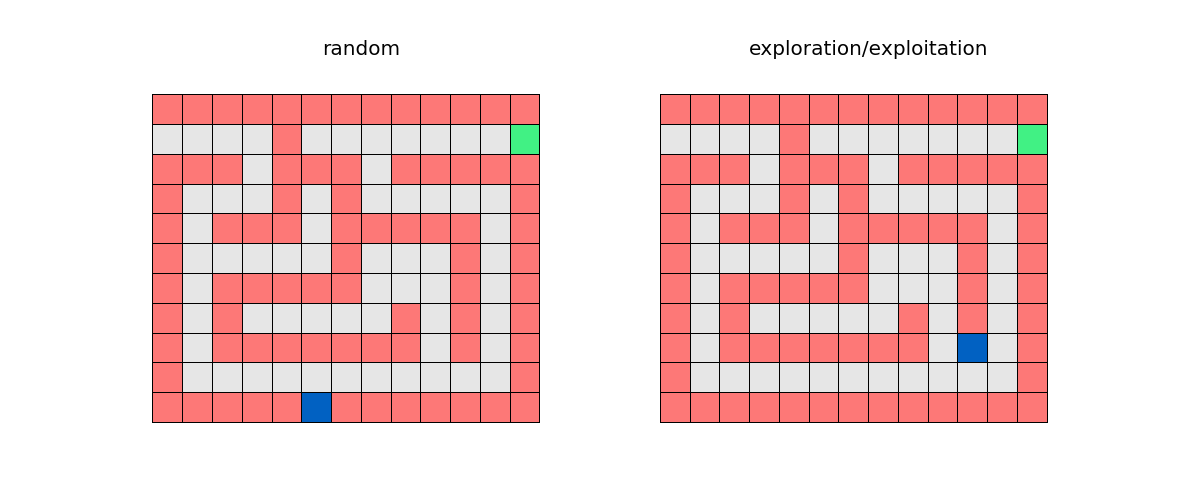
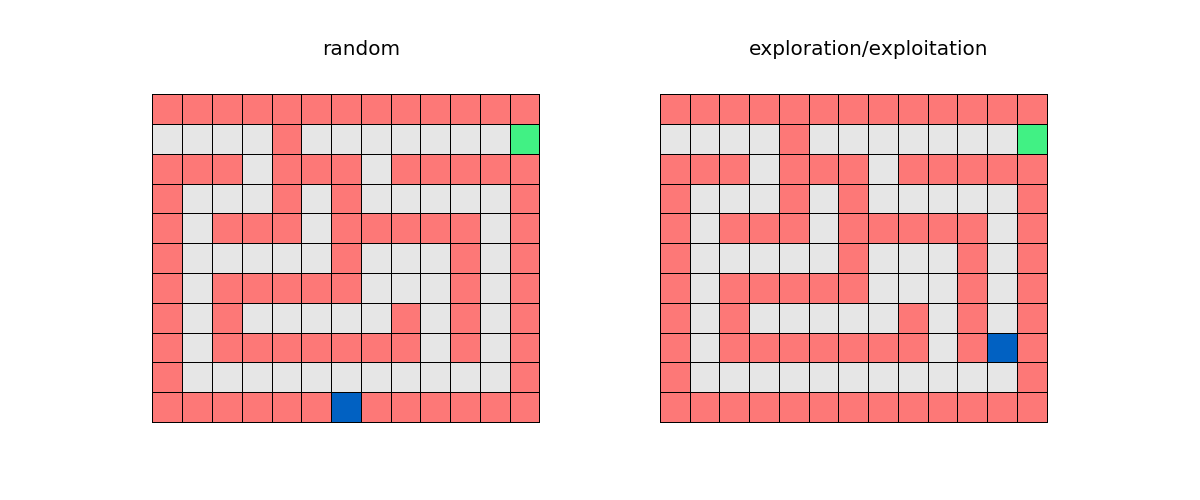
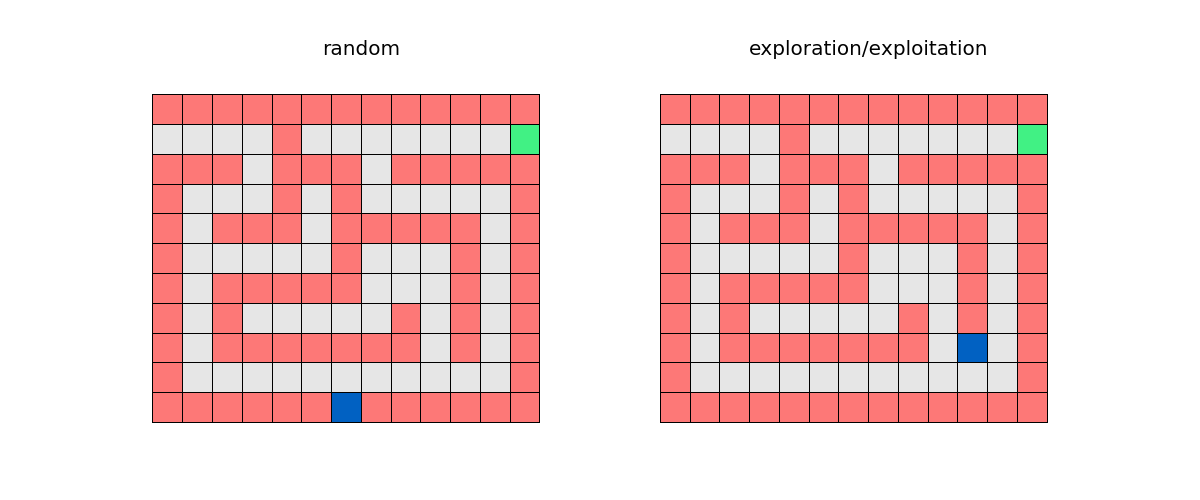
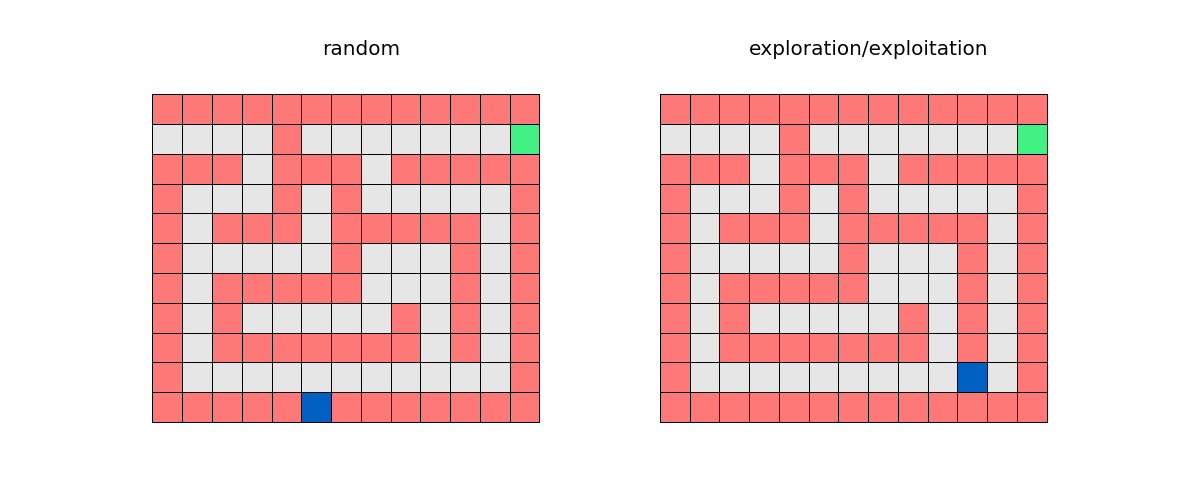
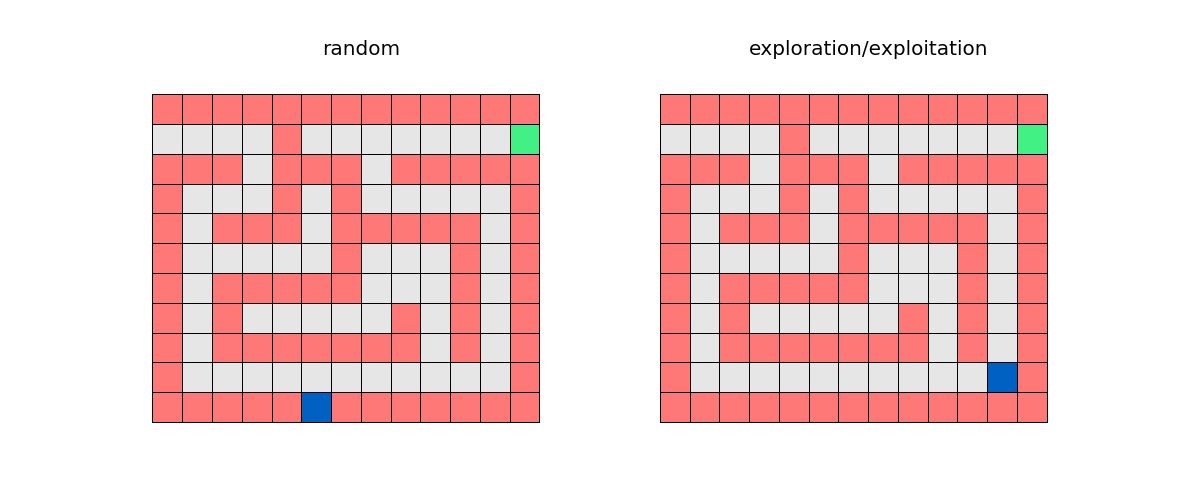
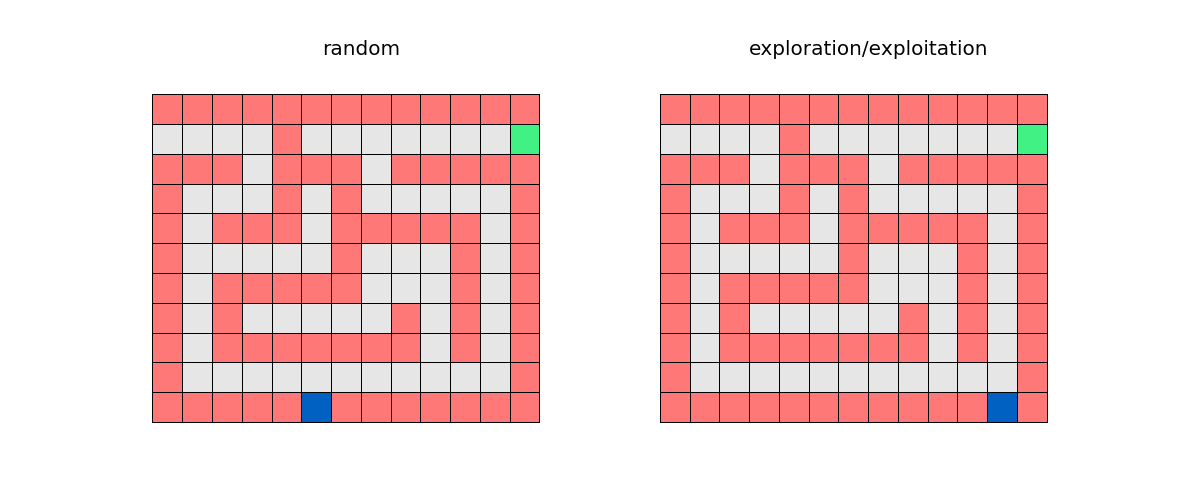
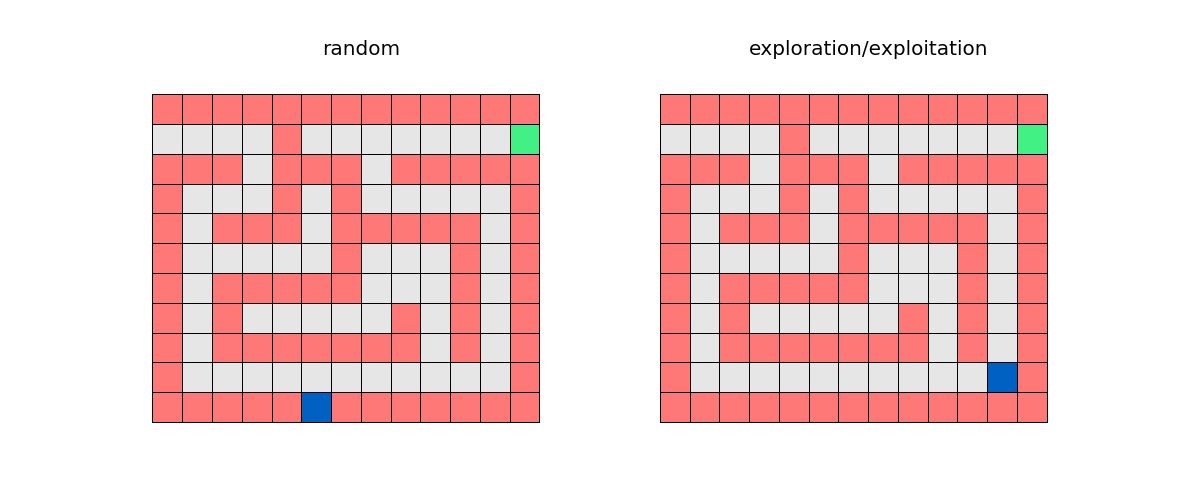
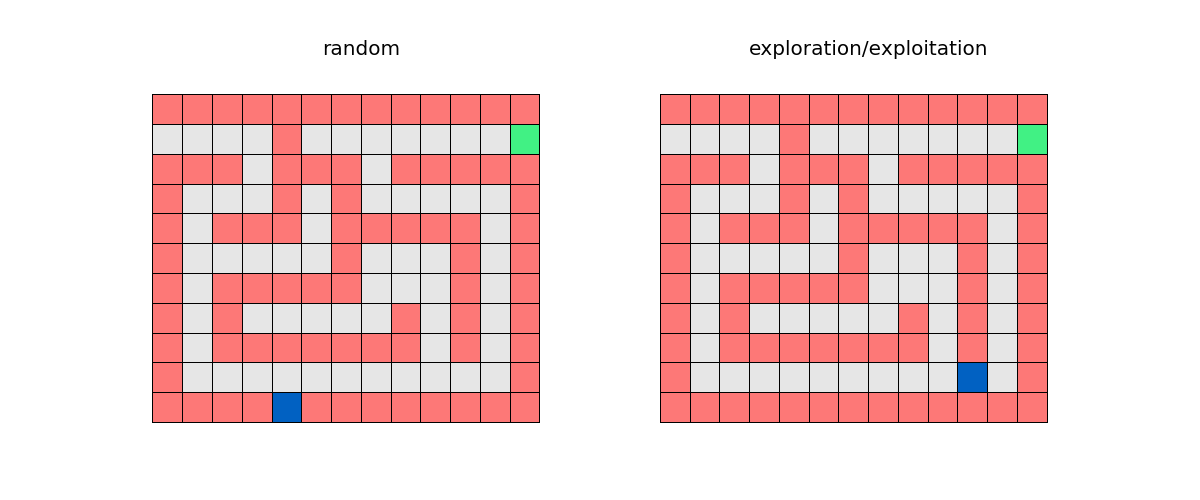
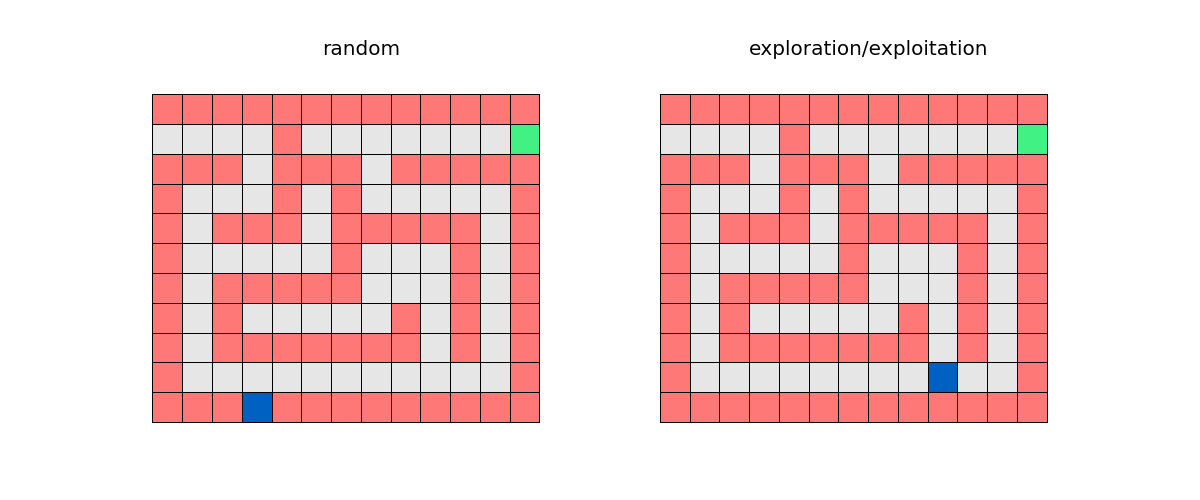
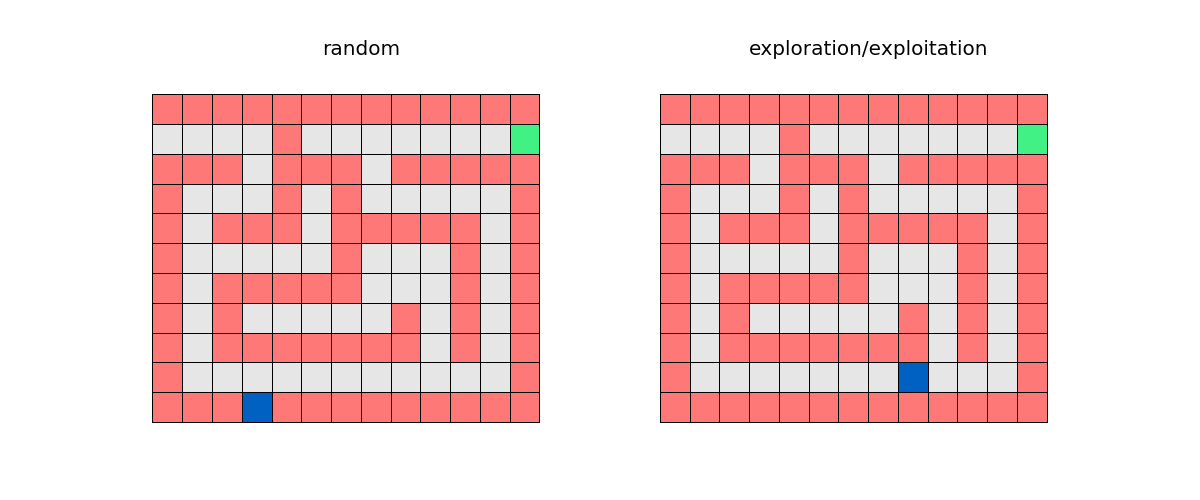
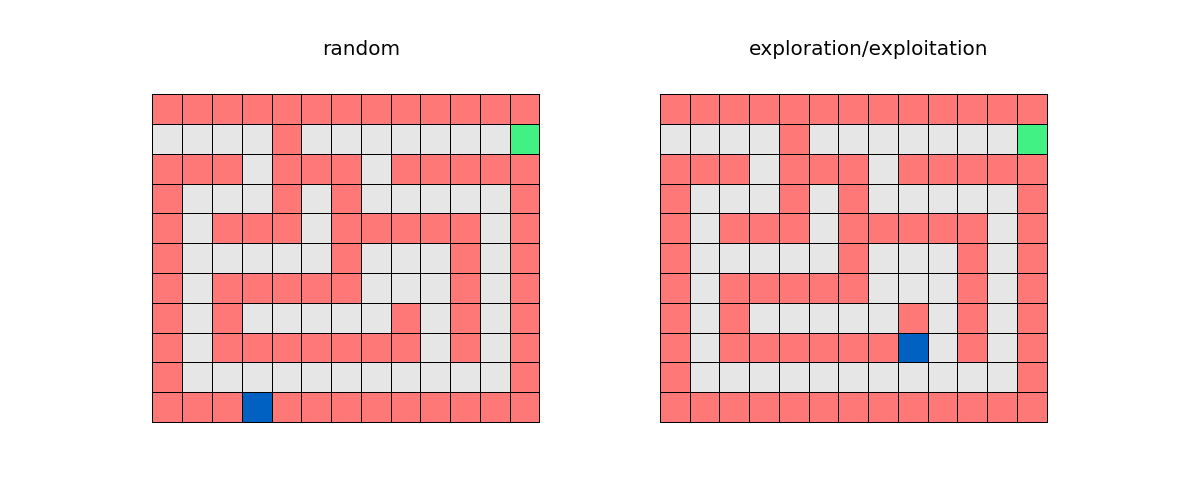
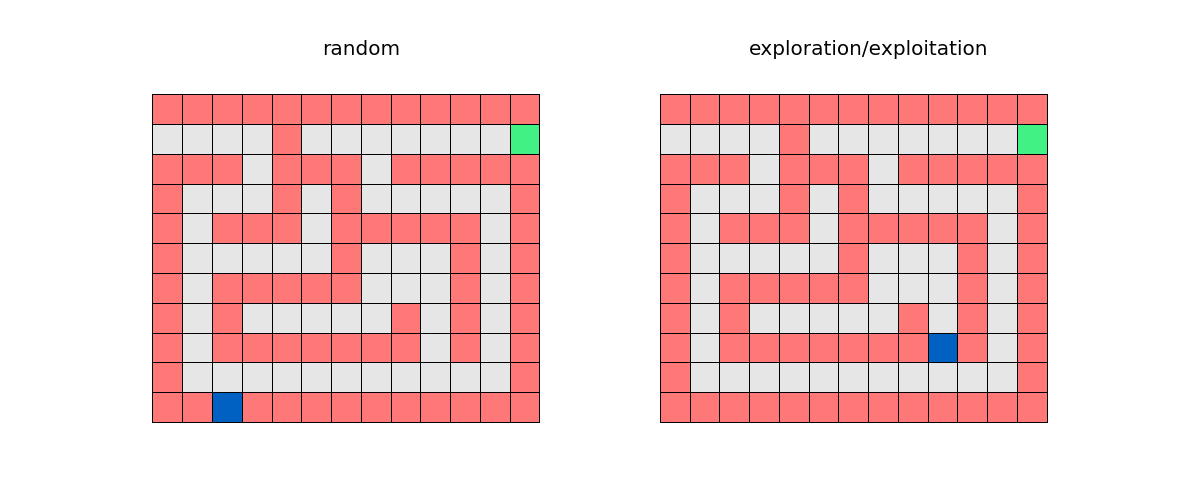
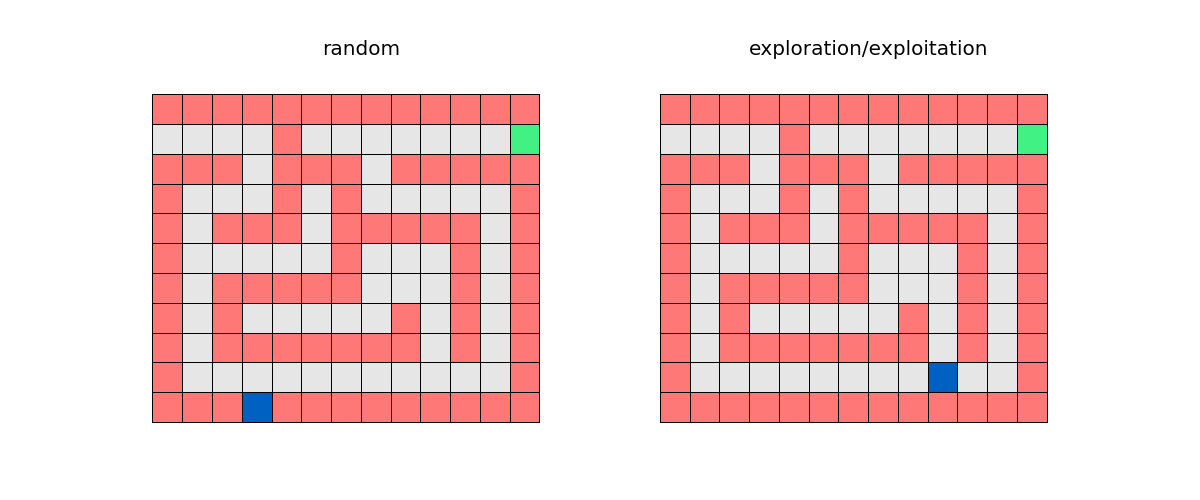
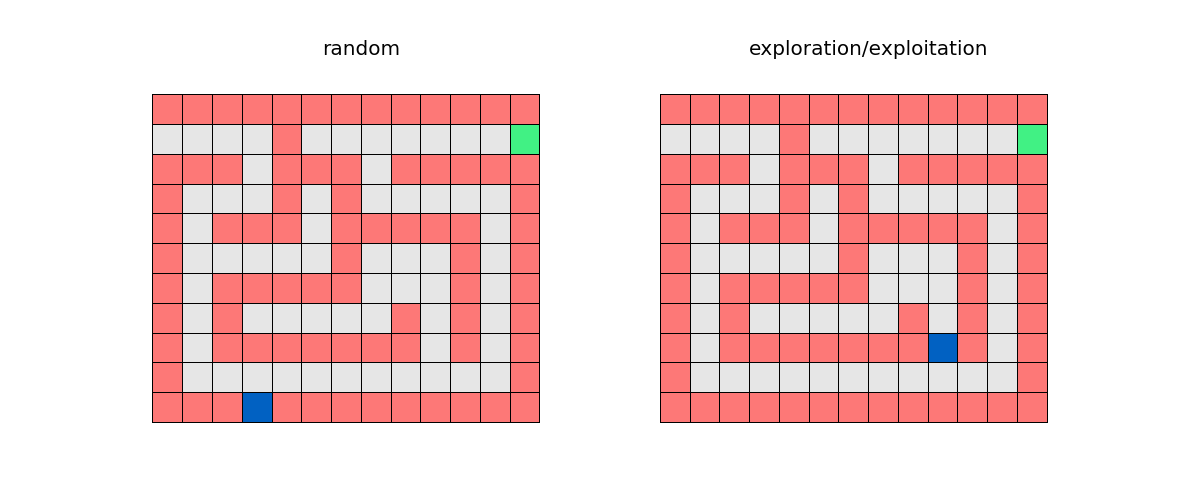
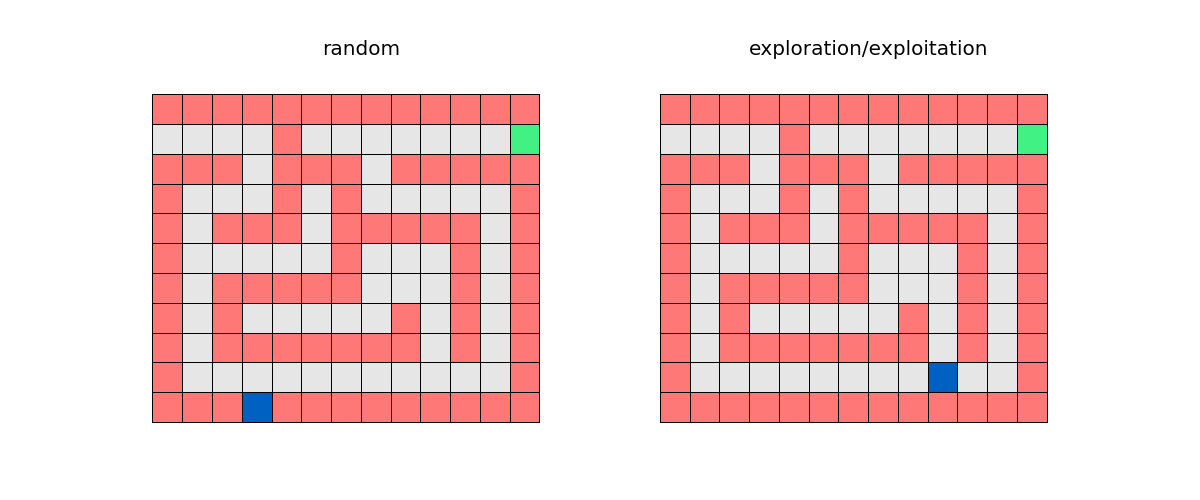
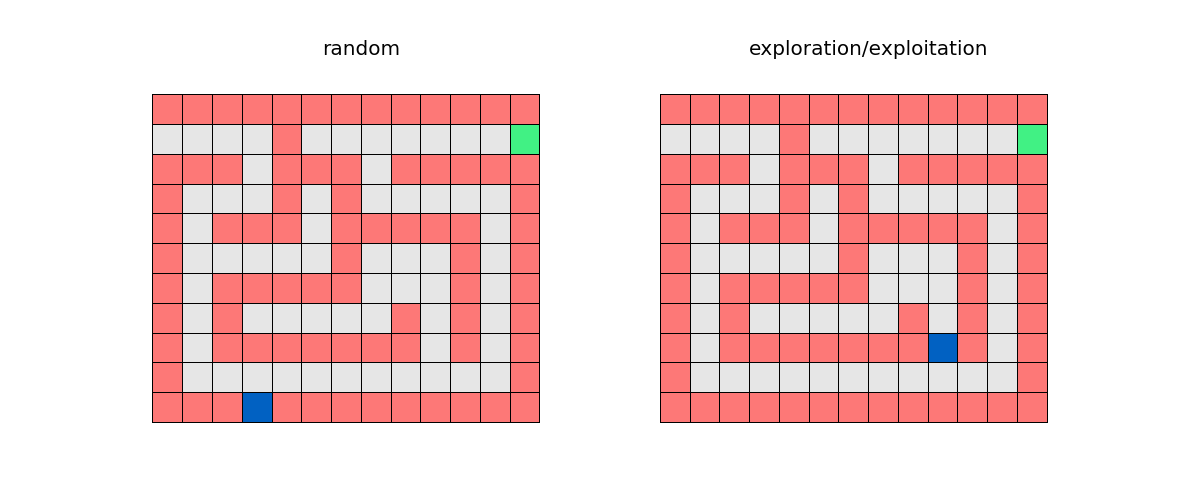
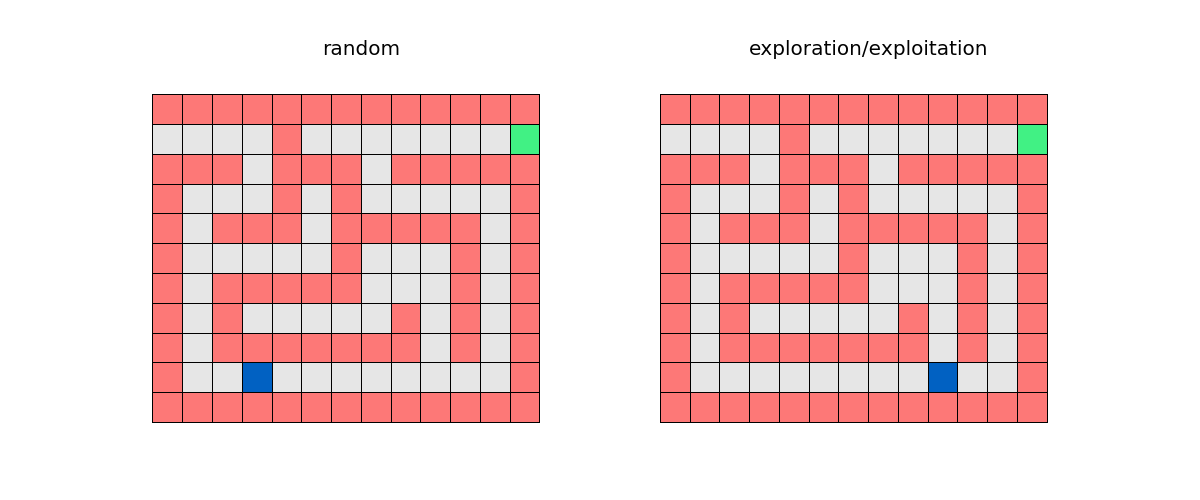
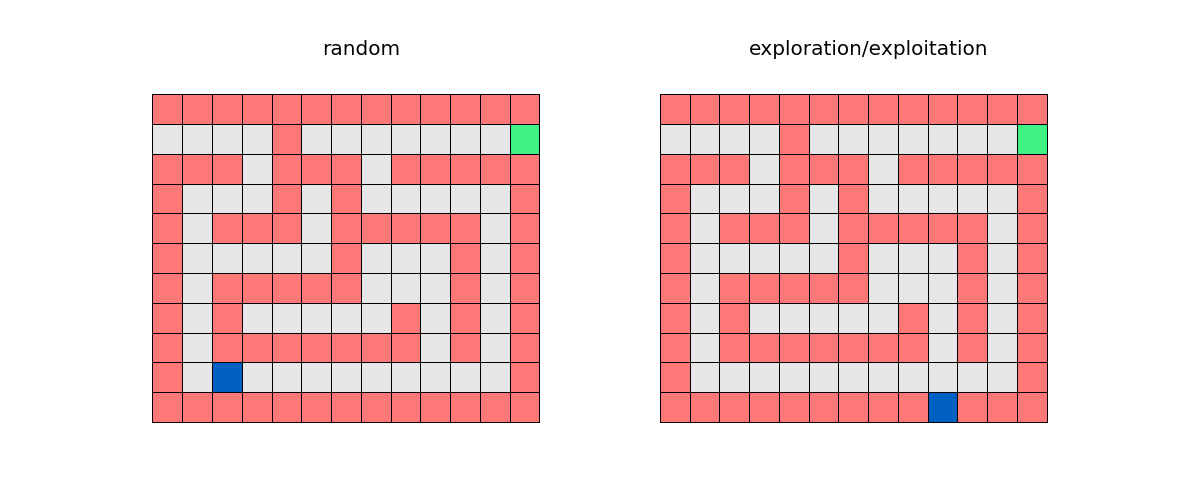
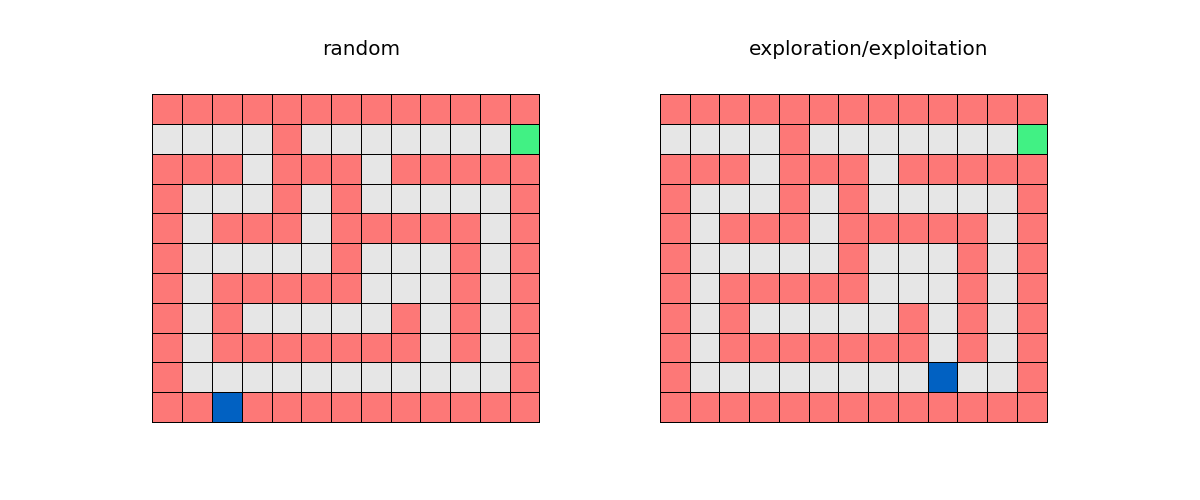
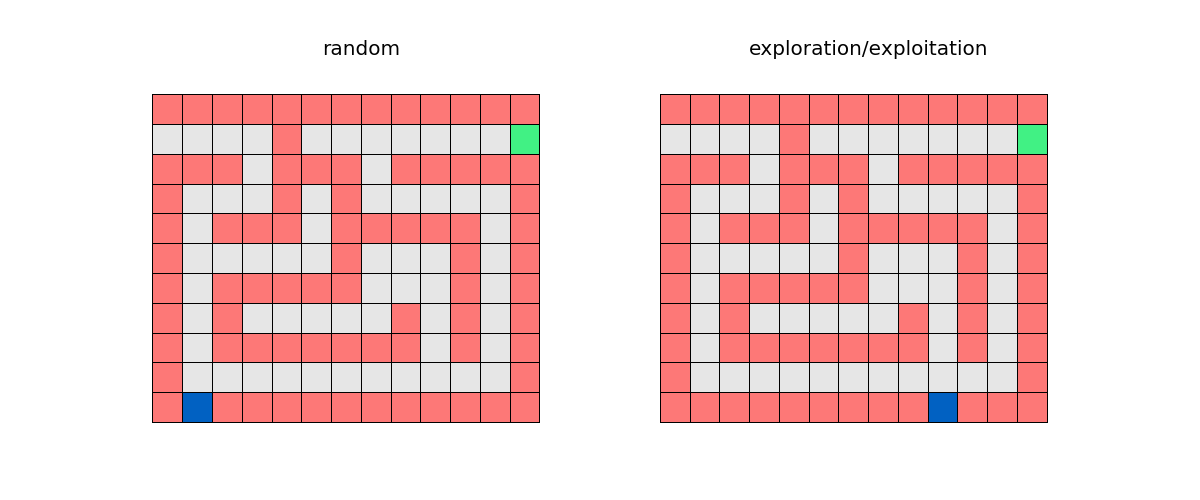
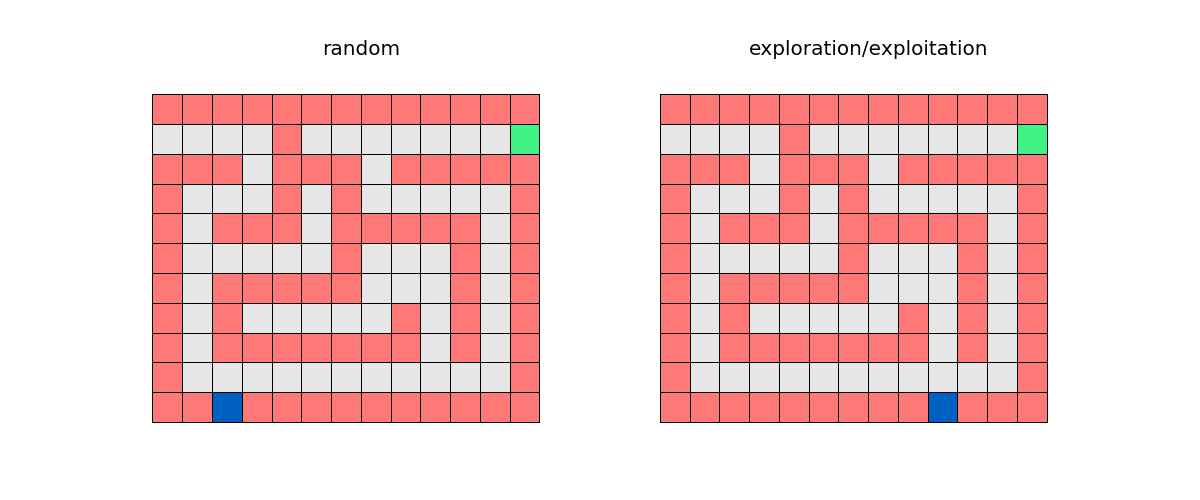
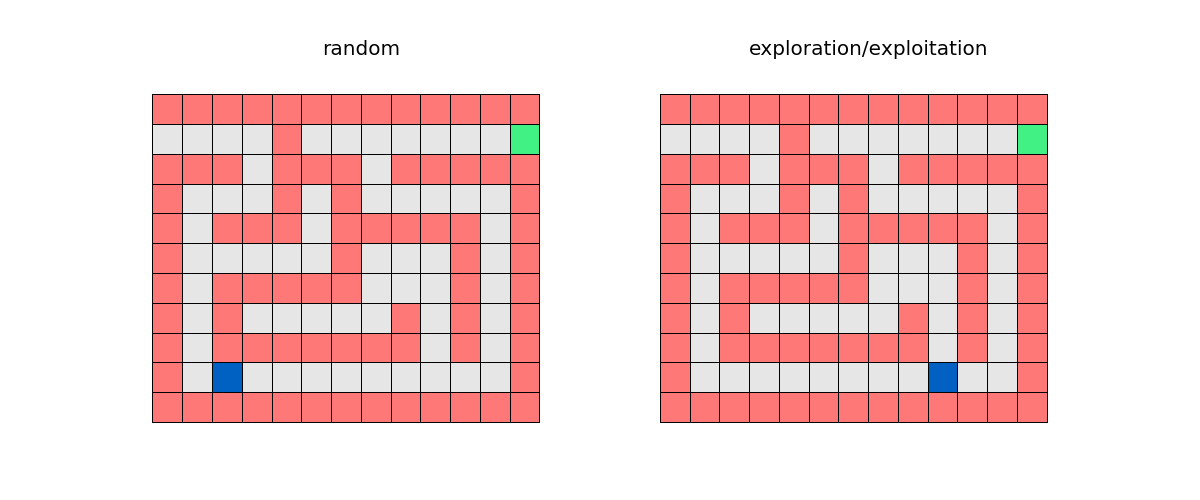
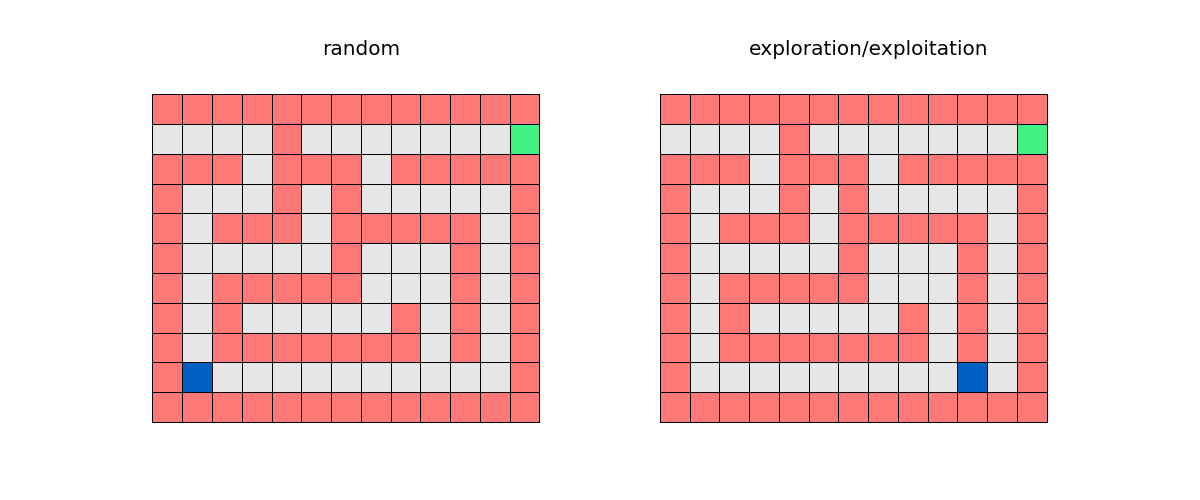
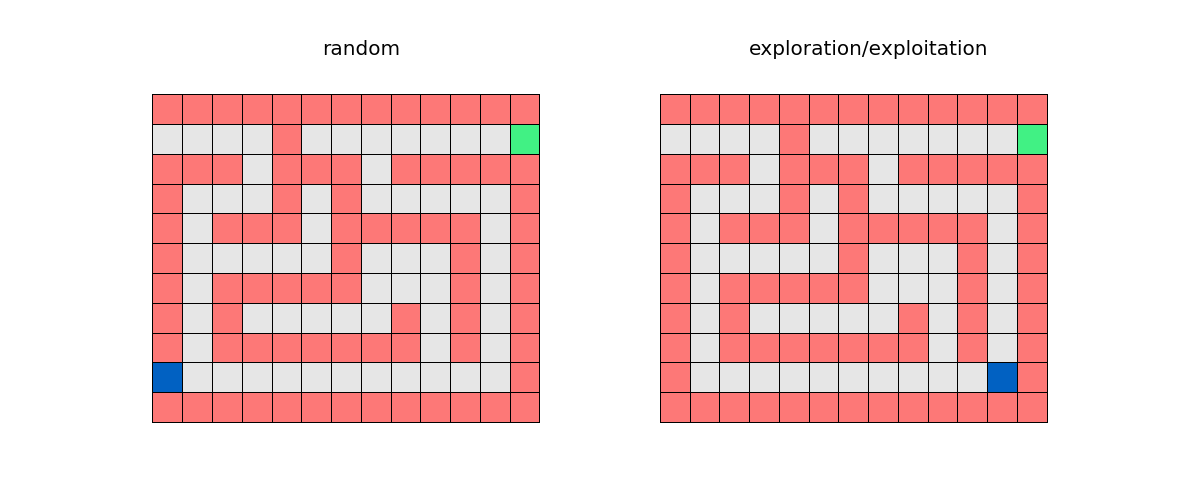
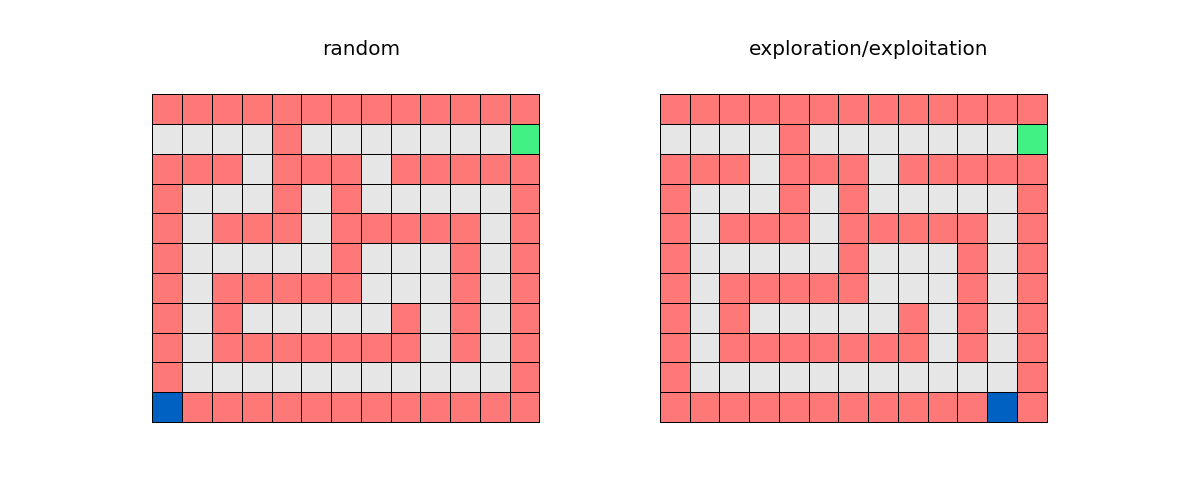
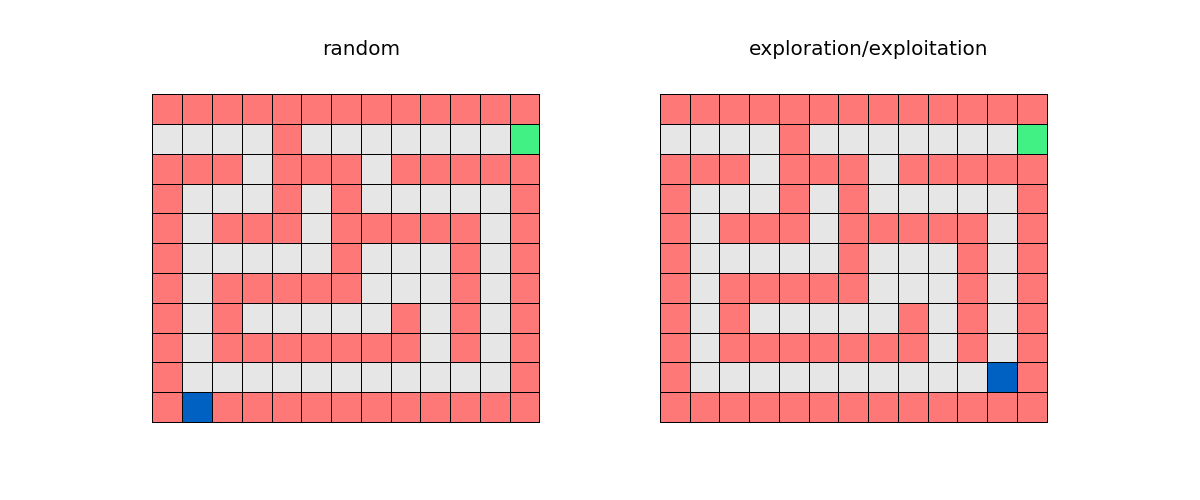
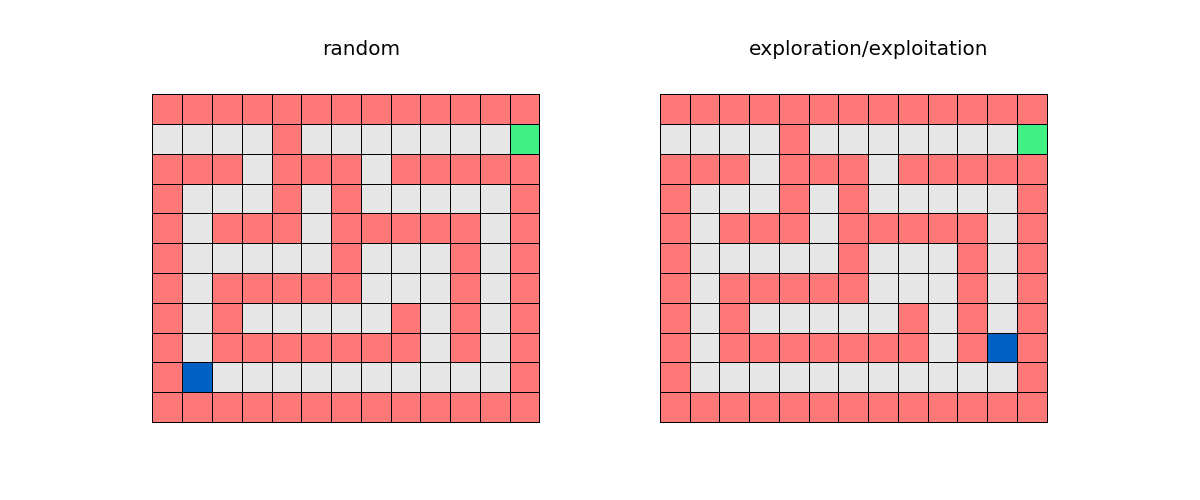
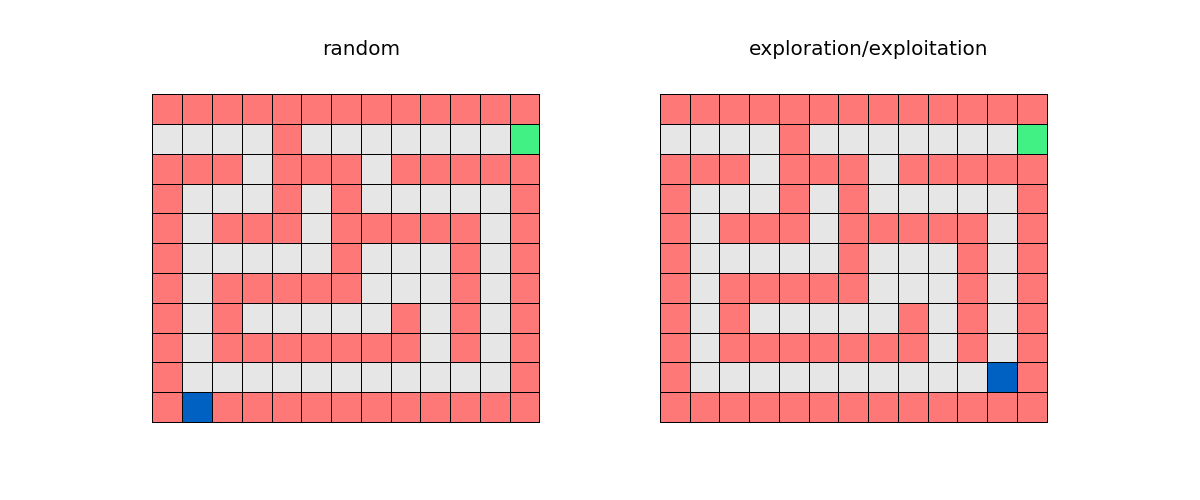
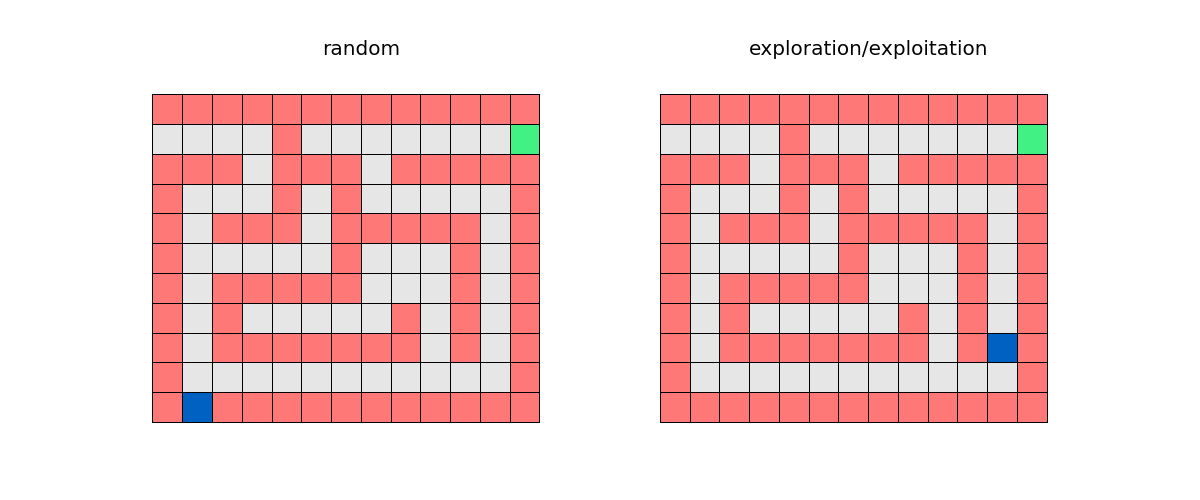
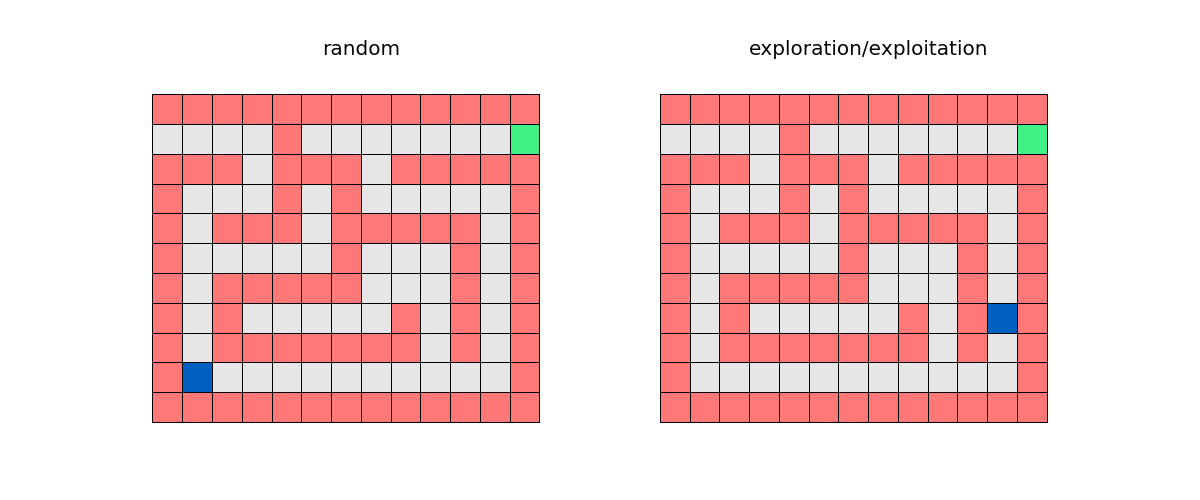
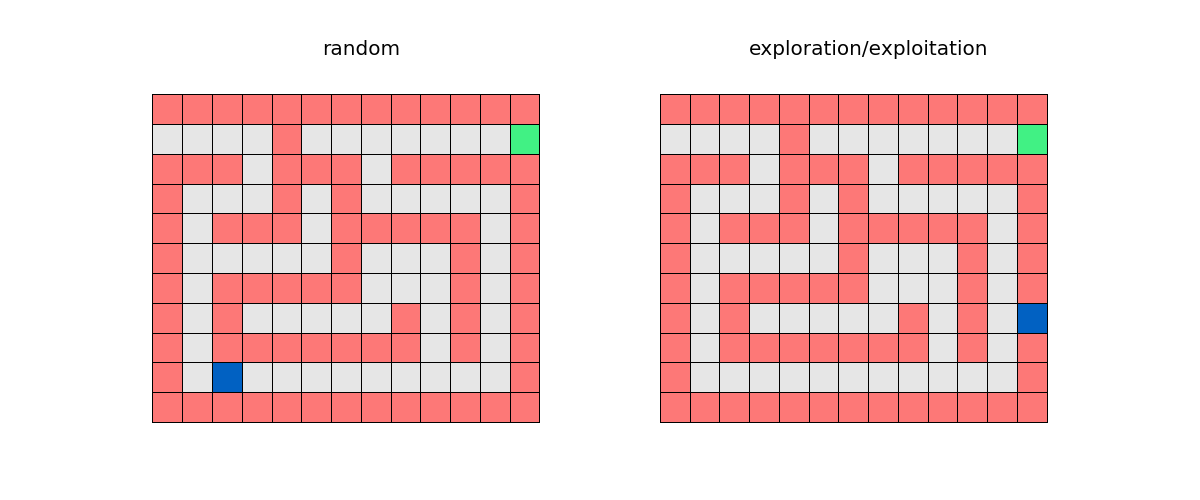
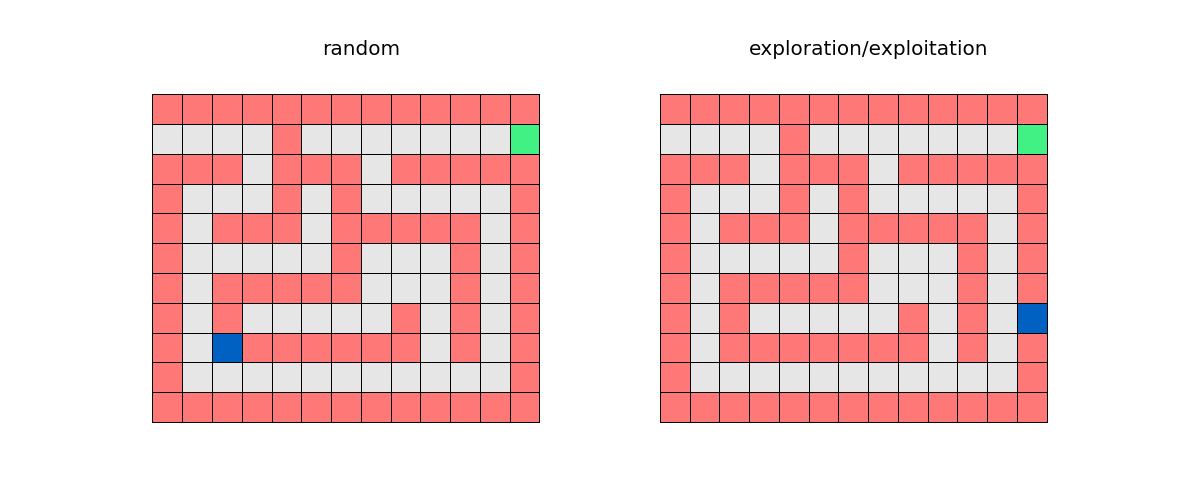
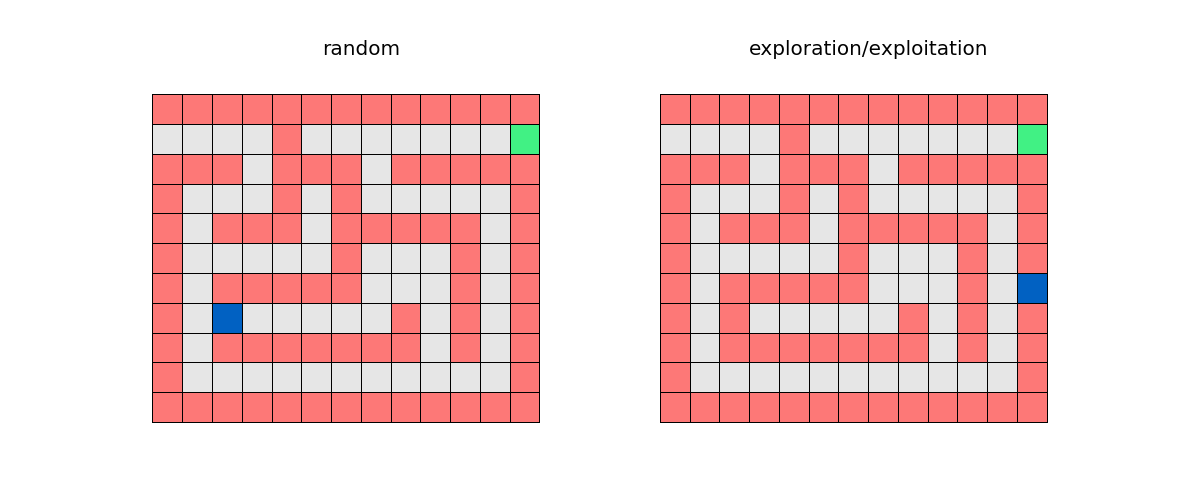
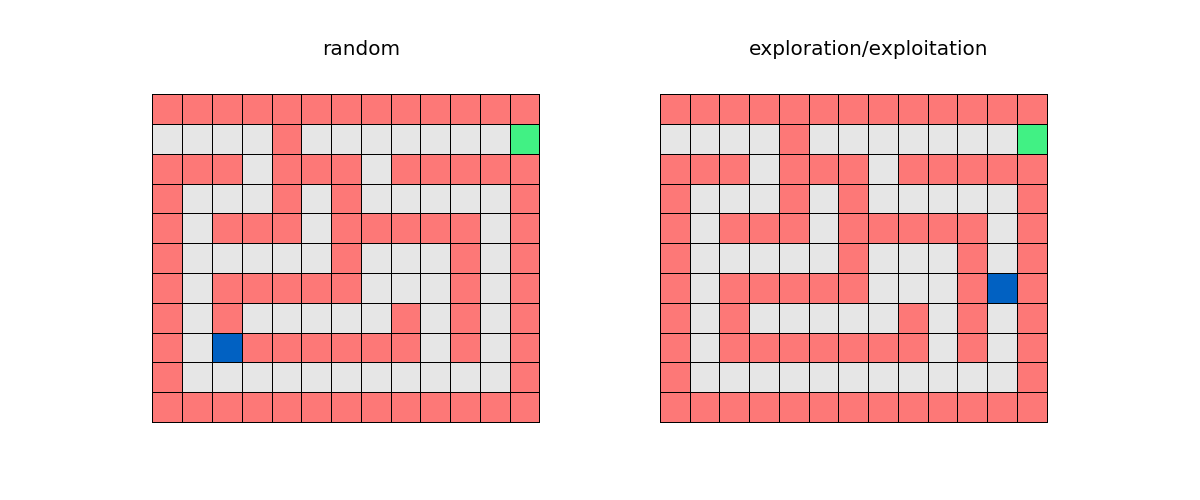
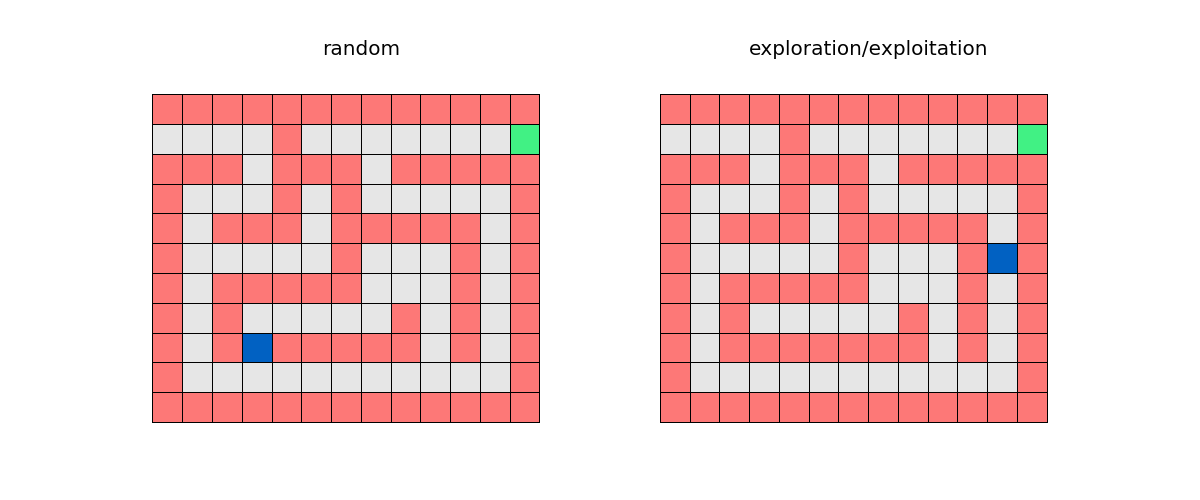
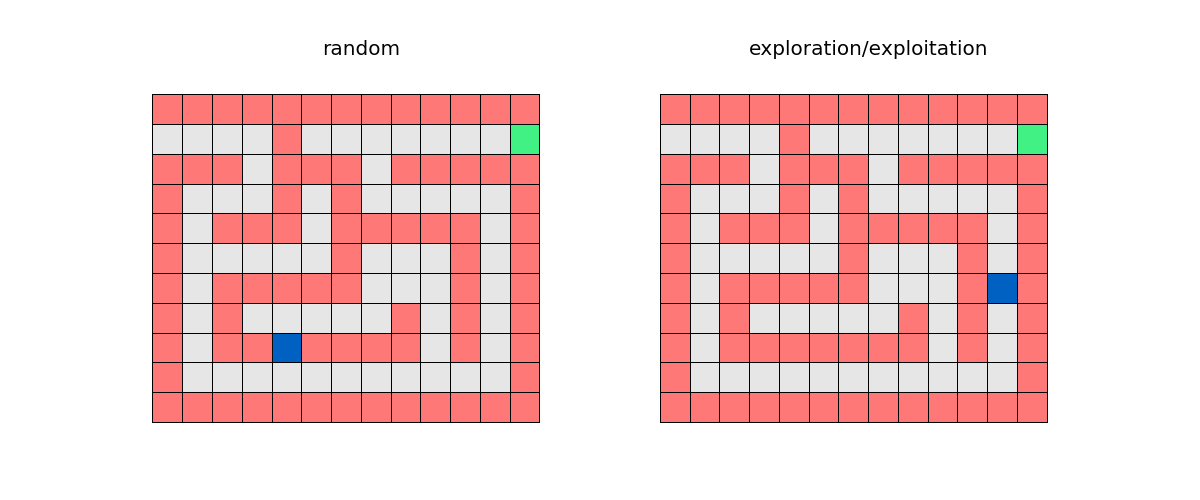
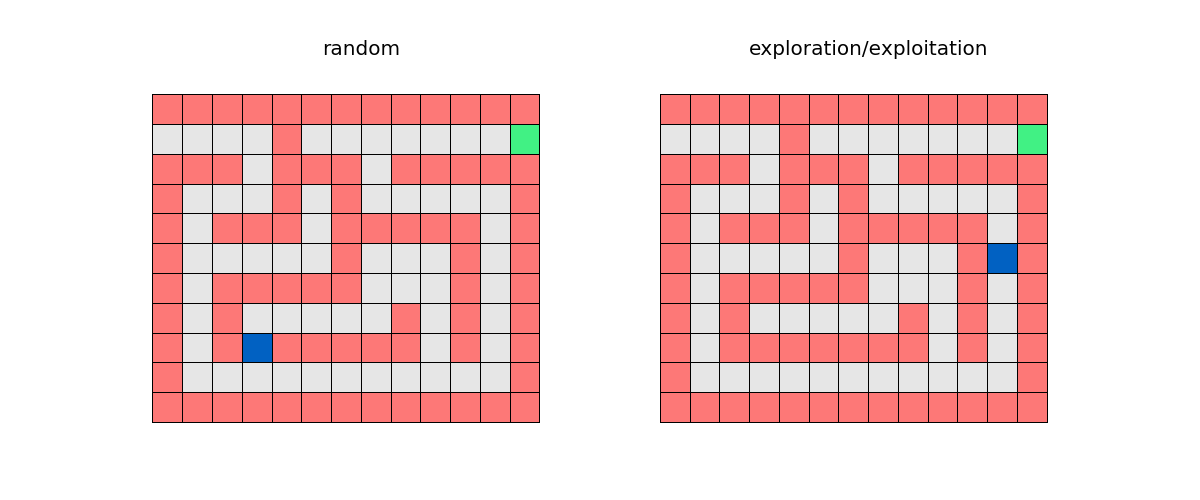
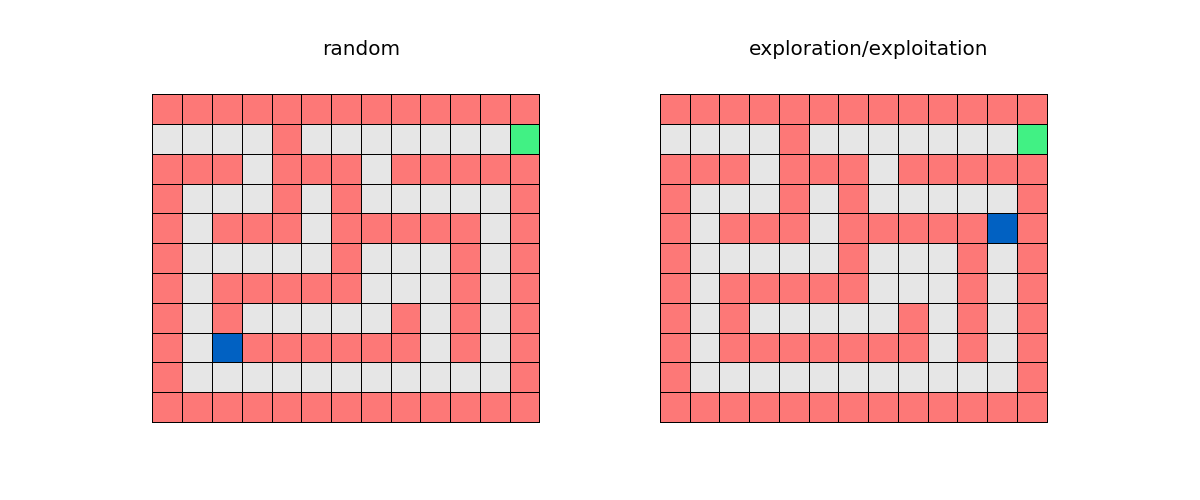
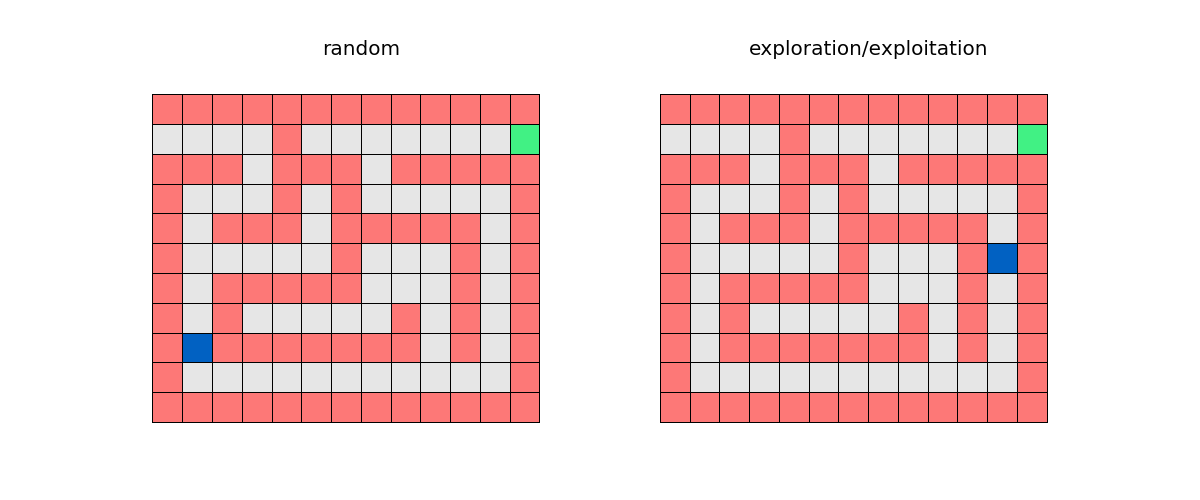
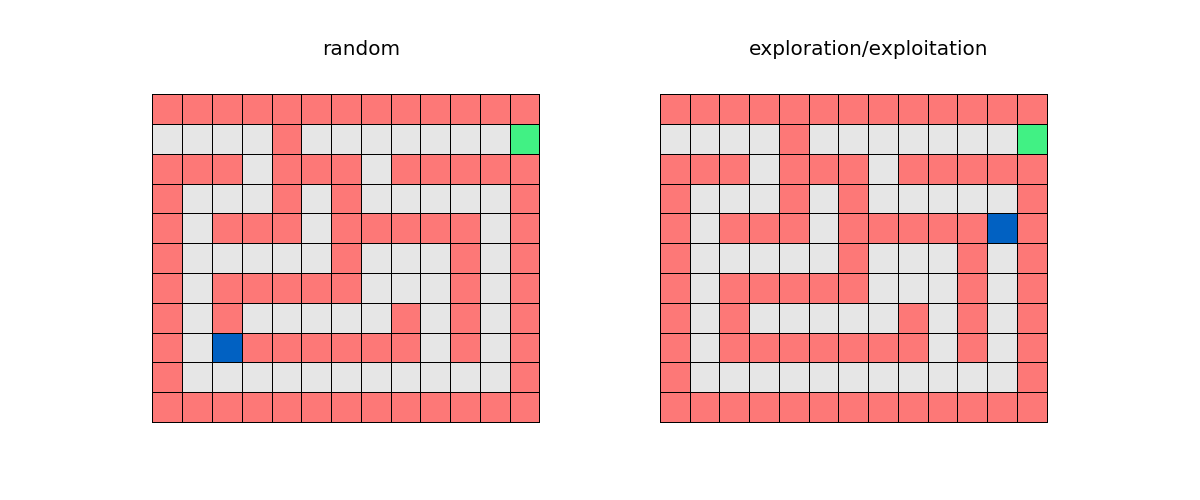
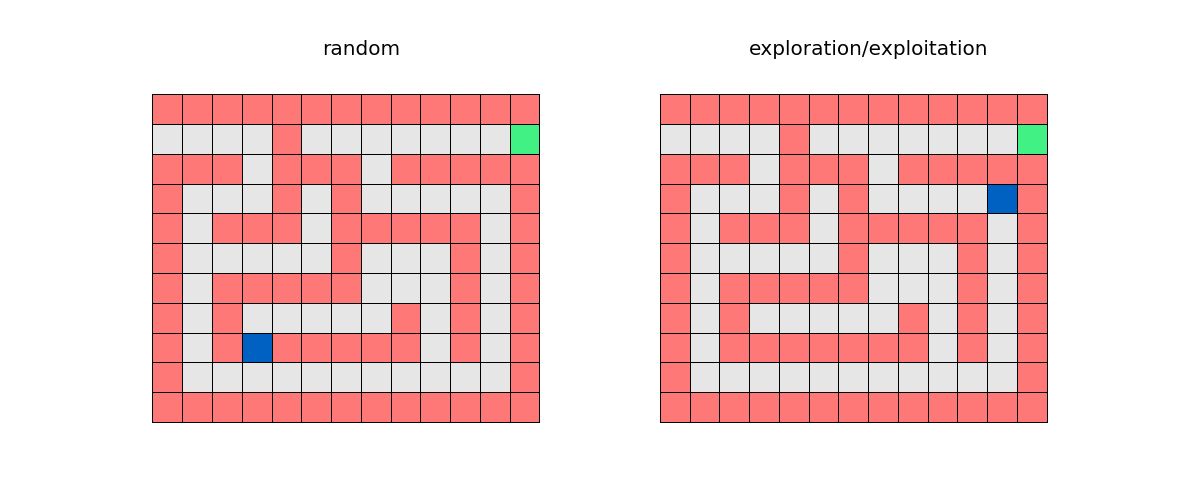
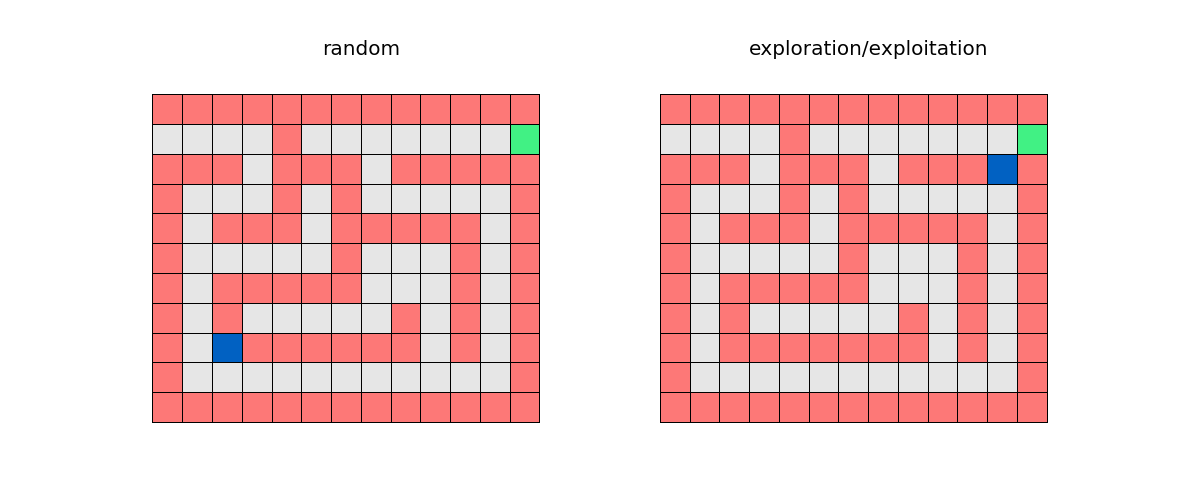
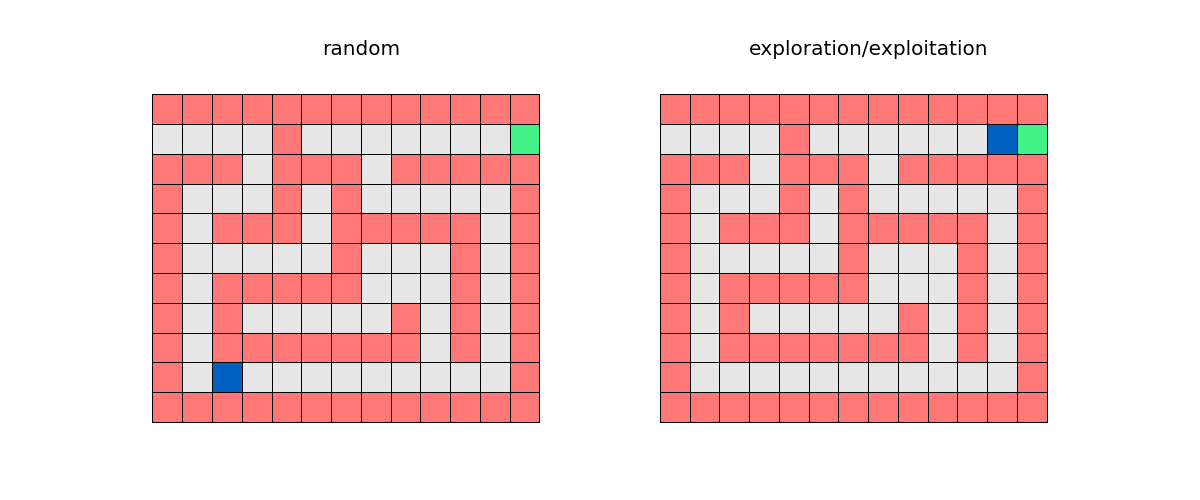
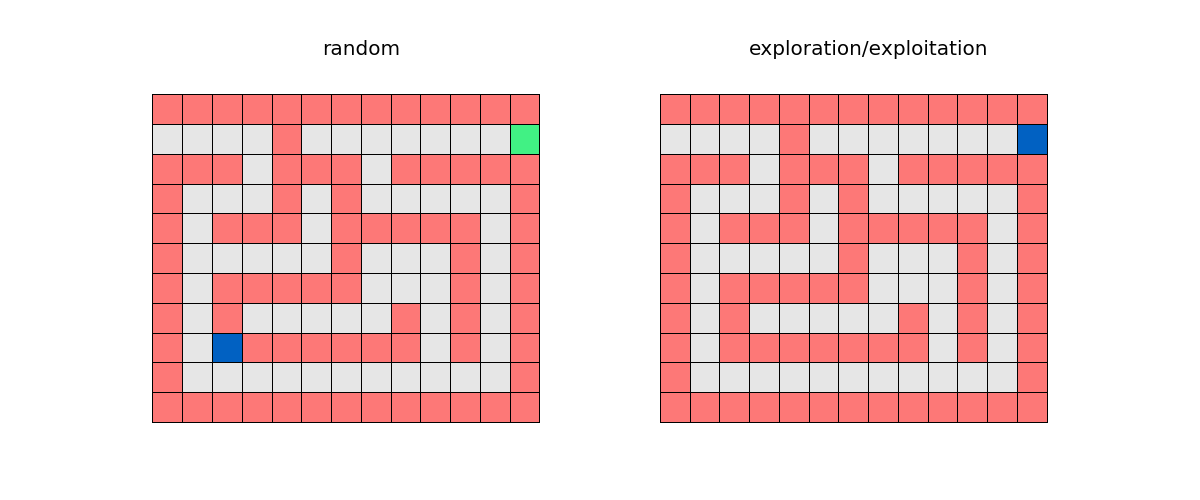
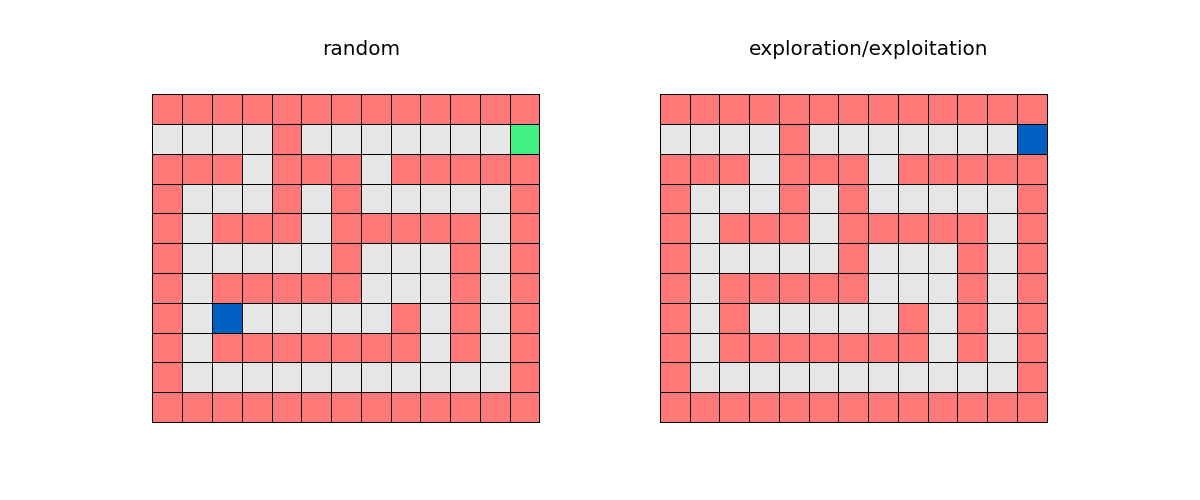
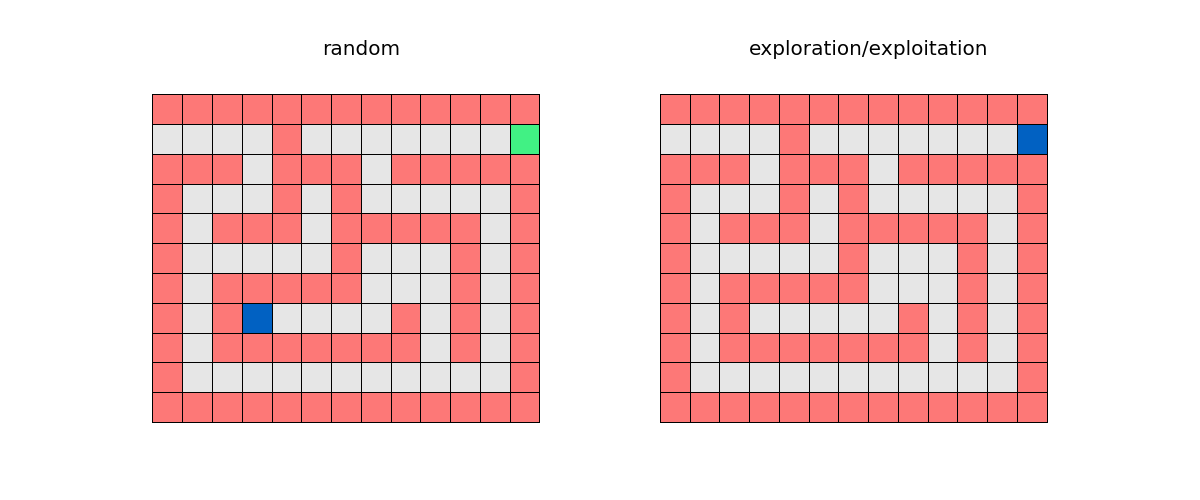
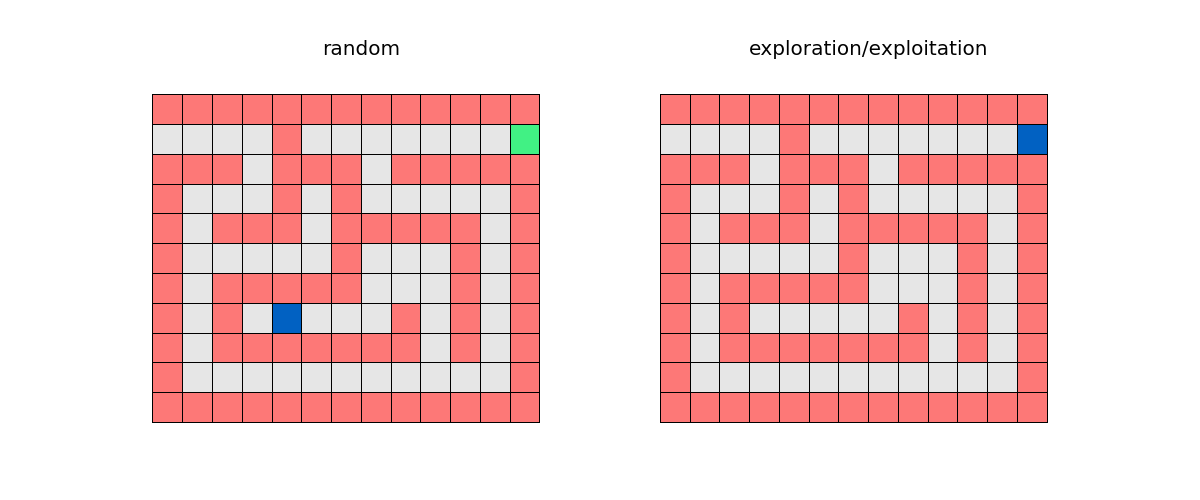
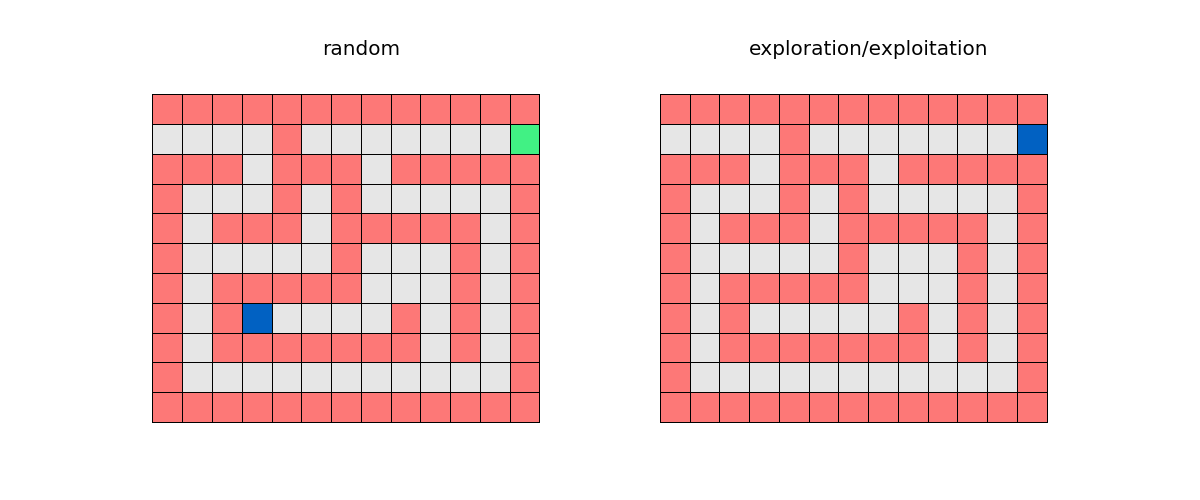
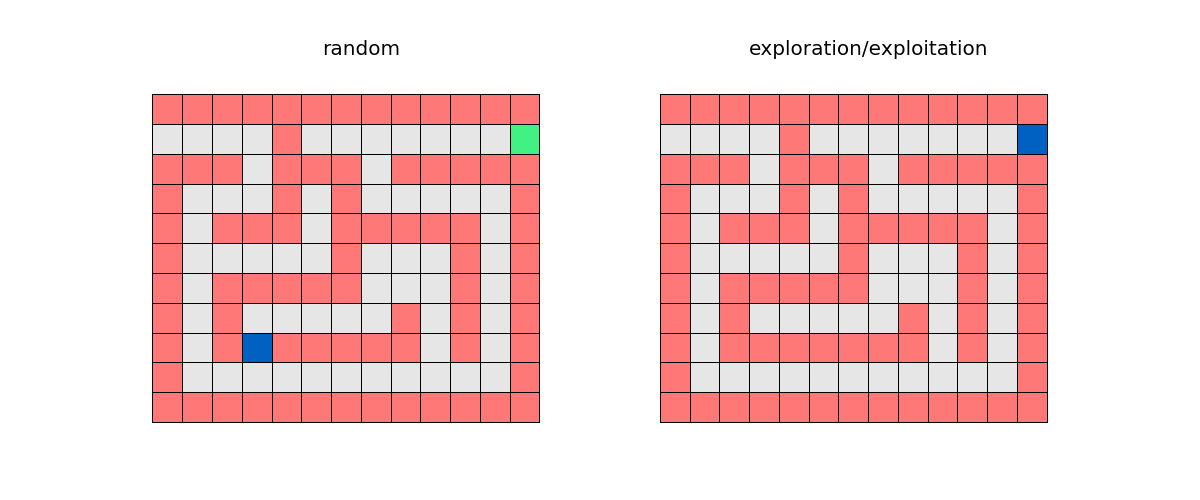
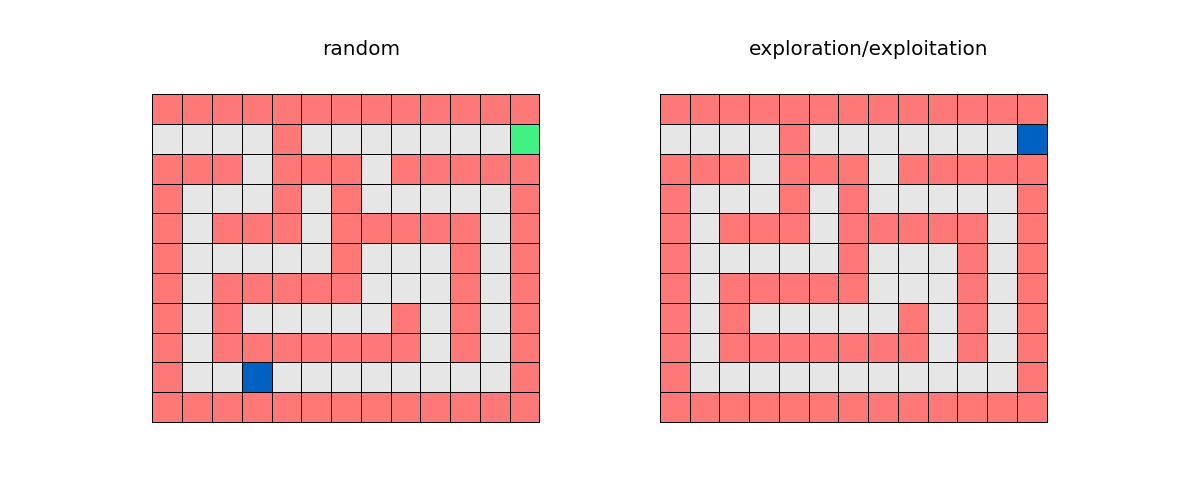
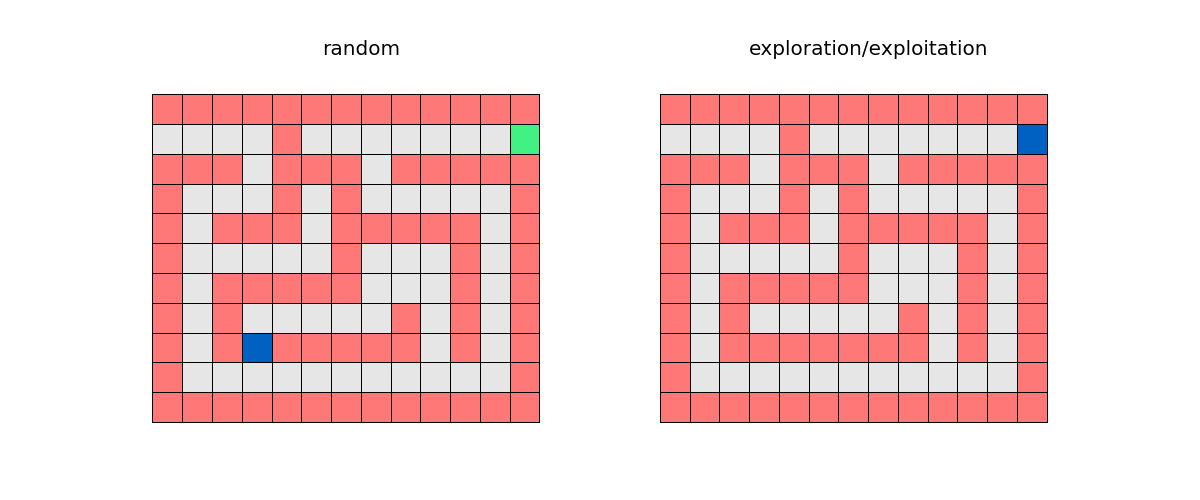
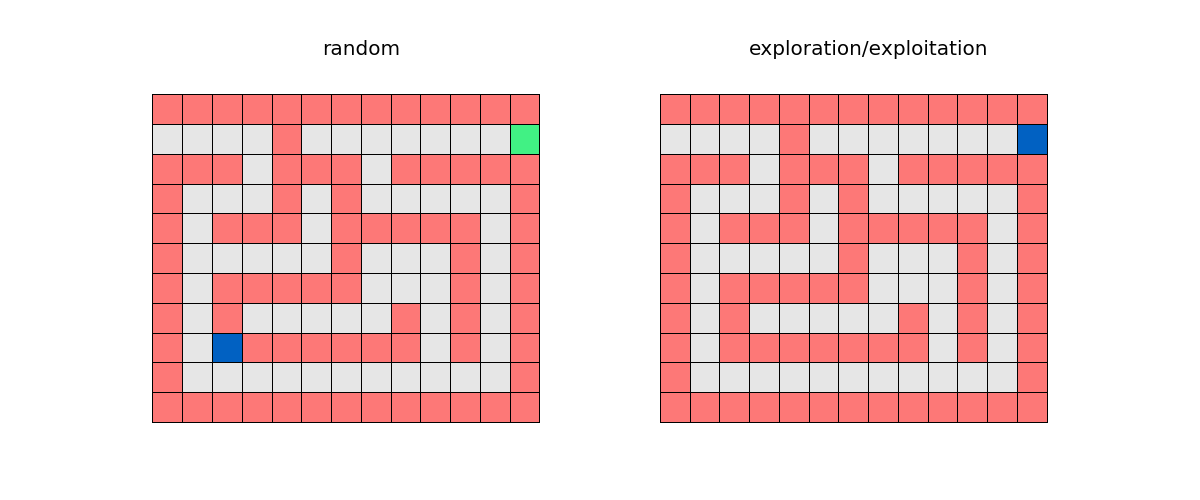
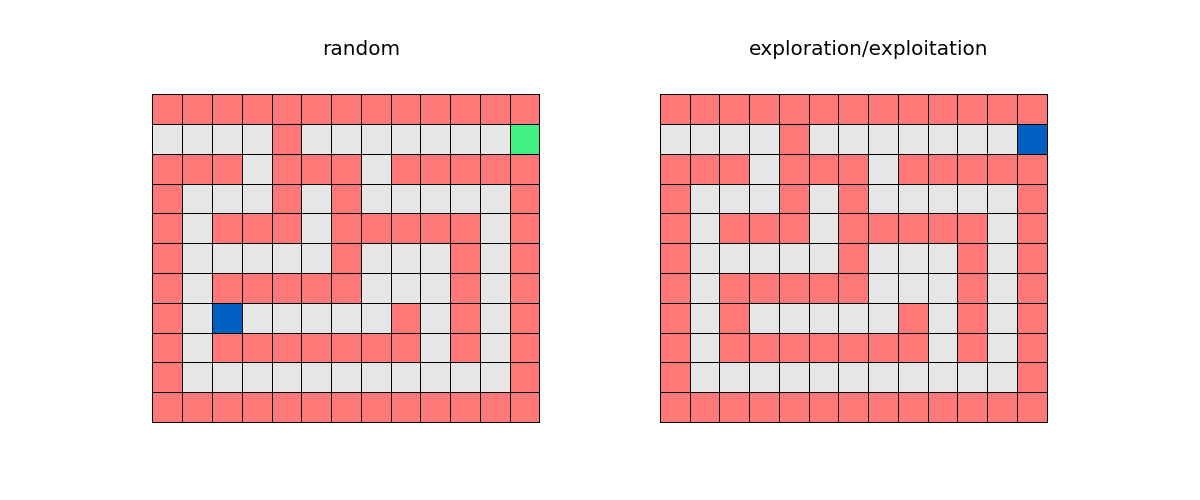
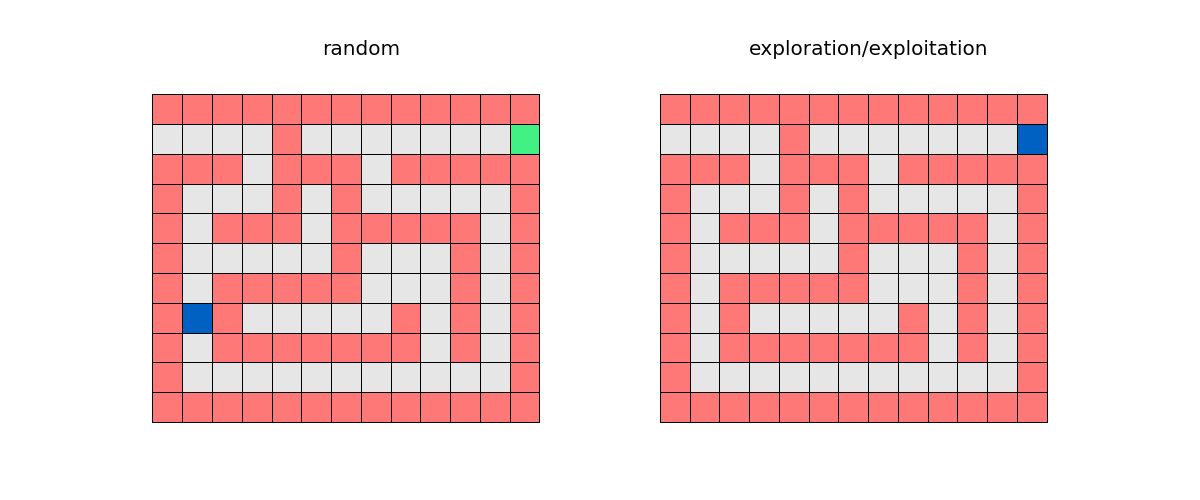
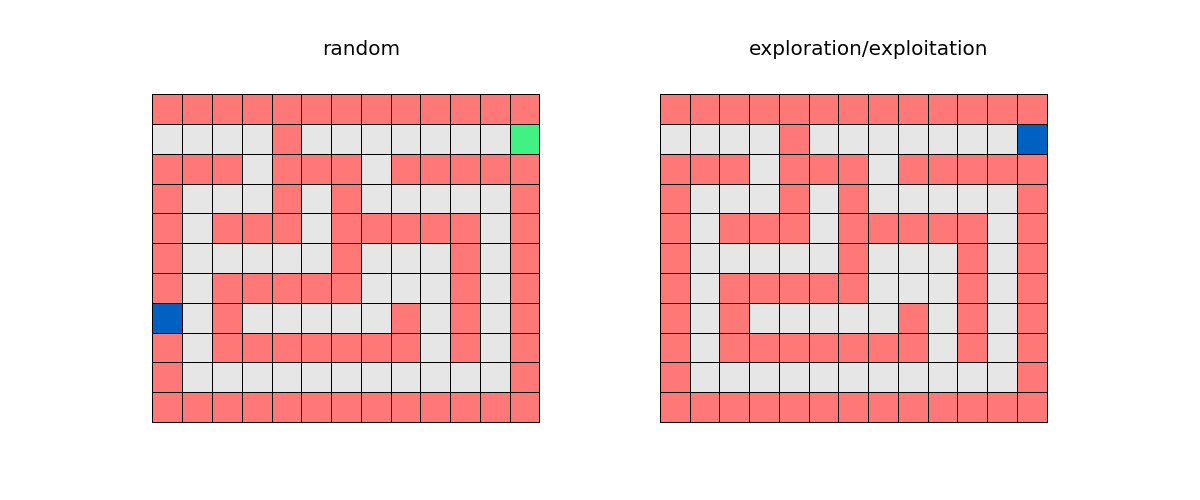
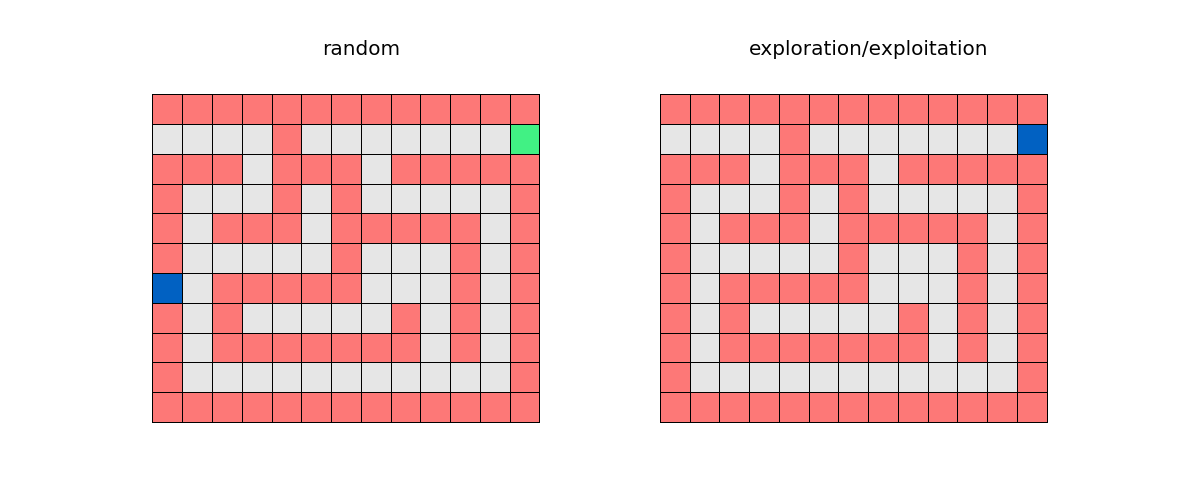
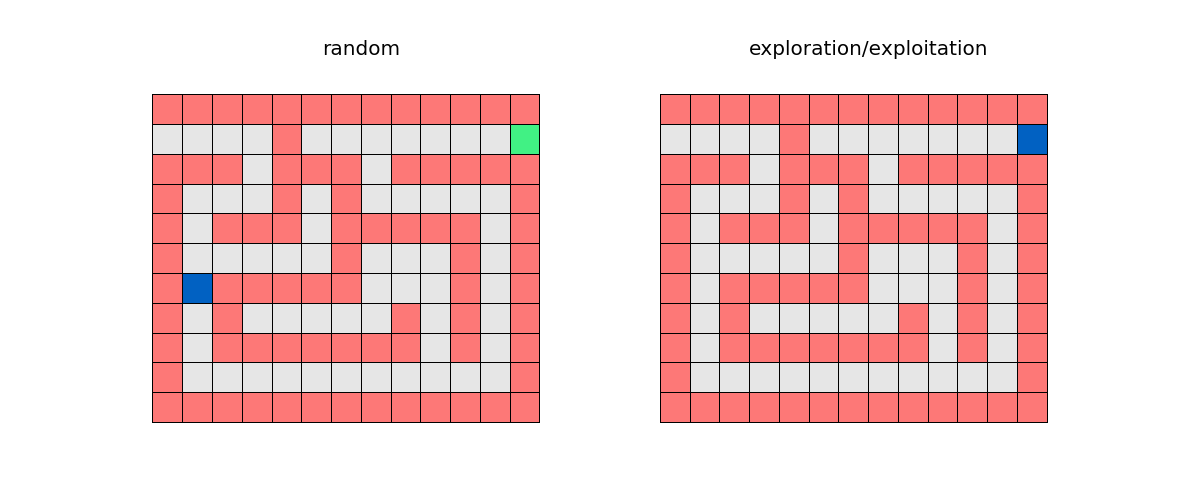
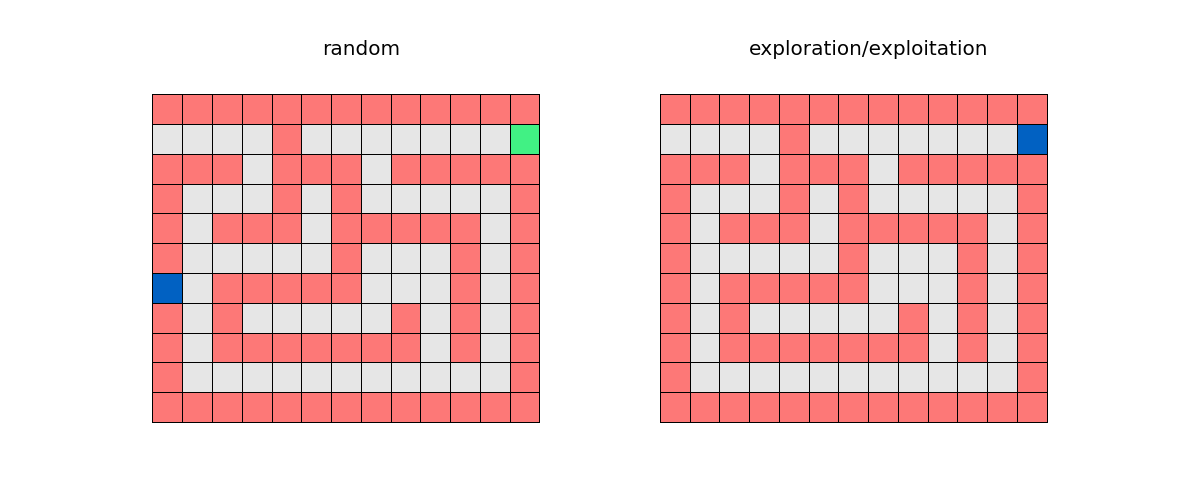
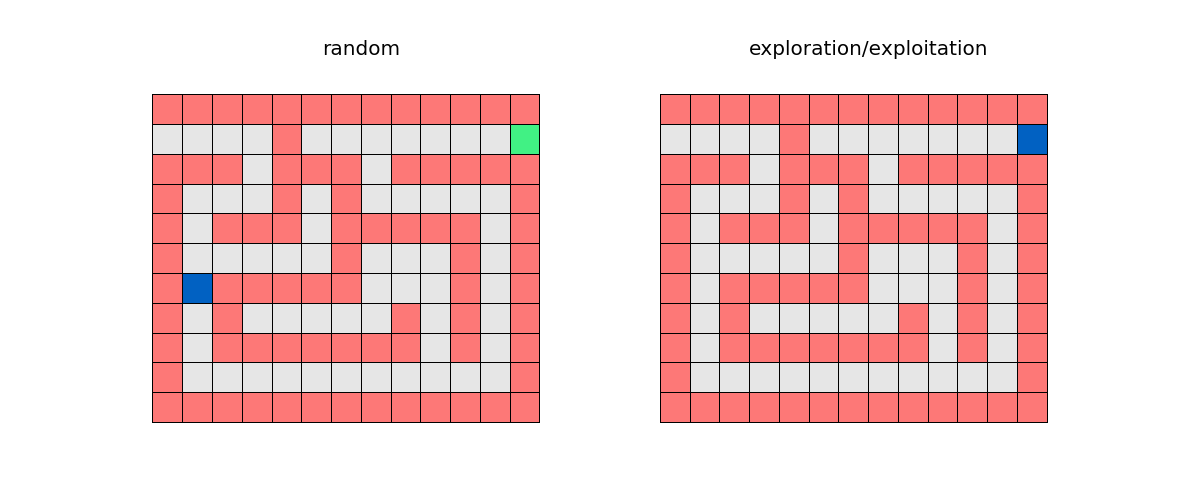
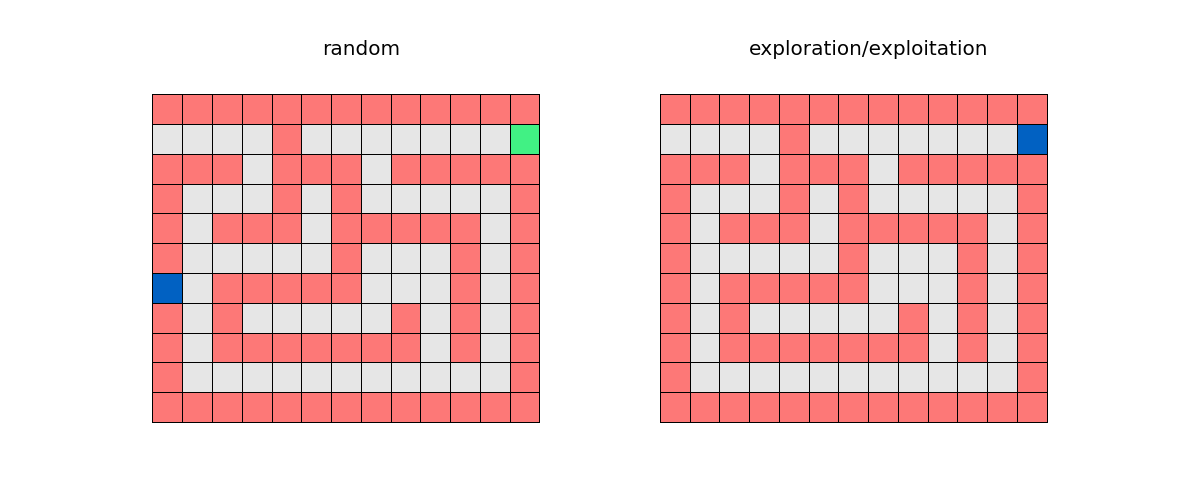
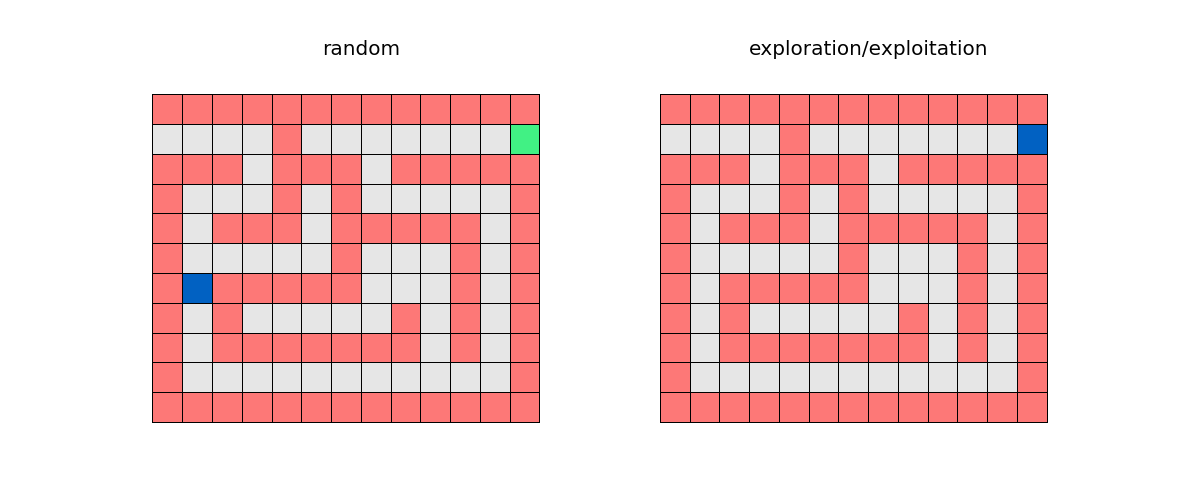
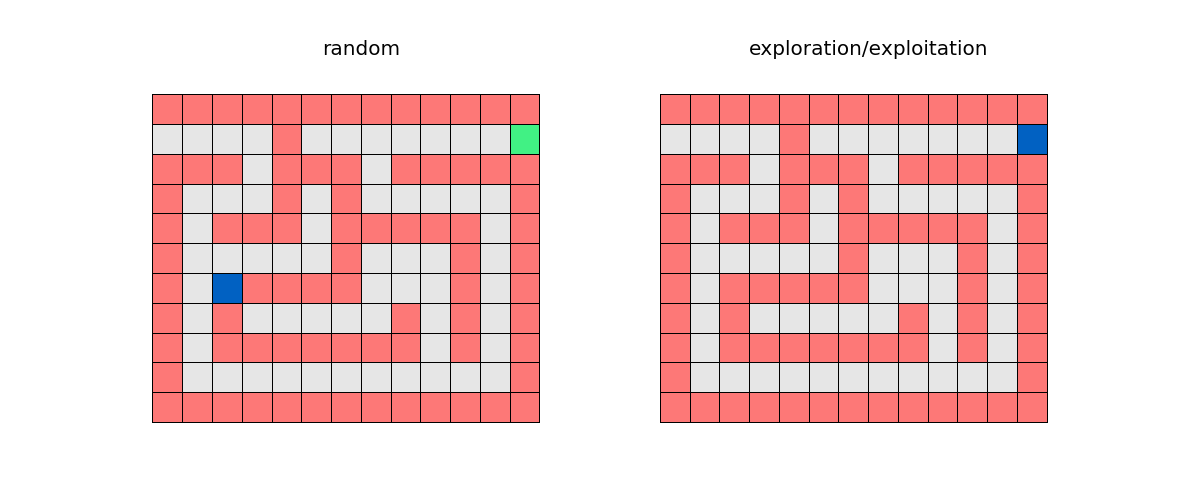
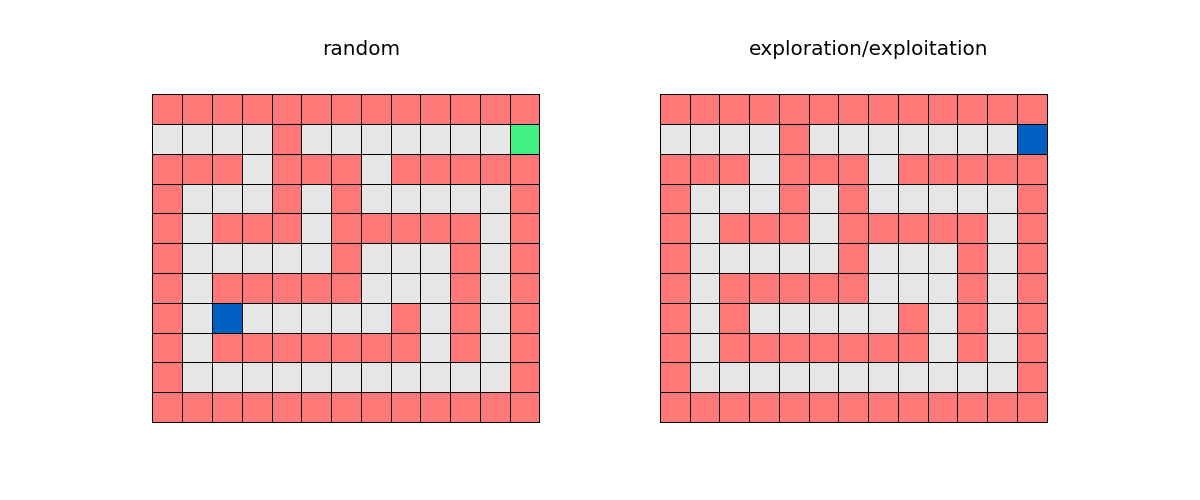
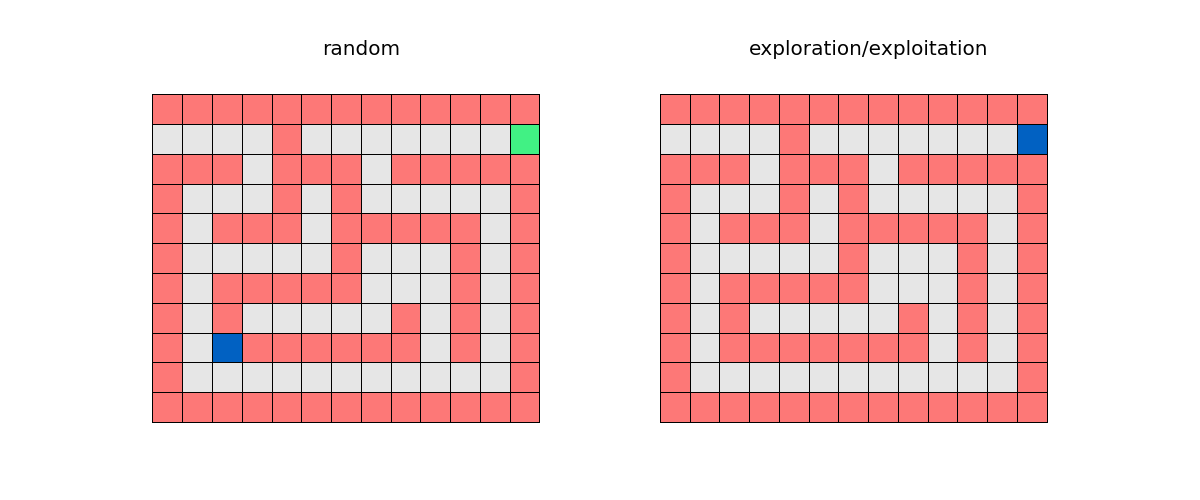
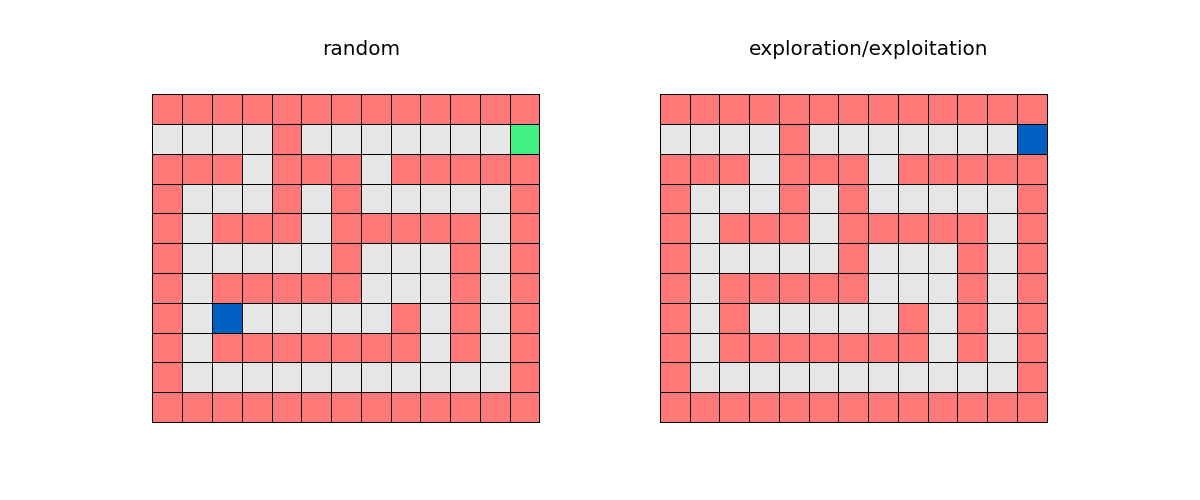
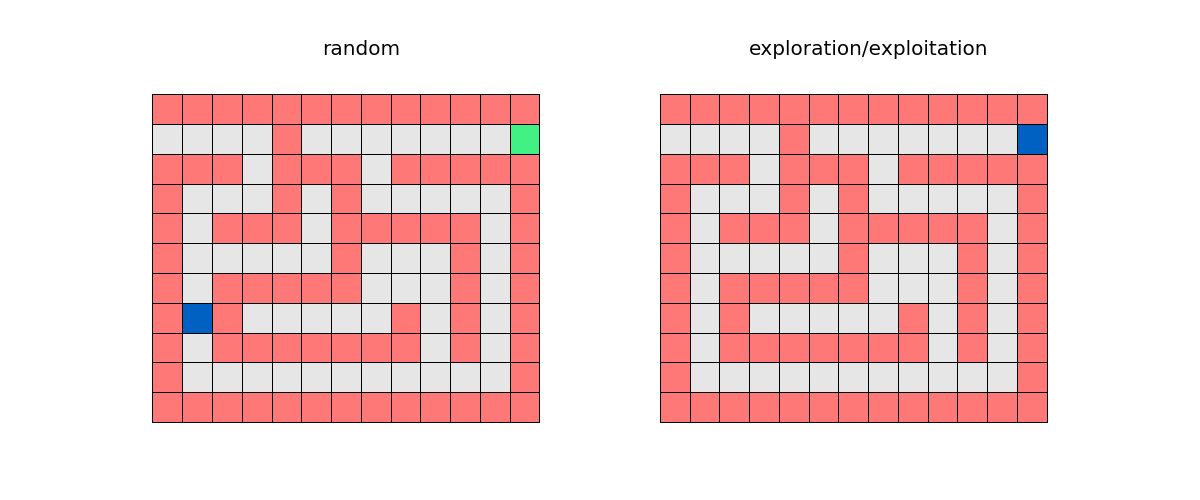
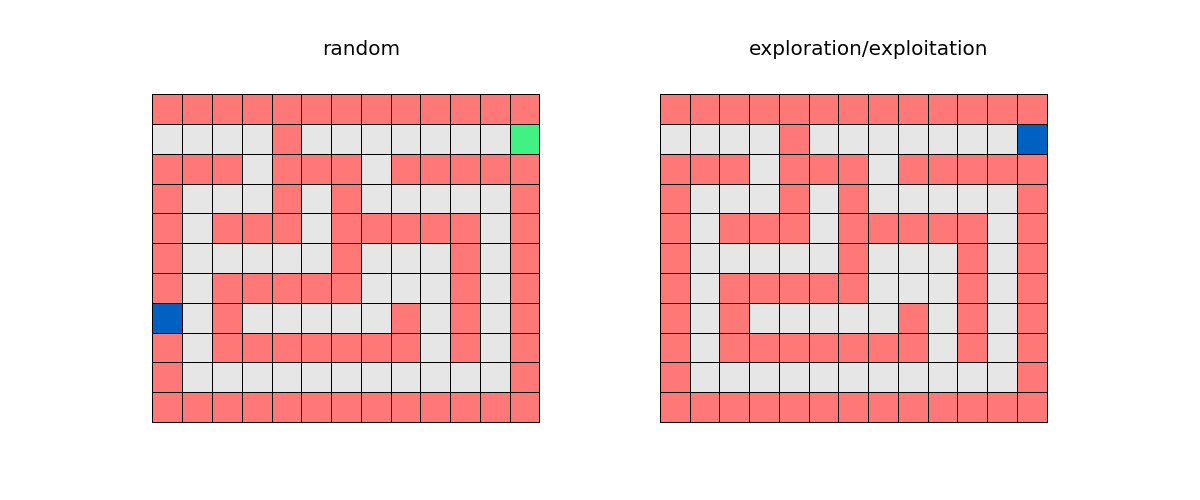
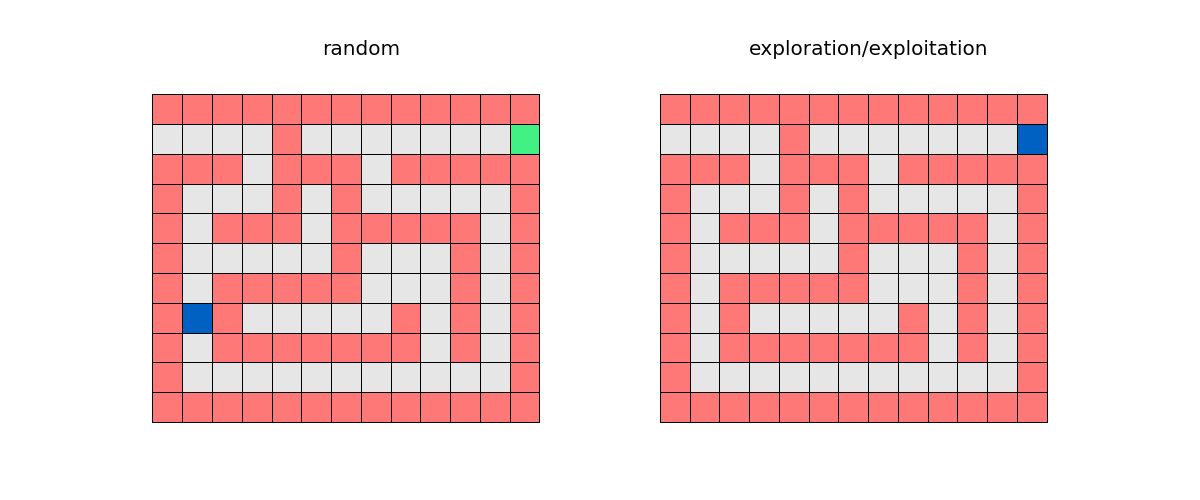
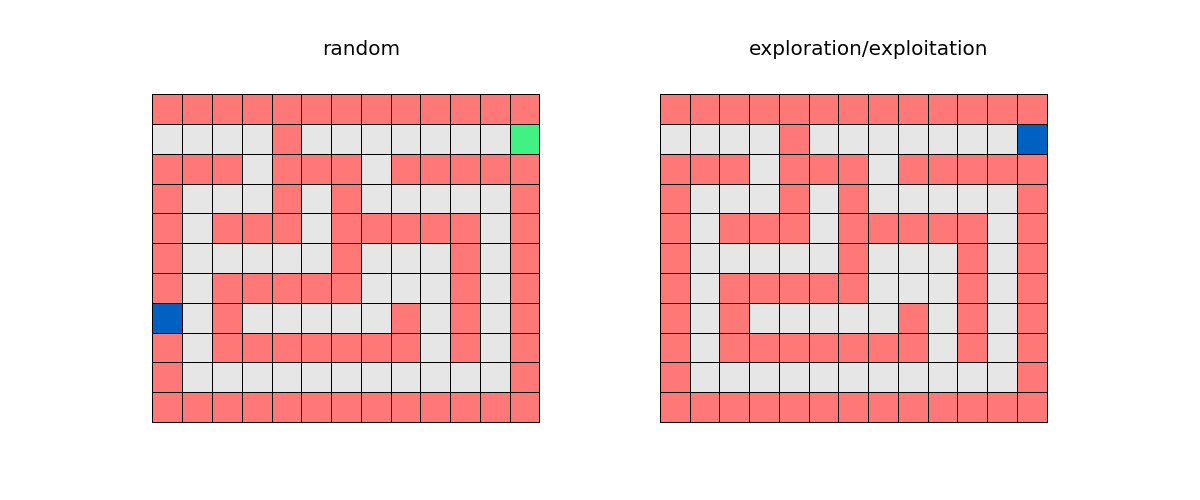
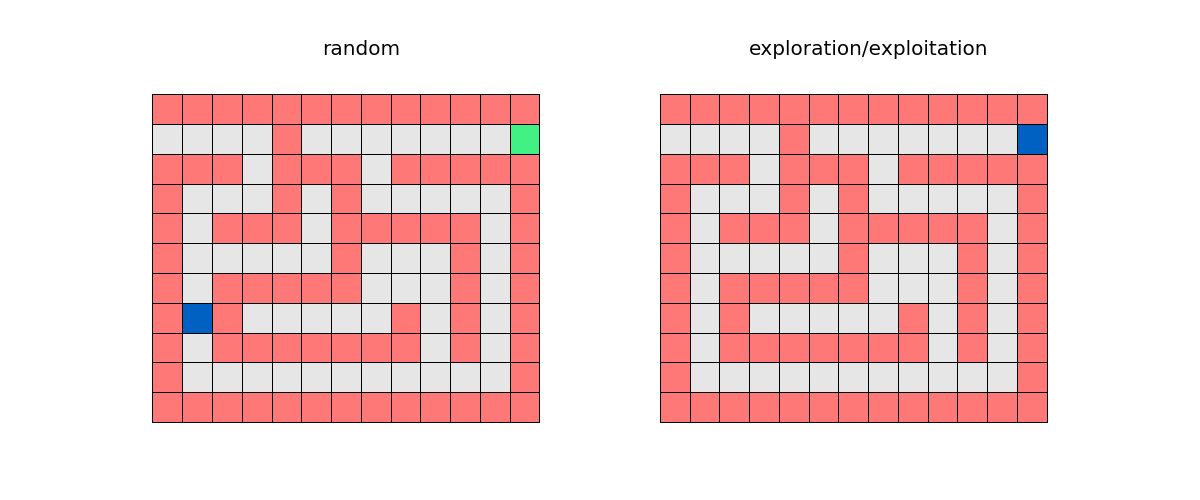
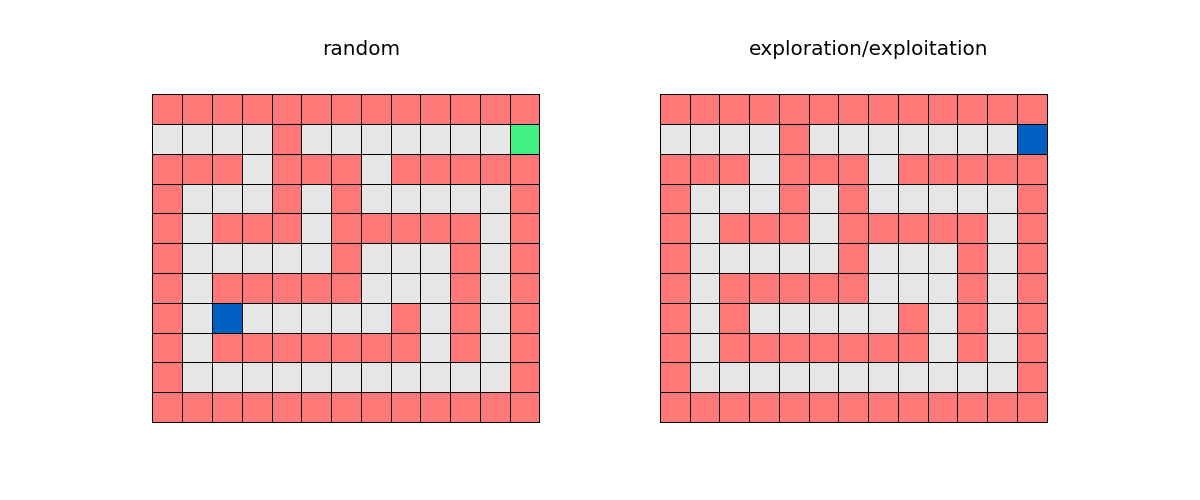
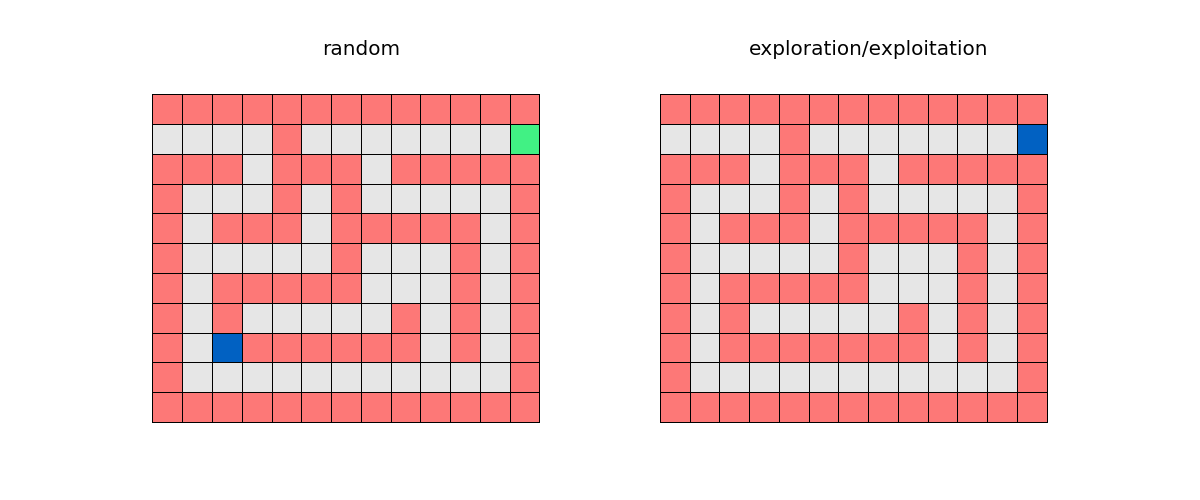
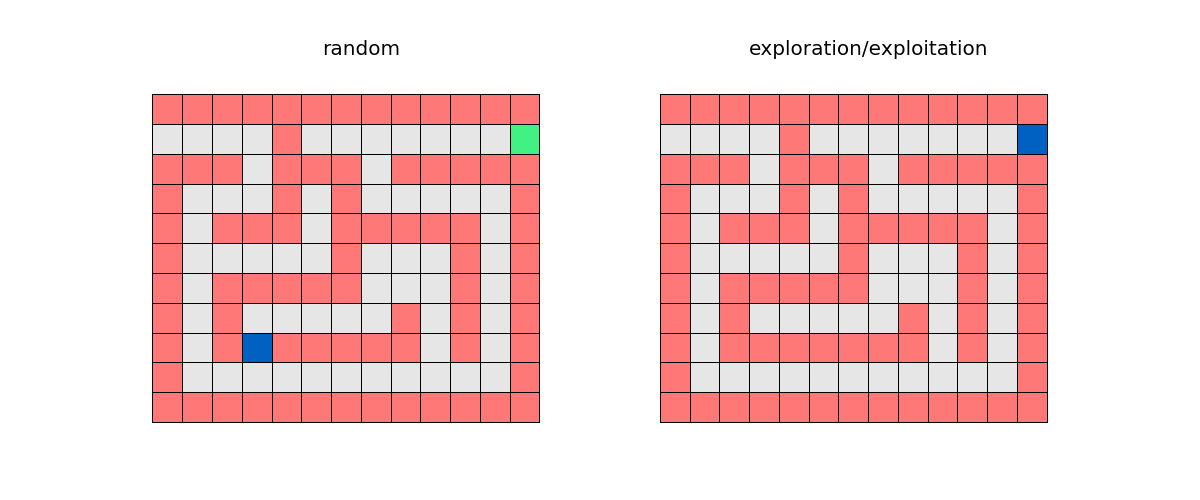
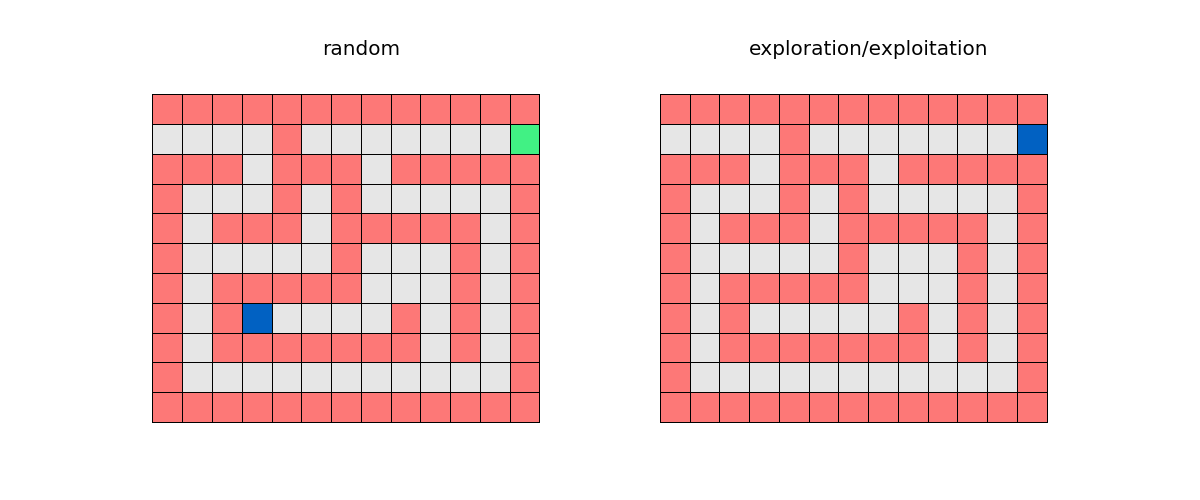
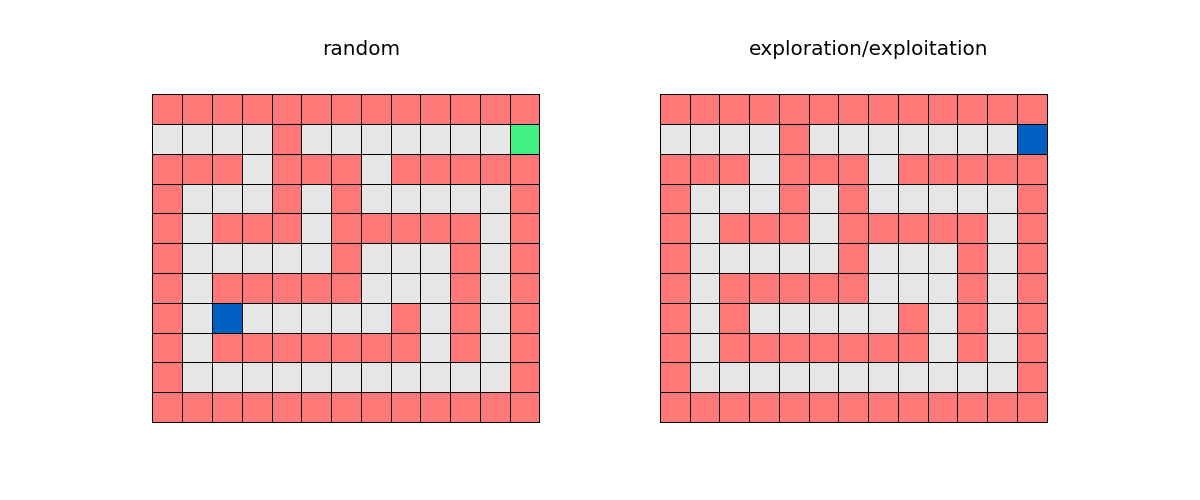
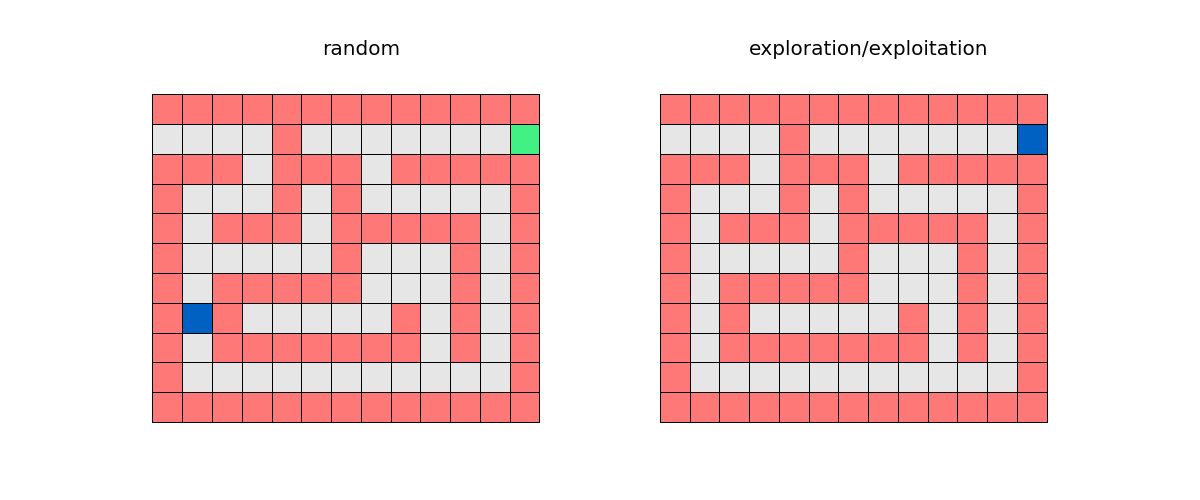
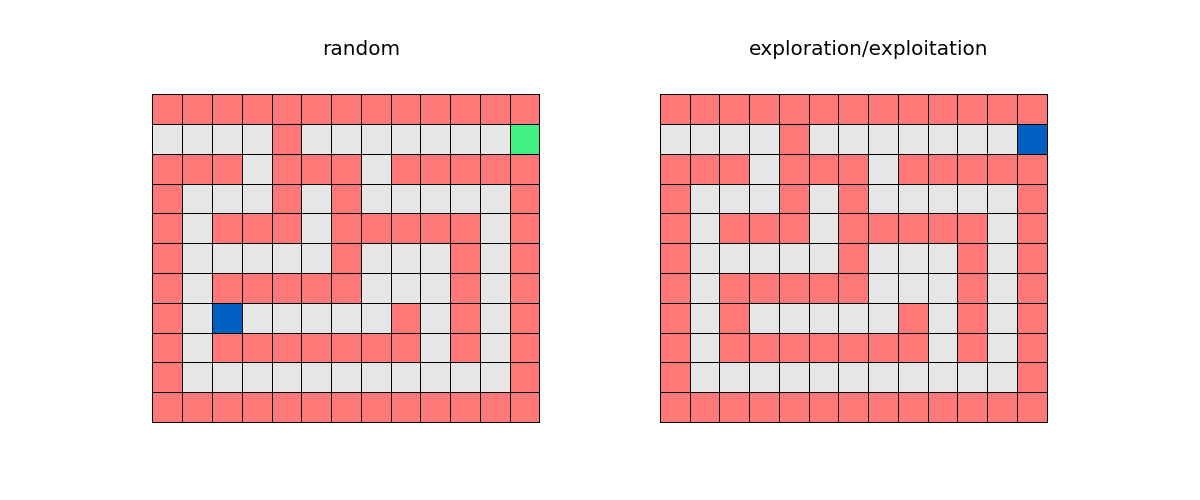
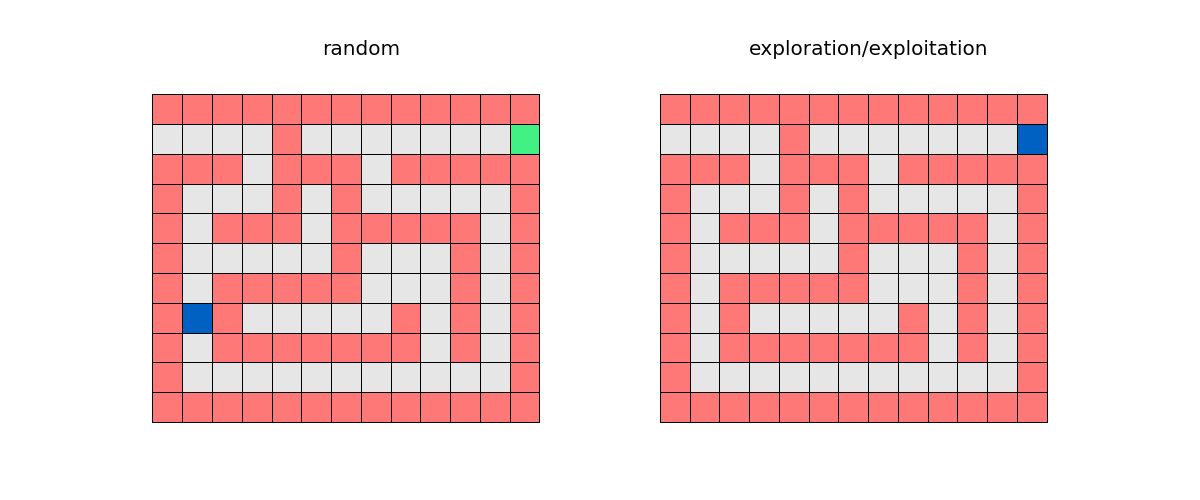
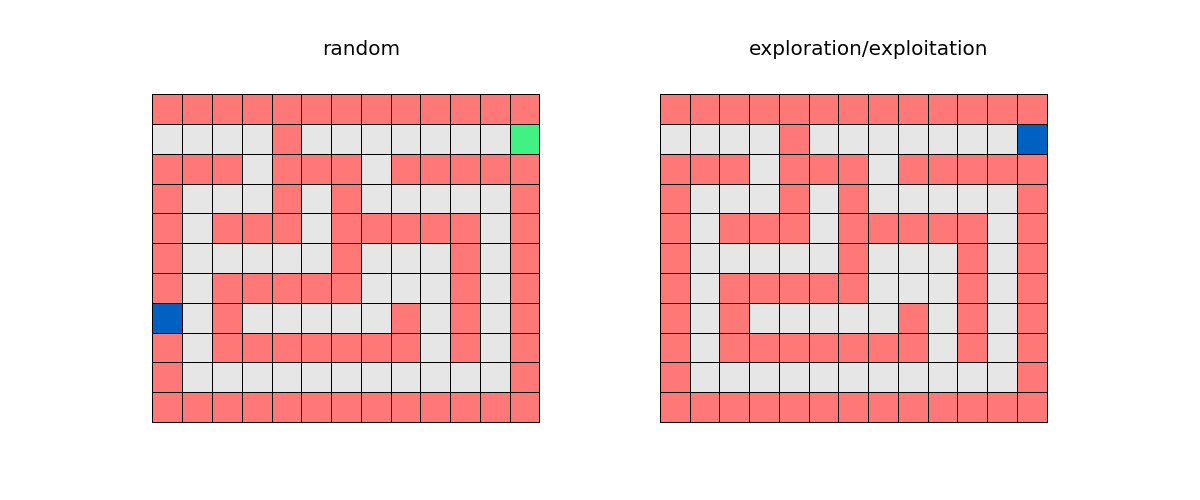
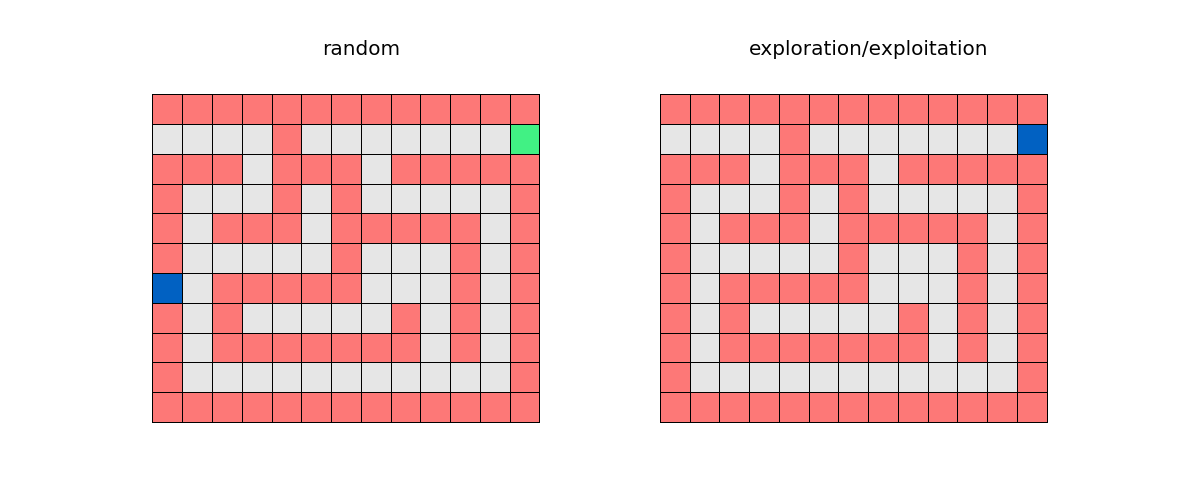
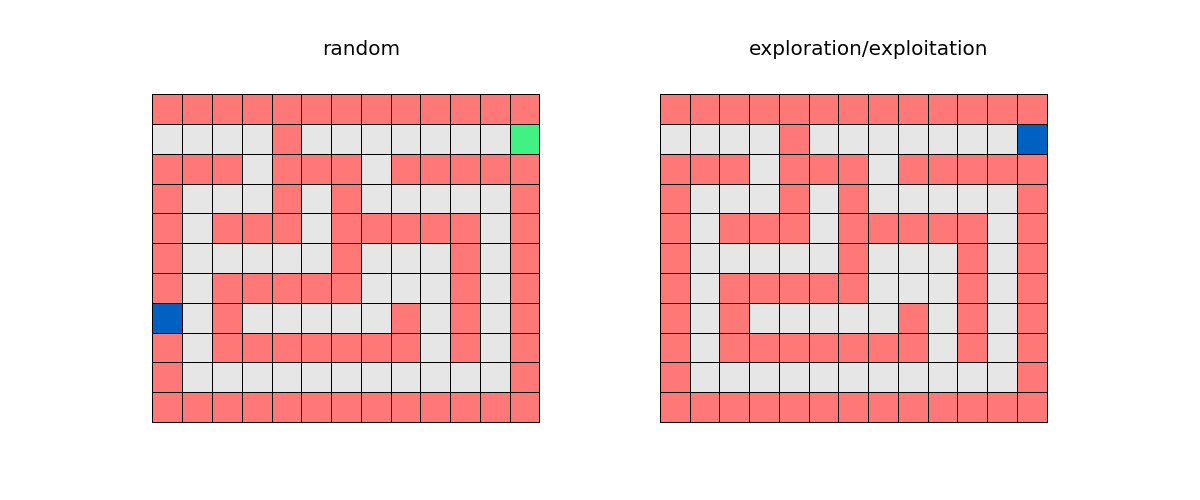
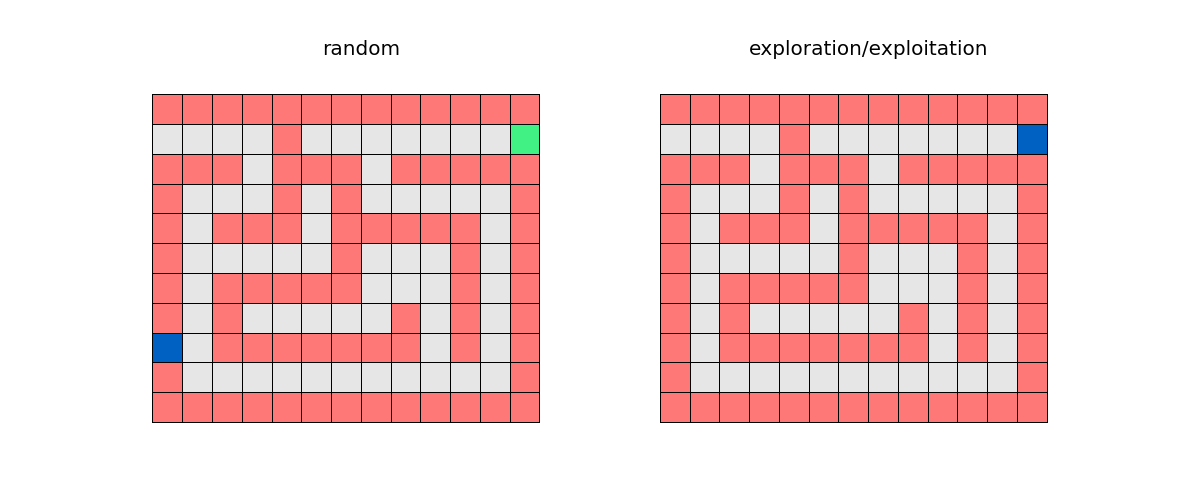
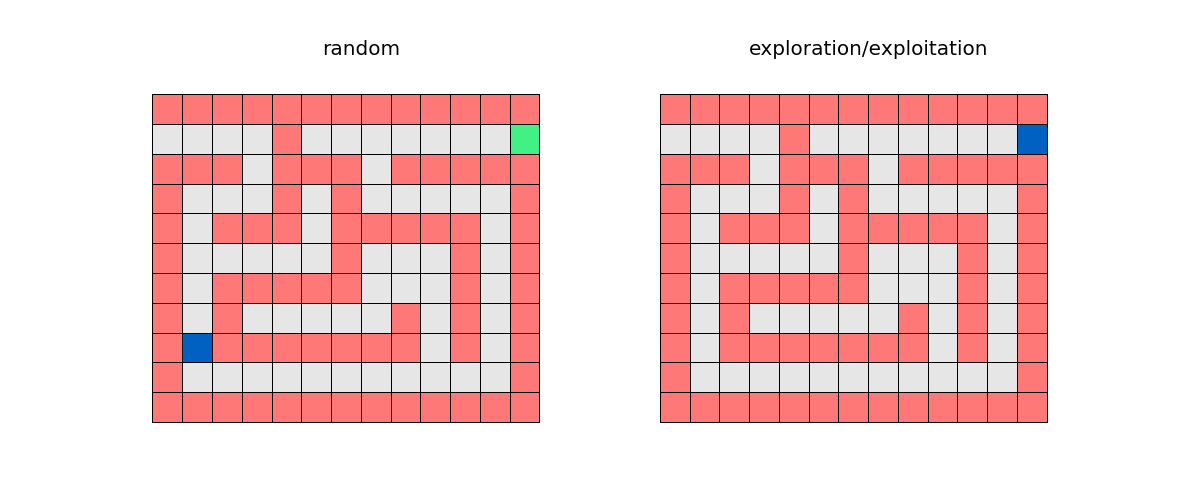
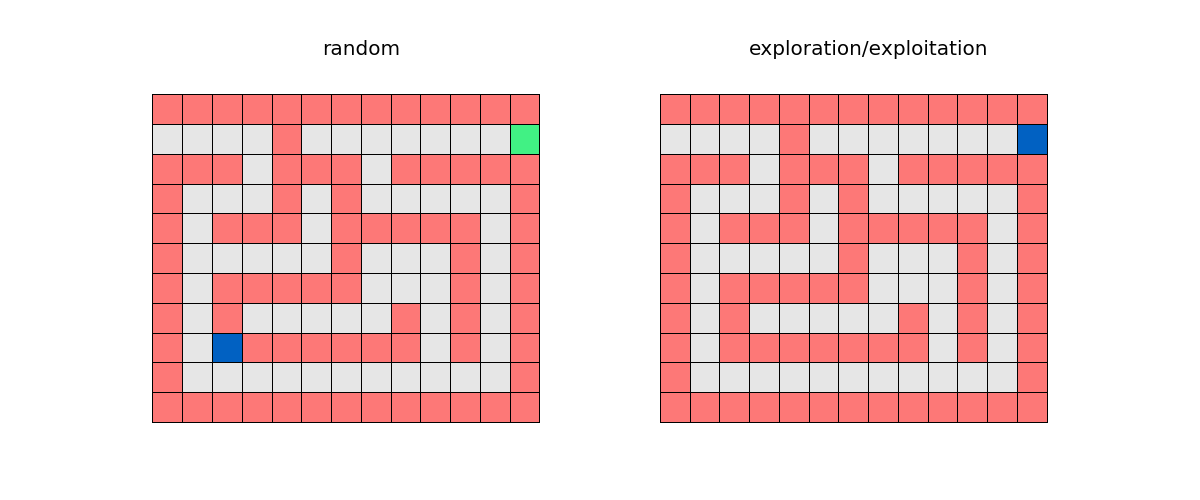
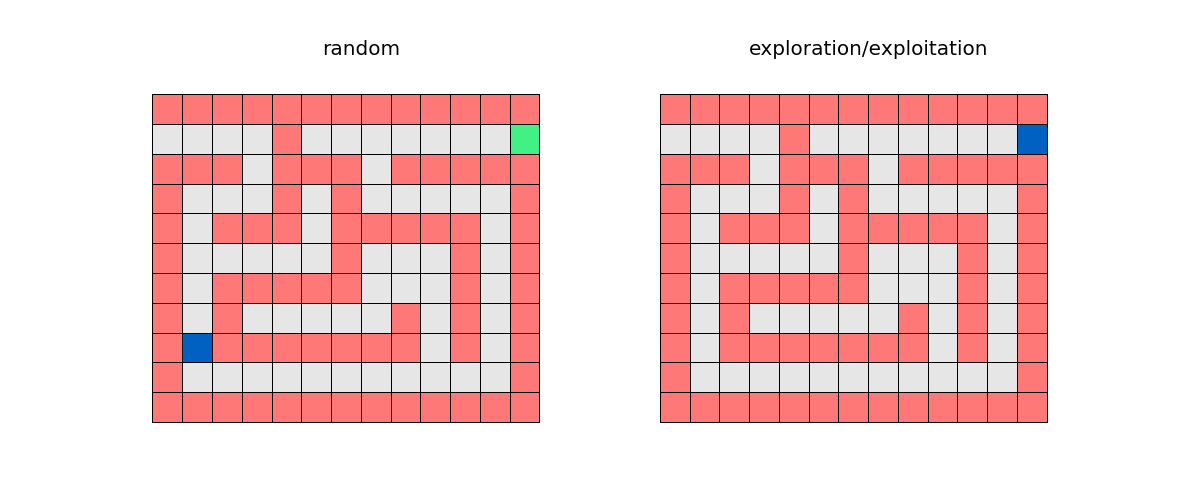
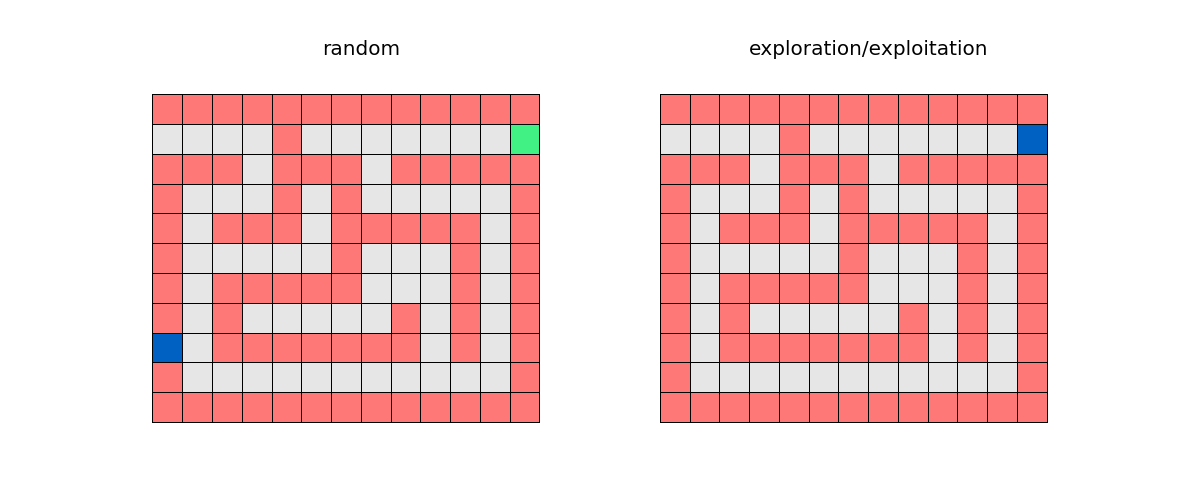
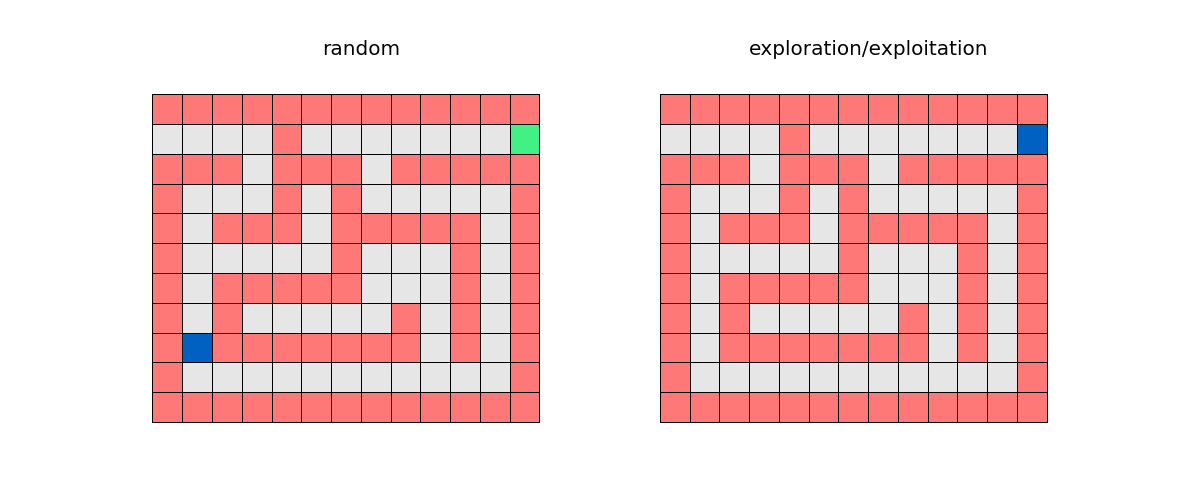
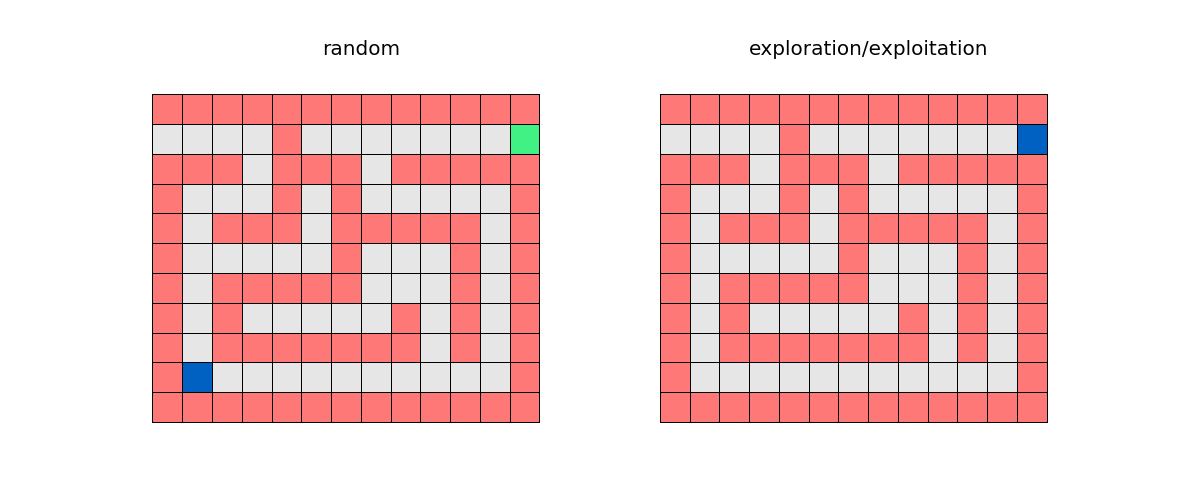
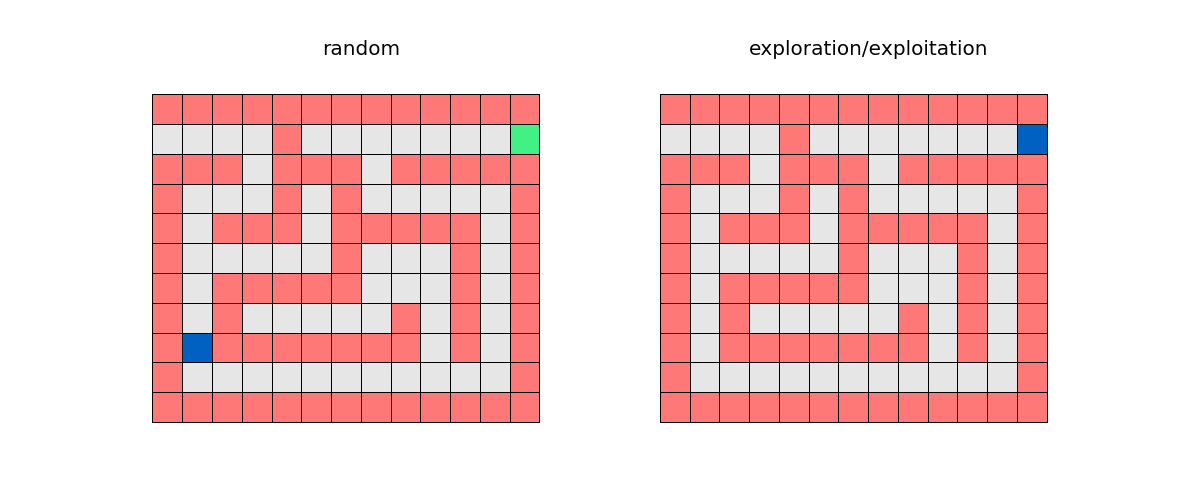

In [5]:
# run animator to compare action methods
animator.animate_training_comparison(gridworld = small_maze,learner_1 = random_qlearner,learner_2 = exploit_qlearner, episode = 19)

To get a bigger picture sense of the total cost savings we perform the above experiments over all 500 episodes of simulation, compute and compare the total training time, and plot the resulting total reward per episode of training for both methods. 

In [6]:
import time 

# compare random versus exploration-exploitation actions on training
training_rewards = []
methods = ['random','exploit']
for i in range(len(methods)):
    method = methods[i]
    
    # create instance of learner
    small_maze_qlearner = gridworld_qlearn.learner(gridworld = small_maze)
    
    # run q-learning
    start = time.clock()
    small_maze_qlearner.train(verbose = False, action_method = method)
    end = time.clock()
    value = (end - start)
    print 'method ' + str(method) + ' completed training in ' + str(value) + ' seconds'
    
    # record rewards and history
    training_rewards.append(small_maze_qlearner.training_reward)

q-learning algorithm complete
method random completed training in 5.854219 seconds
q-learning algorithm complete
method exploit completed training in 1.04753 seconds


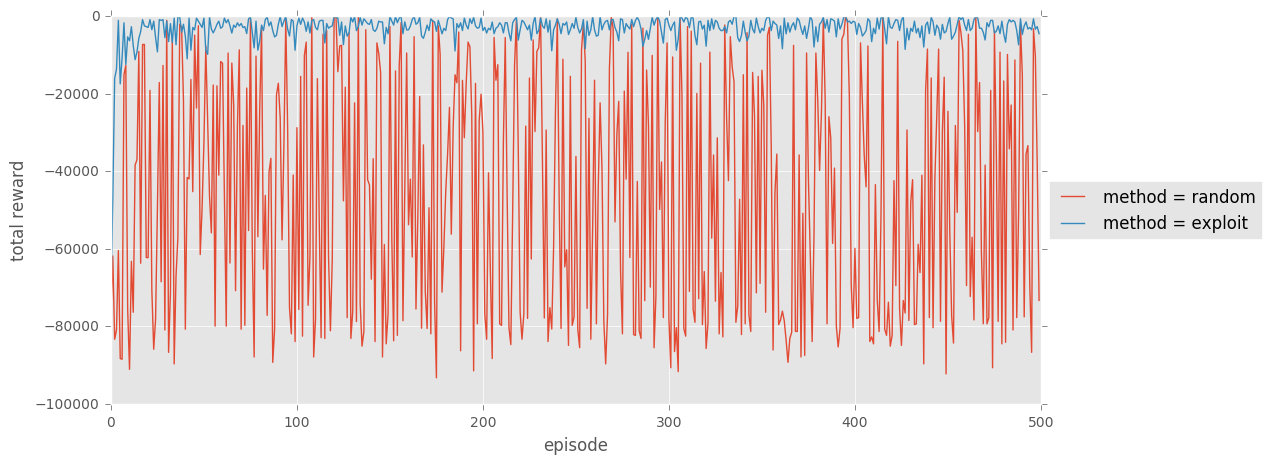

In [7]:
fig = plt.figure(figsize = (12,5))
ax = fig.add_subplot(1,1,1)

for i in range(len(methods)):
    ax.plot(training_rewards[i])
ax.set_xlabel('episode')
ax.set_ylabel('total reward')
ax.legend(['method = ' + str(methods[0]),'method = ' + str(methods[1])],loc='center left', bbox_to_anchor=(1, .5))
plt.show()

### Example. Exploration-exploitation on a larger Gridworld

The cost savings during training are even more impressive for larger problems. Here we compute and compare training times for both methods (random actions vs. exploration-exploitation) using a larger version of the Gridworld maze that you can see by activating the cell below.

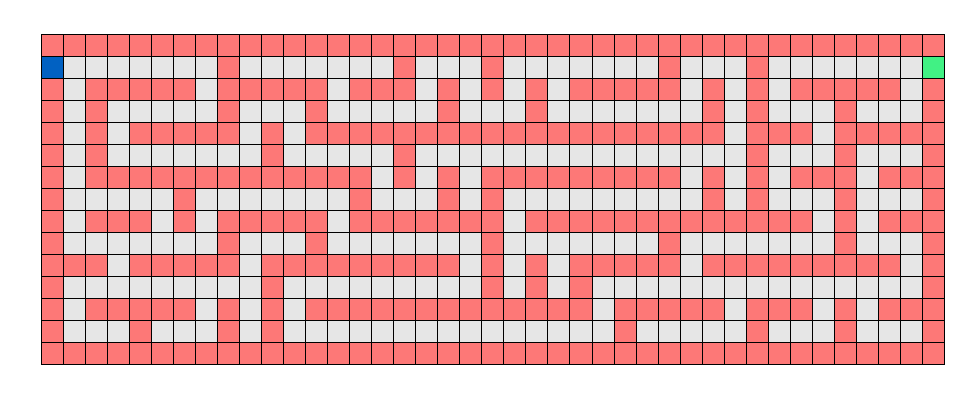

In [10]:
# generate a larger instance of Gridworld
large_maze = gridworld_enviro.environment(world_size = 'large', world_type = 'maze')

# show the grid
large_maze.color_gridworld()

In [11]:
# compare random versus exploration-exploitation actions on training
training_rewards = []
methods = ['random','exploit']
for i in range(len(methods)):
    method = methods[i]
    
    # create instance of learner
    large_maze_qlearner = gridworld_qlearn.learner(gridworld = large_maze)
    
    # run q-learning
    start = time.clock()
    large_maze_qlearner.train(verbose = False, action_method = method)
    end = time.clock()
    value = (end - start)
    print 'method ' + str(method) + ' completed training in ' + str(value) + ' seconds'
    
    # record rewards and history
    training_rewards.append(large_maze_qlearner.training_reward)

q-learning algorithm complete
method random completed training in 58.873819 seconds
q-learning algorithm complete
method exploit completed training in 10.055351 seconds


## 2. The short-term long-term reward trade-off

The If it is true, at least in the first episodes of Q-Learning, that the long-term reward isn't that trustworthy, why don't we dampen its contribution to the update? We can do this by adding a parameter (sometimes referred to as a penalty parameter or regularization parameter) to the long-term reward.  This **short-term long-term trade-off parameter** is tacked on to the long-term reward, and is often denoted by $\gamma$. With the trade-off parameter included, our recursion update formula takes a similar form as

$$Q\left(s_{k},\,a_{k}\right)=r_{k}+\gamma\cdot\underset{i\in\varOmega(s_{k+1})}{\text{maximum}}\,\,Q\left(s_{k+1},\,\alpha_{i}\right)$$

We constrain $\gamma \in [0,1]$ so that by scaling it up and down we can tune the influence that short-term versus long-term rewards have on how $Q$ is learned.  In particular by

- setting $\gamma$ to a smaller value we more heavily weight the contribution of the short-term reward $r_k$. In this case our agent learns to take a more **greedy** approach to accomplishing the goal, at each state taking the next step that essentially maximizes the short-term reward only.


- setting $\gamma$ close to $1$ we essentially have our original cost function back, where we take into account equal contributions of both short-term and long-term rewards.

As with the exploration-exploitation trade-off, one can either set $\gamma$ to a fixed value for all steps/episodes during training, or change its value from episode-to-episode according to a pre-defined schedule. Sometimes setting $\gamma$ to some value smaller than $1$ helps proving mathematical convergence of Q-Learning. In practice however $\gamma$ is usually set close to 1 (if not 1), and we just tinker with the exploration-exploitation probability, because in the end both trade-offs (exploration-exploitation and short-term long-term reward) address the same issue:  our initial distrust of $Q$.   

All together, we have the following enhanced version of the basic Q-Learning algorithm.

<hr style="height:1px;border:none;color:#555;background-color:#555;">
<p style="line-height: 1.7;">
<strong>1:</strong>&nbsp;&nbsp; initialize $Q$<br>
<strong>2:</strong>&nbsp;&nbsp; set the number of episodes $E$<br>
<strong>3:</strong>&nbsp;&nbsp; set the maximum number of steps per episode $T$<br>
<strong>4:</strong>&nbsp;&nbsp; set the exploration-exploitation probability $p\in[0,1]$<br>
<strong>5:</strong>&nbsp;&nbsp; set the short-term long-term reward trade-off $\gamma\in[0,1]$<br>

<strong>6:</strong>&nbsp;&nbsp; <code>for</code> $e$ = $1$, $2$, ..., $E$<br>
<strong>7:</strong>&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$k \longleftarrow 1$<br>
<strong>8:</strong>&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;select a random initial state $s_1$<br>
<strong>9:</strong>&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<code>while</code> goal state not reached <code>and</code> $k \leq T$<br>
<strong>10:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;choose a random number $r$ uniformly from the unit interval $[0,1]$<br>

<strong>11:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<code>if</code> $r<p$<br>

<strong>12:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;select a valid action $a_k$ at random<br>

<strong>13:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<code>else</code><br>

<strong>14:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;select the valid action $a_k$ that maximizes $Q\left(s_{k},\,a_{k}\right)$<br>

<strong>15:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<code>end if</code><br>

<strong>16:</strong>&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;record the resulting state $s_{k+1}$ and corresponding reward $r_k$<br>
<strong>17:</strong>&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$Q\left(s_{k},\,a_{k}\right) \longleftarrow r_{k}+\gamma\cdot\underset{i\in\varOmega(s_{k+1})}{\text{maximum}}\,\,Q\left(s_{k+1},\,\alpha_{i}\right)$<br>
<strong>18:</strong>&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$k \longleftarrow k+1$<br>
<strong>19:</strong>&nbsp;&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;<code>end while</code><br>
<strong>20:</strong>&nbsp; <code>end for</code><br>
<hr style="height:1px;border:none;color:#555;background-color:#555;">
</p>


In this notebook we introduced two enhancements that make Q-Learning more efficient. With these enhancements we managed to run Q-Learning on a large Gidworld maze (with more than 600 states) in a matter of seconds. However, in many RL problems (e.g., chess) the state space is so large that storing and computing with $Q$ becomes extremely challenging. In the next notebook we will discuss the crucial role function approximators (neural networks, trees, and kernels) play in ameliorating this issue, allowing us to extend the Reinforcement paradigm to problems with infinitely large state spaces.